## **Lab 2 | Handwritten Digit Recognition System**

Problem Statement
- Developing a handwritten digital recognition system by creating a neural network model trained on MNIST dataset "handwritten digits from 0 to 9"

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns

### **Step 1: [Loading MNIST dataset](https://www.kaggle.com/datasets/oddrationale/mnist-in-csv)**

In [2]:
train_data = pd.read_csv("mnist_train.csv")
test_data = pd.read_csv("mnist_test.csv")

print(train_data.head())

print("\nTrain Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)


   label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0      5    0    0    0    0    0    0    0    0    0  ...      0      0   
1      0    0    0    0    0    0    0    0    0    0  ...      0      0   
2      4    0    0    0    0    0    0    0    0    0  ...      0      0   
3      1    0    0    0    0    0    0    0    0    0  ...      0      0   
4      9    0    0    0    0    0    0    0    0    0  ...      0      0   

   28x21  28x22  28x23  28x24  28x25  28x26  28x27  28x28  
0      0      0      0      0      0      0      0      0  
1      0      0      0      0      0      0      0      0  
2      0      0      0      0      0      0      0      0  
3      0      0      0      0      0      0      0      0  
4      0      0      0      0      0      0      0      0  

[5 rows x 785 columns]

Train Data Shape: (60000, 785)
Test Data Shape: (10000, 785)


**Dataset description:**
 - The MNIST dataset contains grayscale images of digits along with their corresponding labels.
 - Each image is 28x28 pixels, flattened into a vector of size 784.
 - The labels range from 0 to 9.

#### *Checking dataset distribution*

In [3]:
print("\nTrain Data Distribution:")
print(train_data.iloc[:, 0].value_counts())

print("\nTest Data Distribution:")
print(test_data.iloc[:, 0].value_counts())


Train Data Distribution:
label
1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: count, dtype: int64

Test Data Distribution:
label
1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: count, dtype: int64


**Conclusion**: the distribution is well balanced, no label is significantly overrepresented, or underrepresented, which minimizes bias towards a specific label

### **Step 2: Data Splitting**

In [3]:
X_temp = train_data.iloc[:,1:].values
y_temp = train_data.iloc[:, 0].values

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=10000, stratify=y_temp, random_state=42)

X_test = test_data.iloc[:, 1:].values
y_test = test_data.iloc[:, 0].values

In [5]:
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 50000
Validation set size: 10000
Test set size: 10000


#### *Normalization*
 dividing by 255, so that ranges are [0,1], ensuring numerical stability during training

In [4]:
X_test = X_test / 255.0
X_train = X_train / 255.0
X_val = X_val / 255.0

Visual representation of a random sample

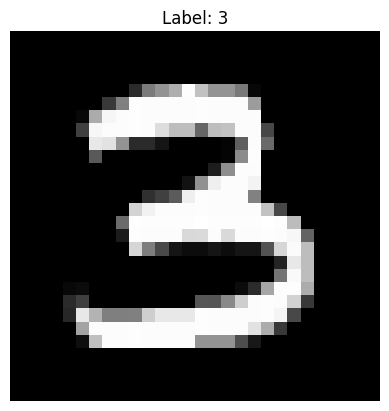

In [7]:
sample_image = X_train[10]
sample_label = y_train[10]
sample_image = sample_image.reshape(28, 28)

plt.imshow(sample_image, cmap='gray')
plt.title(f"Label: {sample_label}")
plt.axis('off')
plt.show()

### **Step 3: Converting Data to Tensors**

In [5]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


### **Step 4: Data Loaders** to facilitate batch processing

In [6]:
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Step 5: Neural Network Design**
Fully connected feedforward neural network with:
- Input layer: 784 neurons, one for each pixel
- 2 hidden layers: 128 neurons in the first, and 64 neurons in the second
- Output layer: 10 neurons, one for each class
- activation function: ReLU

In [ ]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.dropout1 = nn.Dropout(p=0.5) #regularization
        self.l2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(p=0.5)
        self.output = nn.Linear(64, 10)
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.dropout1(x) 
        x = self.activation_fn(self.l2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x


- Loss function: Cross-Entropy Loss
- Optimization technique: Stochastic Gradient Descent (SGD)
- Learning Rate: 0.01

In [23]:
model = FeedforwardNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

### **Step 6: Training the model**

In [24]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
  train_losses = []
  train_accuracies = []

  val_losses = []
  val_accuracies = []

  for epoch in range(epochs):

      # Training Loss and Accuracy
      model.train()
      running_loss = 0.0
      correct = 0
      total = 0

      for inputs, labels in train_loader:

          inputs = inputs.view(-1, 784)
          optimizer.zero_grad()

          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          loss.backward() #gradient calculations
          optimizer.step() #weight updates
            
          running_loss += loss.item() 

          _, predicted = torch.max(outputs.data, 1) #predicted class
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      train_loss = running_loss / len(train_loader)
      train_accuracy = 100 * correct / total

      train_losses.append(train_loss)
      train_accuracies.append(train_accuracy)

      # Validation Loss and Accuracy
      model.eval()
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      for inputs, labels in val_loader:

          inputs = inputs.view(-1, 784)
          outputs = model(inputs)
          loss = loss_fn(outputs, labels)
          val_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          val_total += labels.size(0)
          val_correct += (predicted == labels).sum().item()

      val_loss = val_loss / len(val_loader)
      val_accuracy = 100 * val_correct / val_total

      val_losses.append(val_loss)
      val_accuracies.append(val_accuracy)

      print(f'Epoch [{epoch+1}/{epochs}]')
      print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
      print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

  # Plot the training loss
  plt.figure(figsize=(12, 10))

  # Plot loss
  plt.subplot(2, 2, 1)  # Training Loss
  plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
  plt.title('Training Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  plt.subplot(2, 2, 2)  # Validation Loss
  plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
  plt.title('Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

  # Plot accuracy
  plt.subplot(2, 2, 3)  # Training Accuracy
  plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
  plt.title('Training Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  plt.subplot(2, 2, 4)  # Validation Accuracy
  plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
  plt.title('Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy (%)')

  # Show the plots
  plt.tight_layout()
  plt.show()

  return train_accuracy, val_accuracy

Epoch [1/10]
Training Loss: 1.6516, Accuracy: 46.44%
Validation Loss: 0.7091, Accuracy: 81.34%
Epoch [2/10]
Training Loss: 0.7909, Accuracy: 74.74%
Validation Loss: 0.4472, Accuracy: 87.60%
Epoch [3/10]
Training Loss: 0.6008, Accuracy: 81.81%
Validation Loss: 0.3630, Accuracy: 89.62%
Epoch [4/10]
Training Loss: 0.5179, Accuracy: 84.75%
Validation Loss: 0.3090, Accuracy: 91.08%
Epoch [5/10]
Training Loss: 0.4638, Accuracy: 86.57%
Validation Loss: 0.2760, Accuracy: 91.75%
Epoch [6/10]
Training Loss: 0.4275, Accuracy: 87.71%
Validation Loss: 0.2565, Accuracy: 92.53%
Epoch [7/10]
Training Loss: 0.3975, Accuracy: 88.82%
Validation Loss: 0.2378, Accuracy: 92.98%
Epoch [8/10]
Training Loss: 0.3744, Accuracy: 89.51%
Validation Loss: 0.2216, Accuracy: 93.49%
Epoch [9/10]
Training Loss: 0.3549, Accuracy: 89.88%
Validation Loss: 0.2108, Accuracy: 93.85%
Epoch [10/10]
Training Loss: 0.3367, Accuracy: 90.53%
Validation Loss: 0.1987, Accuracy: 94.18%


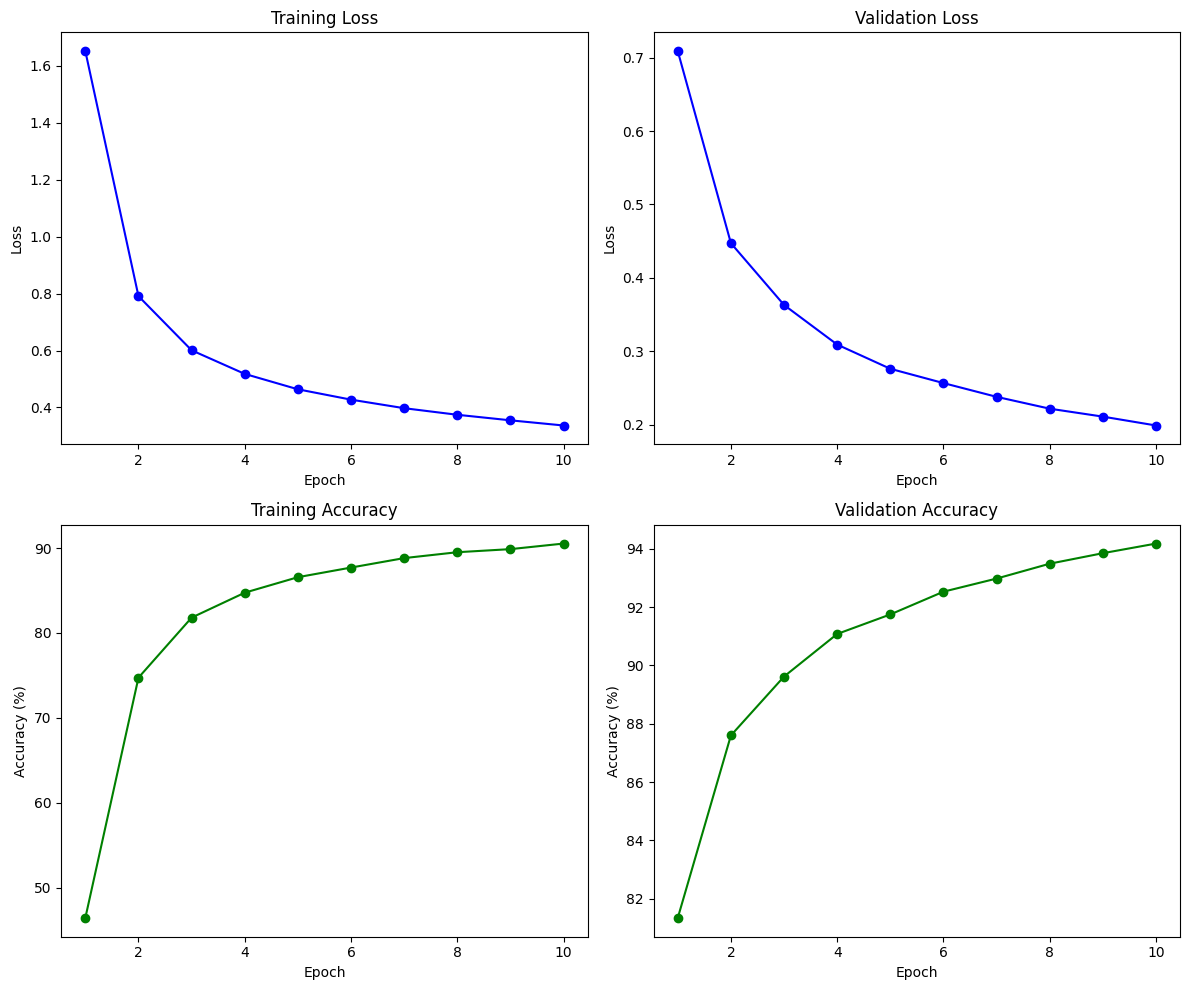

In [25]:
train_acc, val_acc = train(model, train_loader, val_loader, loss_fn, optimizer, 10)

*Conclusion*
After 10 epochs:


In [26]:
print(f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.2f}%')

Training Accuracy: 90.5320, Validation Accuracy: 94.18%


### **Step 7: Testing the model**

In [27]:
def test(model, test_loader):
  model.eval()
  correct = 0
  total = 0

  # Storing all predictions and true labels
  all_preds = []
  all_labels = []

  with torch.no_grad():
      for inputs, labels in test_loader:
          # Reshaping inputs
          inputs = inputs.view(inputs.size(0), -1)  # Automatically handle batch size
          outputs = model(inputs)

          # Get predicted labels
          _, predicted = torch.max(outputs, dim=1)

          # Update metrics
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

          # Store predictions and true labels
          all_preds.extend(predicted.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())

  # Calculate overall accuracy
  test_accuracy = 100 * correct / total
  print(f"Test Accuracy: {test_accuracy:.2f}%")


  cm = confusion_matrix(all_labels, all_preds)

  # Plotting the confusion matrix
  plt.figure(figsize=(10, 7))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

  ################################

  # Visualize multiple sample predictions
  sample_indices = [0,1,2,3,4,5]

  num_samples = len(sample_indices)
  plt.figure(figsize=(12, 3 * num_samples))

  for i, index in enumerate(sample_indices):
      sample_image = X_test[index]
      true_label = y_test[index]

      # Prepare the sample for the model
      sample_image = torch.tensor(sample_image).float().view(1, -1)

      with torch.no_grad():
          output = model(sample_image)
          _, predicted_label = torch.max(output, 1)

      # Plot the image
      plt.subplot(1, num_samples, i + 1)
      plt.imshow(sample_image.reshape(28, 28), cmap='gray')
      plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
      plt.axis('off')

  plt.tight_layout()
  plt.show()

## Part 4 | **Analysis**

### 1. Change Learning Rate [0.1, 0.05, 0.01, 0.001, 0.0001]
* Batch size = 32
* Neurons number: 128 then 64

Training model with learning rate 0.1...
Epoch [1/10]
Training Loss: 0.6528, Accuracy: 79.78%
Validation Loss: 0.2644, Accuracy: 92.25%
Epoch [2/10]
Training Loss: 0.3412, Accuracy: 90.16%
Validation Loss: 0.1687, Accuracy: 95.18%
Epoch [3/10]
Training Loss: 0.2965, Accuracy: 91.67%
Validation Loss: 0.1504, Accuracy: 95.64%
Epoch [4/10]
Training Loss: 0.2648, Accuracy: 92.31%
Validation Loss: 0.1364, Accuracy: 96.07%
Epoch [5/10]
Training Loss: 0.2476, Accuracy: 92.83%
Validation Loss: 0.1331, Accuracy: 96.10%
Epoch [6/10]
Training Loss: 0.2324, Accuracy: 93.34%
Validation Loss: 0.1240, Accuracy: 96.53%
Epoch [7/10]
Training Loss: 0.2178, Accuracy: 93.71%
Validation Loss: 0.1210, Accuracy: 96.57%
Epoch [8/10]
Training Loss: 0.2145, Accuracy: 93.87%
Validation Loss: 0.1185, Accuracy: 96.62%
Epoch [9/10]
Training Loss: 0.2084, Accuracy: 94.00%
Validation Loss: 0.1171, Accuracy: 96.77%
Epoch [10/10]
Training Loss: 0.1997, Accuracy: 94.24%
Validation Loss: 0.1135, Accuracy: 96.84%


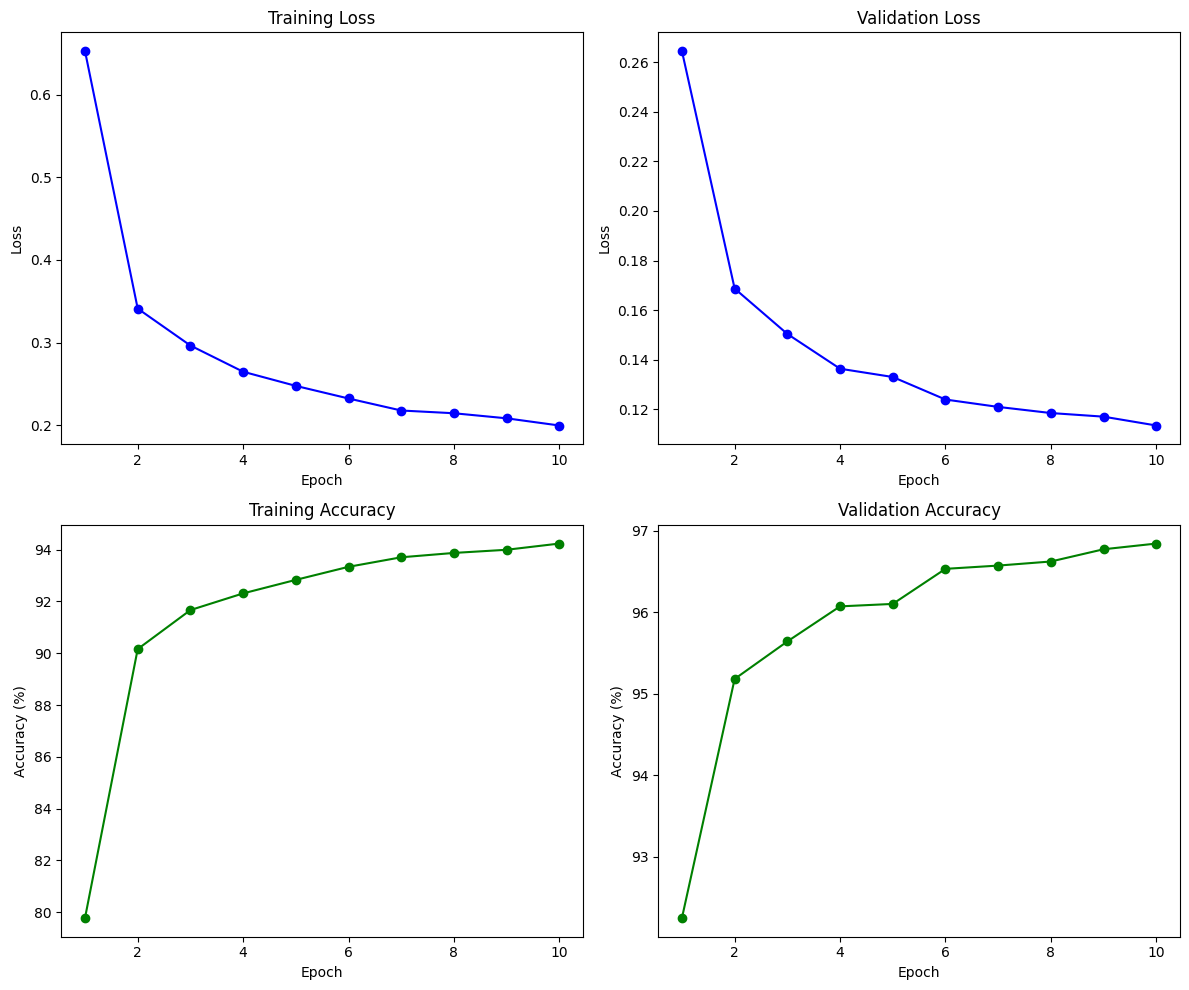

Training model with learning rate 0.05...
Epoch [1/10]
Training Loss: 0.8355, Accuracy: 73.21%
Validation Loss: 0.3325, Accuracy: 90.23%
Epoch [2/10]
Training Loss: 0.4111, Accuracy: 88.21%
Validation Loss: 0.2147, Accuracy: 93.78%
Epoch [3/10]
Training Loss: 0.3343, Accuracy: 90.48%
Validation Loss: 0.1792, Accuracy: 94.86%
Epoch [4/10]
Training Loss: 0.2934, Accuracy: 91.74%
Validation Loss: 0.1678, Accuracy: 95.18%
Epoch [5/10]
Training Loss: 0.2670, Accuracy: 92.47%
Validation Loss: 0.1462, Accuracy: 95.88%
Epoch [6/10]
Training Loss: 0.2497, Accuracy: 92.85%
Validation Loss: 0.1435, Accuracy: 95.80%
Epoch [7/10]
Training Loss: 0.2327, Accuracy: 93.37%
Validation Loss: 0.1321, Accuracy: 96.41%
Epoch [8/10]
Training Loss: 0.2232, Accuracy: 93.62%
Validation Loss: 0.1311, Accuracy: 96.35%
Epoch [9/10]
Training Loss: 0.2101, Accuracy: 93.97%
Validation Loss: 0.1259, Accuracy: 96.62%
Epoch [10/10]
Training Loss: 0.2042, Accuracy: 94.07%
Validation Loss: 0.1182, Accuracy: 96.60%


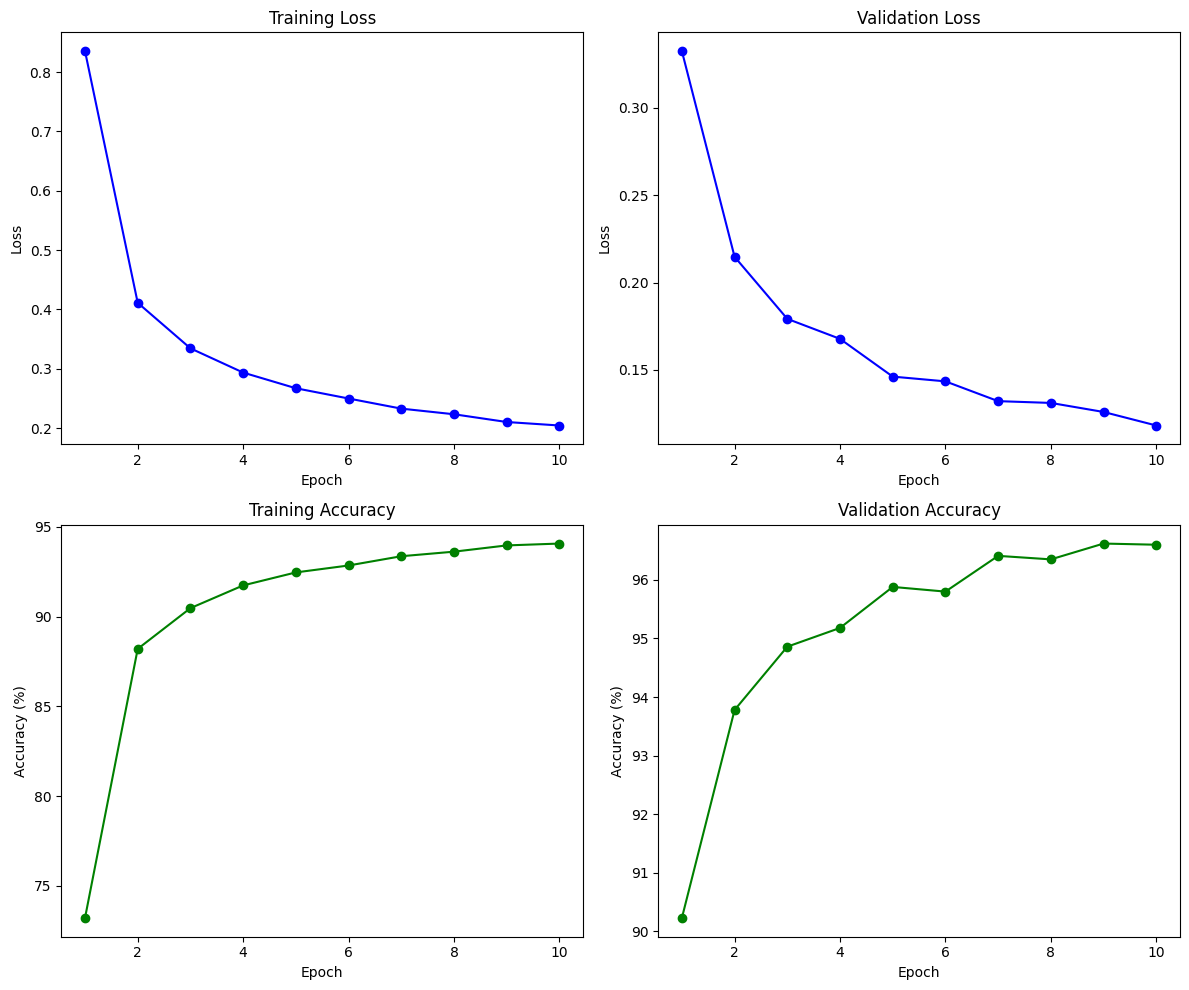

Training model with learning rate 0.01...
Epoch [1/10]
Training Loss: 1.6954, Accuracy: 42.55%
Validation Loss: 0.7608, Accuracy: 82.72%
Epoch [2/10]
Training Loss: 0.8000, Accuracy: 74.93%
Validation Loss: 0.4419, Accuracy: 87.97%
Epoch [3/10]
Training Loss: 0.6063, Accuracy: 81.98%
Validation Loss: 0.3581, Accuracy: 89.90%
Epoch [4/10]
Training Loss: 0.5155, Accuracy: 84.87%
Validation Loss: 0.3082, Accuracy: 91.06%
Epoch [5/10]
Training Loss: 0.4601, Accuracy: 86.78%
Validation Loss: 0.2801, Accuracy: 91.79%
Epoch [6/10]
Training Loss: 0.4163, Accuracy: 88.07%
Validation Loss: 0.2513, Accuracy: 92.61%
Epoch [7/10]
Training Loss: 0.3878, Accuracy: 88.97%
Validation Loss: 0.2331, Accuracy: 93.03%
Epoch [8/10]
Training Loss: 0.3633, Accuracy: 89.72%
Validation Loss: 0.2188, Accuracy: 93.63%
Epoch [9/10]
Training Loss: 0.3420, Accuracy: 90.24%
Validation Loss: 0.2043, Accuracy: 93.90%
Epoch [10/10]
Training Loss: 0.3300, Accuracy: 90.70%
Validation Loss: 0.1942, Accuracy: 94.40%


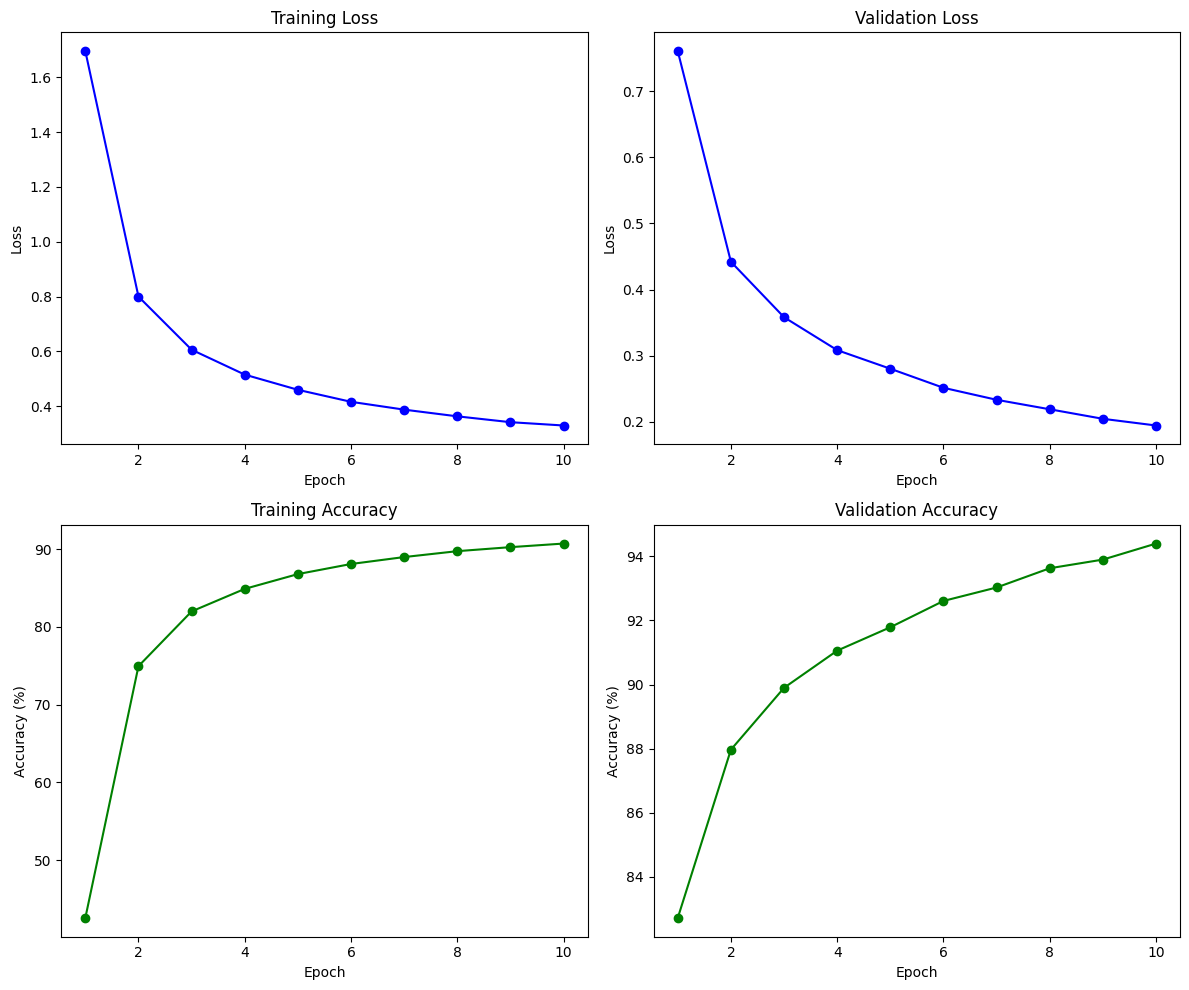

Training model with learning rate 0.001...
Epoch [1/10]
Training Loss: 2.2973, Accuracy: 10.85%
Validation Loss: 2.2762, Accuracy: 21.26%
Epoch [2/10]
Training Loss: 2.2603, Accuracy: 21.02%
Validation Loss: 2.2244, Accuracy: 49.94%
Epoch [3/10]
Training Loss: 2.1963, Accuracy: 32.04%
Validation Loss: 2.1211, Accuracy: 58.80%
Epoch [4/10]
Training Loss: 2.0673, Accuracy: 39.30%
Validation Loss: 1.9080, Accuracy: 62.18%
Epoch [5/10]
Training Loss: 1.8440, Accuracy: 44.98%
Validation Loss: 1.5809, Accuracy: 65.07%
Epoch [6/10]
Training Loss: 1.6009, Accuracy: 49.64%
Validation Loss: 1.2864, Accuracy: 69.70%
Epoch [7/10]
Training Loss: 1.4011, Accuracy: 54.44%
Validation Loss: 1.0824, Accuracy: 74.37%
Epoch [8/10]
Training Loss: 1.2607, Accuracy: 58.43%
Validation Loss: 0.9437, Accuracy: 77.10%
Epoch [9/10]
Training Loss: 1.1537, Accuracy: 61.98%
Validation Loss: 0.8400, Accuracy: 79.33%
Epoch [10/10]
Training Loss: 1.0632, Accuracy: 65.51%
Validation Loss: 0.7611, Accuracy: 81.10%


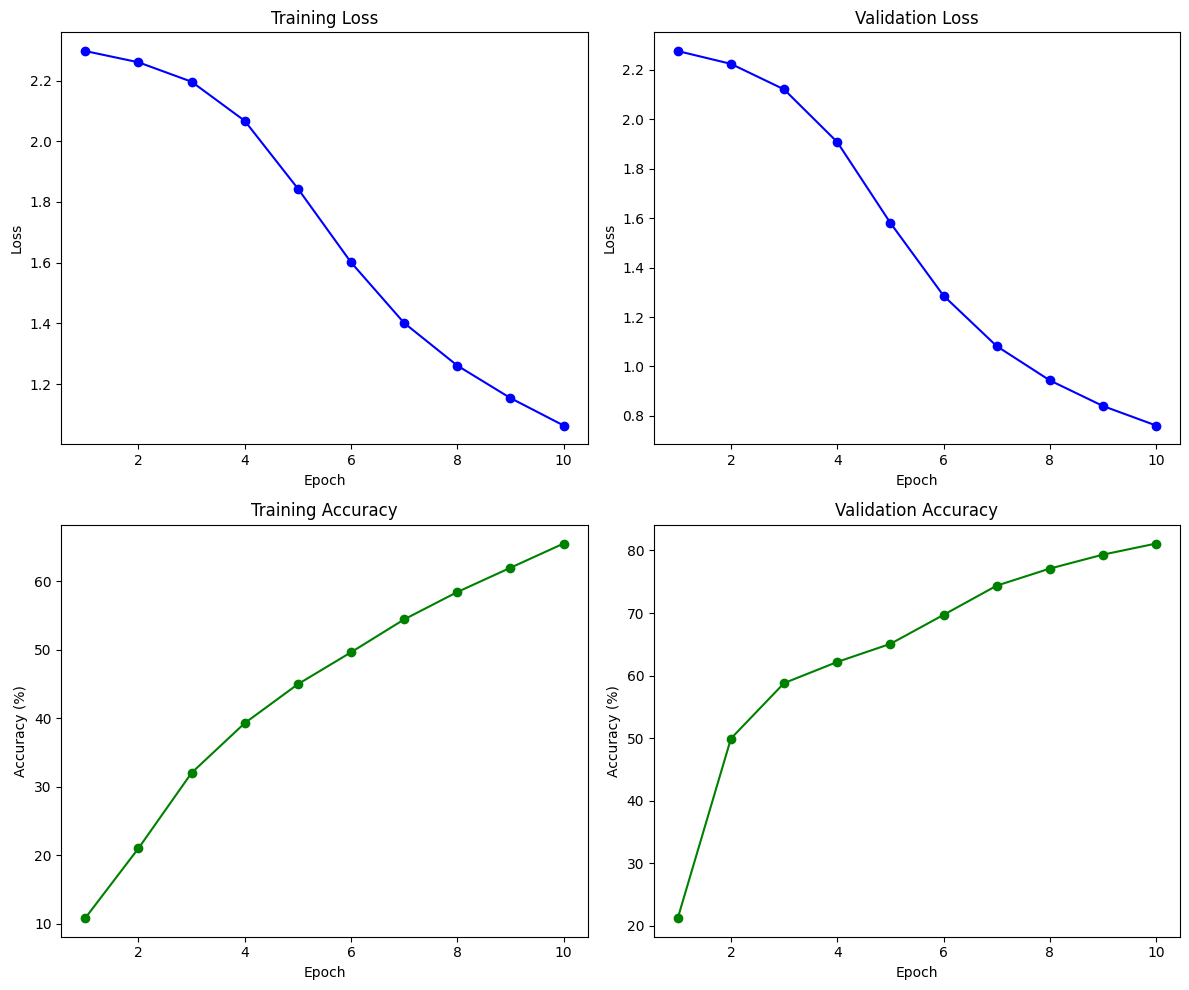

Training model with learning rate 0.0001...
Epoch [1/10]
Training Loss: 2.3035, Accuracy: 12.71%
Validation Loss: 2.3005, Accuracy: 15.76%
Epoch [2/10]
Training Loss: 2.3003, Accuracy: 13.64%
Validation Loss: 2.2973, Accuracy: 17.31%
Epoch [3/10]
Training Loss: 2.2974, Accuracy: 14.62%
Validation Loss: 2.2940, Accuracy: 18.59%
Epoch [4/10]
Training Loss: 2.2937, Accuracy: 15.86%
Validation Loss: 2.2904, Accuracy: 19.55%
Epoch [5/10]
Training Loss: 2.2905, Accuracy: 16.60%
Validation Loss: 2.2867, Accuracy: 20.02%
Epoch [6/10]
Training Loss: 2.2876, Accuracy: 17.48%
Validation Loss: 2.2827, Accuracy: 20.34%
Epoch [7/10]
Training Loss: 2.2829, Accuracy: 18.73%
Validation Loss: 2.2785, Accuracy: 20.60%
Epoch [8/10]
Training Loss: 2.2796, Accuracy: 19.60%
Validation Loss: 2.2740, Accuracy: 20.73%
Epoch [9/10]
Training Loss: 2.2752, Accuracy: 20.60%
Validation Loss: 2.2692, Accuracy: 20.90%
Epoch [10/10]
Training Loss: 2.2714, Accuracy: 21.09%
Validation Loss: 2.2641, Accuracy: 21.03%


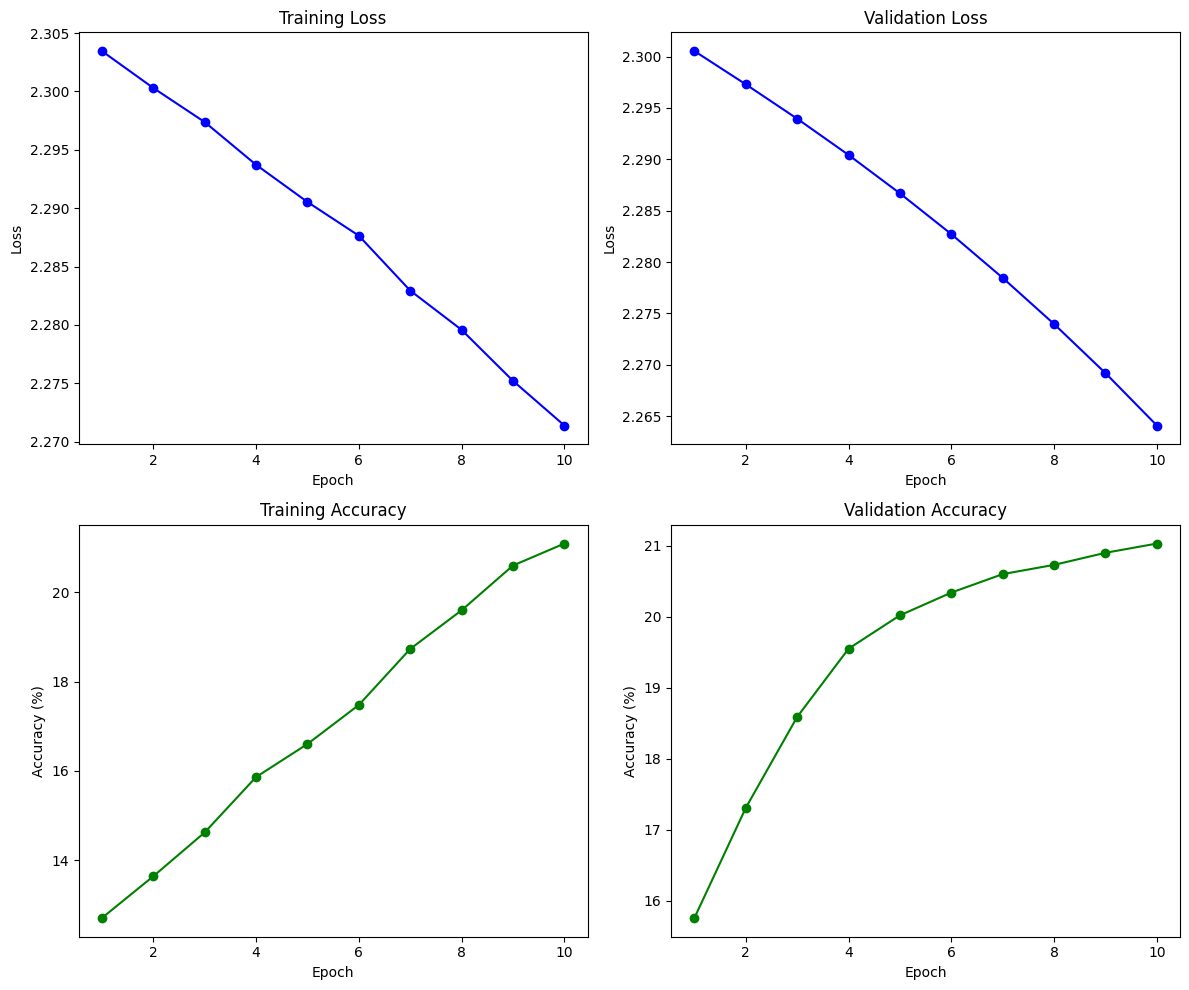

Training accuracies: [94.236, 94.074, 90.702, 65.508, 21.092]
Validation accuracies: [96.84, 96.6, 94.4, 81.1, 21.03]


In [28]:
learning_rates = [0.1, 0.05, 0.01, 0.001, 0.0001]

train_accuracies = []
val_accuracies = []

for lr in learning_rates:
    model = FeedforwardNN()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr)
    print(f"Training model with learning rate {lr}...")
    train_acc, val_acc = train(model, train_loader, val_loader, loss_fn, optimizer, 10)

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

print("Training accuracies:", train_accuracies)
print("Validation accuracies:", val_accuracies)


### **Conclusion**

In [30]:
# Print a table with learning rate, training accuracy, and validation accuracy
print(f"{'Learning Rate':<15}{'Train Accuracy (%)':<20}{'Val Accuracy (%)':<20}")
print("-" * 55)  # For separation line

# Loop through the learning rates and corresponding accuracies
for lr, train_acc, val_acc in zip(learning_rates, train_accuracies, val_accuracies):
    print(f"{lr:<15}{train_acc:<20.2f}{val_acc:<20.2f}")


Learning Rate  Train Accuracy (%)  Val Accuracy (%)    
-------------------------------------------------------
0.1            94.24               96.84               
0.05           94.07               96.60               
0.01           90.70               94.40               
0.001          65.51               81.10               
0.0001         21.09               21.03               


### 2. Change Batch size [32, 64, 128, 256, 512]
* Learning rate = 0.1
* Neurons number: 128 then 64

Epoch [1/10]
Training Loss: 0.6768, Accuracy: 78.87%
Validation Loss: 0.2715, Accuracy: 91.83%
Epoch [2/10]
Training Loss: 0.3584, Accuracy: 89.68%
Validation Loss: 0.1933, Accuracy: 94.29%
Epoch [3/10]
Training Loss: 0.3081, Accuracy: 91.16%
Validation Loss: 0.1586, Accuracy: 95.48%
Epoch [4/10]
Training Loss: 0.2716, Accuracy: 92.26%
Validation Loss: 0.1470, Accuracy: 95.92%
Epoch [5/10]
Training Loss: 0.2557, Accuracy: 92.74%
Validation Loss: 0.1353, Accuracy: 96.23%
Epoch [6/10]
Training Loss: 0.2417, Accuracy: 93.09%
Validation Loss: 0.1361, Accuracy: 96.17%
Epoch [7/10]
Training Loss: 0.2272, Accuracy: 93.48%
Validation Loss: 0.1287, Accuracy: 96.46%
Epoch [8/10]
Training Loss: 0.2223, Accuracy: 93.71%
Validation Loss: 0.1192, Accuracy: 96.69%
Epoch [9/10]
Training Loss: 0.2117, Accuracy: 93.81%
Validation Loss: 0.1210, Accuracy: 96.69%
Epoch [10/10]
Training Loss: 0.2051, Accuracy: 94.19%
Validation Loss: 0.1252, Accuracy: 96.58%


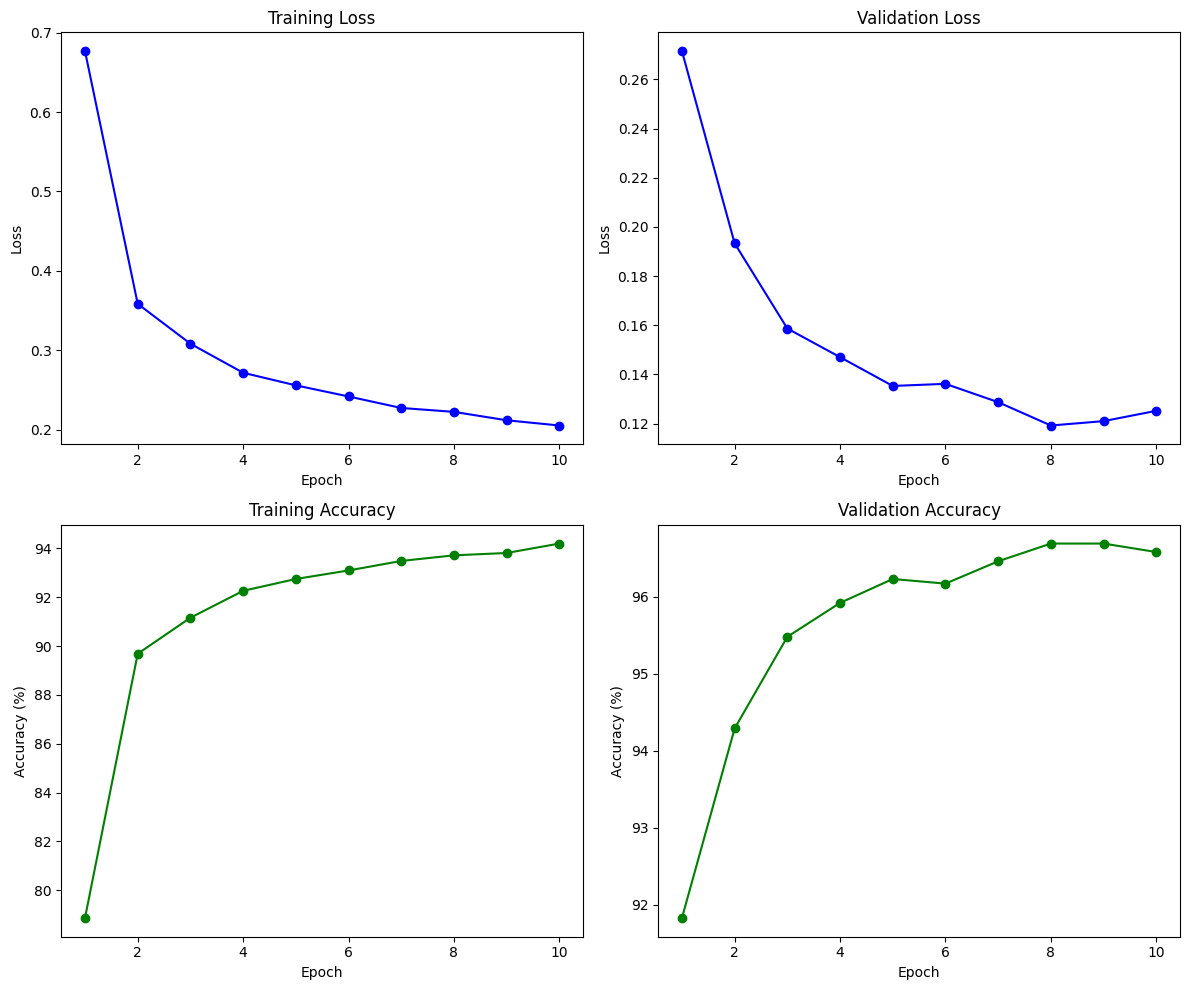

Epoch [1/10]
Training Loss: 0.8099, Accuracy: 74.66%
Validation Loss: 0.3003, Accuracy: 90.74%
Epoch [2/10]
Training Loss: 0.4004, Accuracy: 88.47%
Validation Loss: 0.2321, Accuracy: 93.06%
Epoch [3/10]
Training Loss: 0.3276, Accuracy: 90.75%
Validation Loss: 0.1825, Accuracy: 94.71%
Epoch [4/10]
Training Loss: 0.2843, Accuracy: 91.87%
Validation Loss: 0.1599, Accuracy: 95.26%
Epoch [5/10]
Training Loss: 0.2616, Accuracy: 92.51%
Validation Loss: 0.1576, Accuracy: 95.36%
Epoch [6/10]
Training Loss: 0.2445, Accuracy: 93.17%
Validation Loss: 0.1383, Accuracy: 96.08%
Epoch [7/10]
Training Loss: 0.2312, Accuracy: 93.39%
Validation Loss: 0.1314, Accuracy: 96.23%
Epoch [8/10]
Training Loss: 0.2162, Accuracy: 93.76%
Validation Loss: 0.1269, Accuracy: 96.49%
Epoch [9/10]
Training Loss: 0.2055, Accuracy: 94.07%
Validation Loss: 0.1289, Accuracy: 96.49%
Epoch [10/10]
Training Loss: 0.2036, Accuracy: 94.23%
Validation Loss: 0.1317, Accuracy: 96.29%


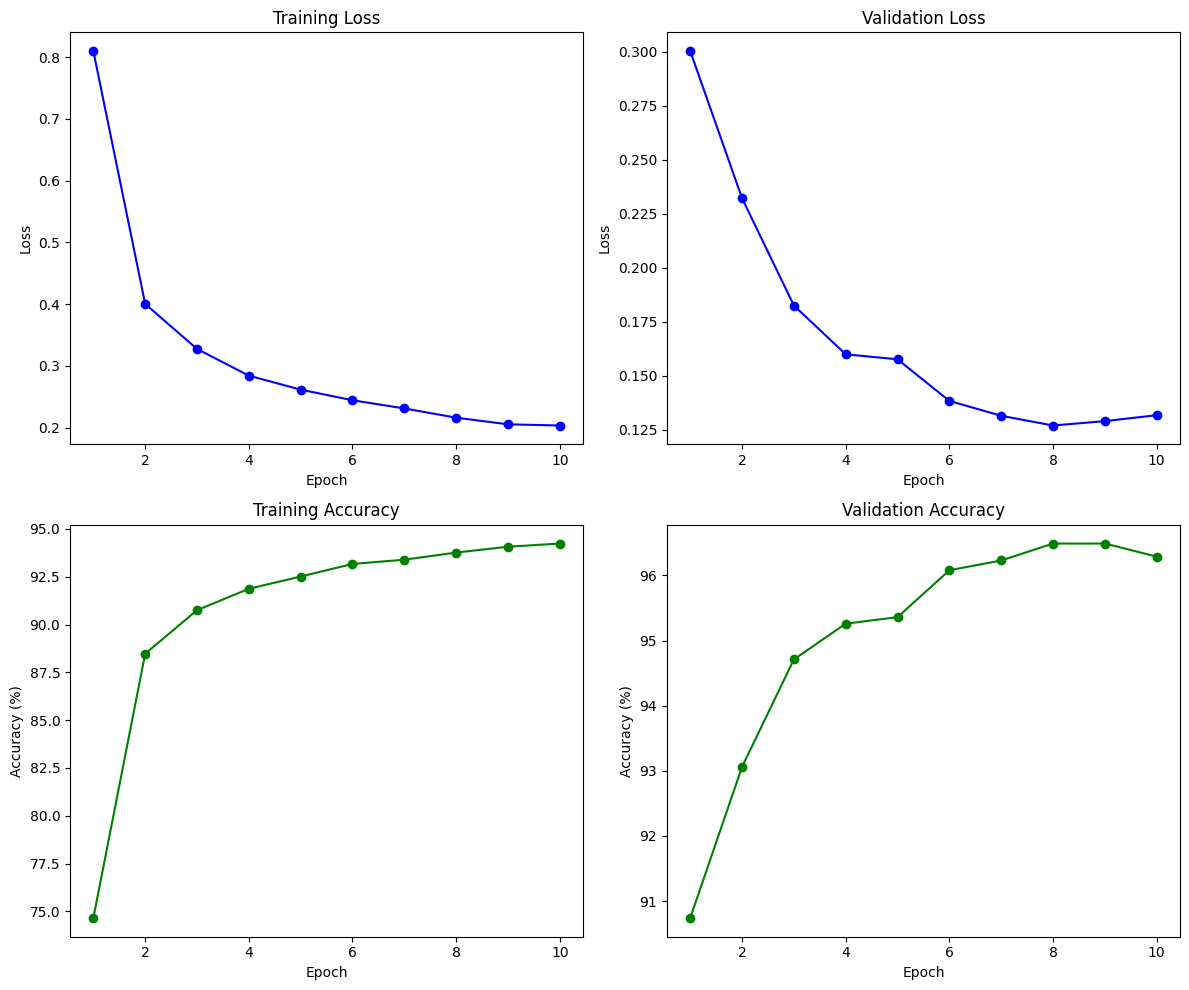

Epoch [1/10]
Training Loss: 1.1145, Accuracy: 63.97%
Validation Loss: 0.4011, Accuracy: 89.08%
Epoch [2/10]
Training Loss: 0.5137, Accuracy: 84.73%
Validation Loss: 0.2788, Accuracy: 91.70%
Epoch [3/10]
Training Loss: 0.4118, Accuracy: 87.98%
Validation Loss: 0.2247, Accuracy: 93.33%
Epoch [4/10]
Training Loss: 0.3519, Accuracy: 90.09%
Validation Loss: 0.1964, Accuracy: 94.23%
Epoch [5/10]
Training Loss: 0.3209, Accuracy: 91.01%
Validation Loss: 0.1757, Accuracy: 94.78%
Epoch [6/10]
Training Loss: 0.2886, Accuracy: 91.77%
Validation Loss: 0.1637, Accuracy: 95.20%
Epoch [7/10]
Training Loss: 0.2716, Accuracy: 92.32%
Validation Loss: 0.1556, Accuracy: 95.40%
Epoch [8/10]
Training Loss: 0.2557, Accuracy: 92.73%
Validation Loss: 0.1441, Accuracy: 95.71%
Epoch [9/10]
Training Loss: 0.2418, Accuracy: 93.00%
Validation Loss: 0.1374, Accuracy: 95.87%
Epoch [10/10]
Training Loss: 0.2352, Accuracy: 93.44%
Validation Loss: 0.1299, Accuracy: 96.16%


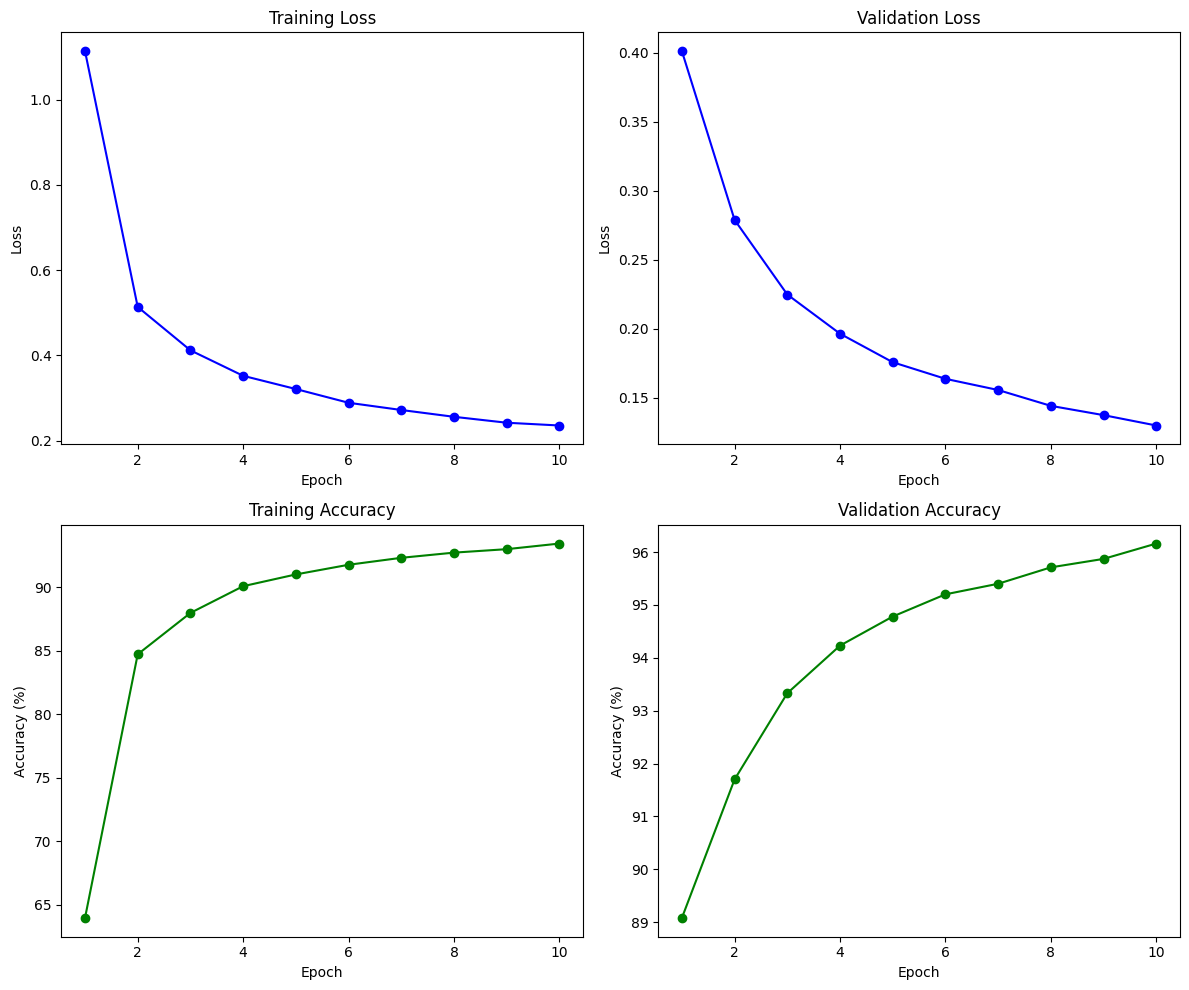

Epoch [1/10]
Training Loss: 1.5299, Accuracy: 48.75%
Validation Loss: 0.6276, Accuracy: 82.84%
Epoch [2/10]
Training Loss: 0.7193, Accuracy: 77.69%
Validation Loss: 0.4052, Accuracy: 88.61%
Epoch [3/10]
Training Loss: 0.5566, Accuracy: 83.59%
Validation Loss: 0.3276, Accuracy: 90.37%
Epoch [4/10]
Training Loss: 0.4741, Accuracy: 86.36%
Validation Loss: 0.2765, Accuracy: 91.79%
Epoch [5/10]
Training Loss: 0.4197, Accuracy: 87.88%
Validation Loss: 0.2556, Accuracy: 92.23%
Epoch [6/10]
Training Loss: 0.3889, Accuracy: 88.92%
Validation Loss: 0.2312, Accuracy: 92.93%
Epoch [7/10]
Training Loss: 0.3596, Accuracy: 89.97%
Validation Loss: 0.2083, Accuracy: 93.50%
Epoch [8/10]
Training Loss: 0.3368, Accuracy: 90.58%
Validation Loss: 0.1937, Accuracy: 94.08%
Epoch [9/10]
Training Loss: 0.3183, Accuracy: 91.09%
Validation Loss: 0.1850, Accuracy: 94.44%
Epoch [10/10]
Training Loss: 0.3021, Accuracy: 91.35%
Validation Loss: 0.1772, Accuracy: 94.64%


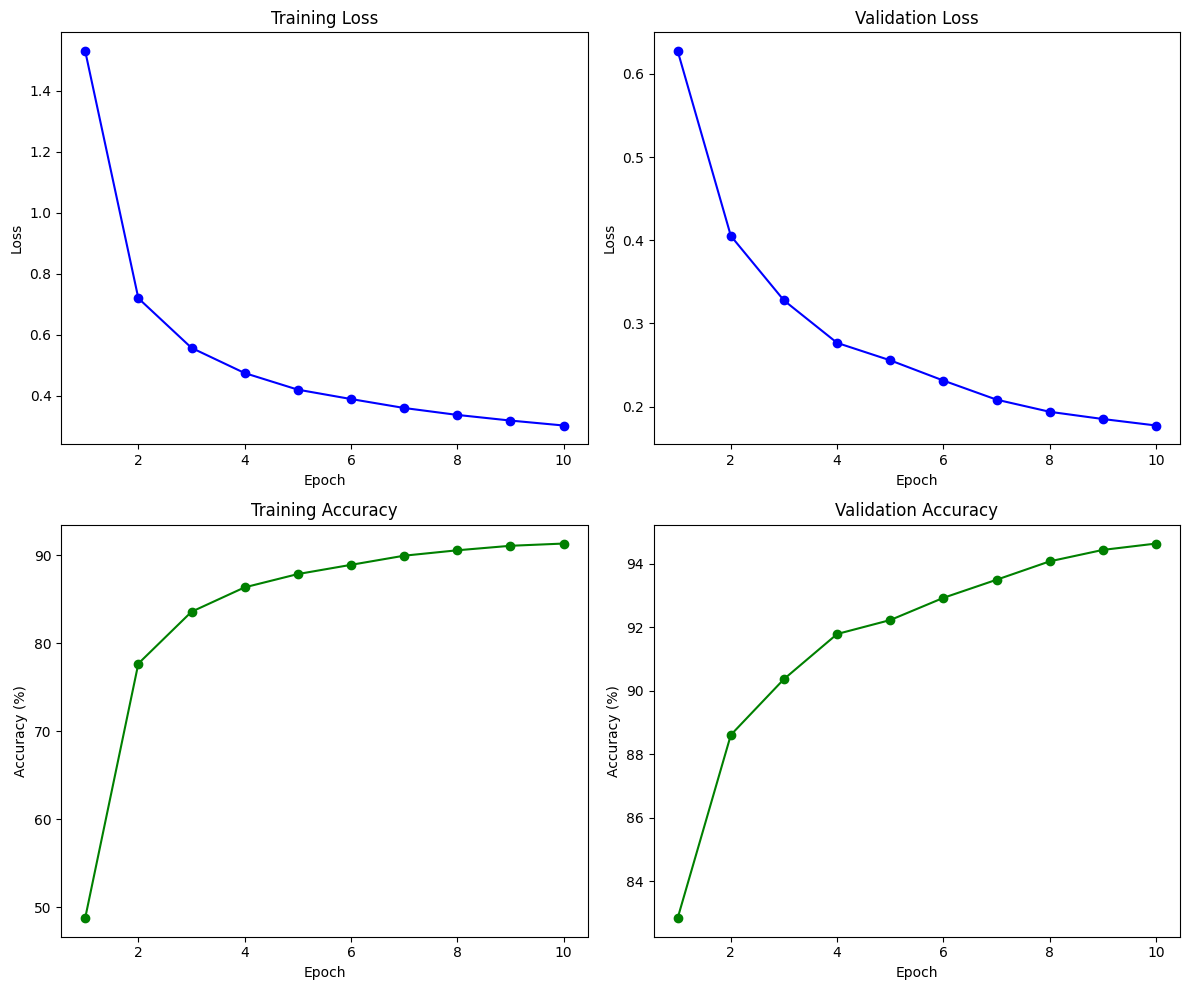

Epoch [1/10]
Training Loss: 1.9542, Accuracy: 35.74%
Validation Loss: 1.1266, Accuracy: 73.51%
Epoch [2/10]
Training Loss: 1.0702, Accuracy: 64.51%
Validation Loss: 0.6244, Accuracy: 84.08%
Epoch [3/10]
Training Loss: 0.7814, Accuracy: 75.51%
Validation Loss: 0.4693, Accuracy: 87.18%
Epoch [4/10]
Training Loss: 0.6487, Accuracy: 80.57%
Validation Loss: 0.3950, Accuracy: 89.09%
Epoch [5/10]
Training Loss: 0.5711, Accuracy: 83.15%
Validation Loss: 0.3507, Accuracy: 90.01%
Epoch [6/10]
Training Loss: 0.5146, Accuracy: 85.01%
Validation Loss: 0.3187, Accuracy: 90.94%
Epoch [7/10]
Training Loss: 0.4797, Accuracy: 86.17%
Validation Loss: 0.2991, Accuracy: 91.11%
Epoch [8/10]
Training Loss: 0.4494, Accuracy: 87.16%
Validation Loss: 0.2753, Accuracy: 92.07%
Epoch [9/10]
Training Loss: 0.4272, Accuracy: 87.94%
Validation Loss: 0.2606, Accuracy: 92.42%
Epoch [10/10]
Training Loss: 0.4006, Accuracy: 88.71%
Validation Loss: 0.2457, Accuracy: 92.80%


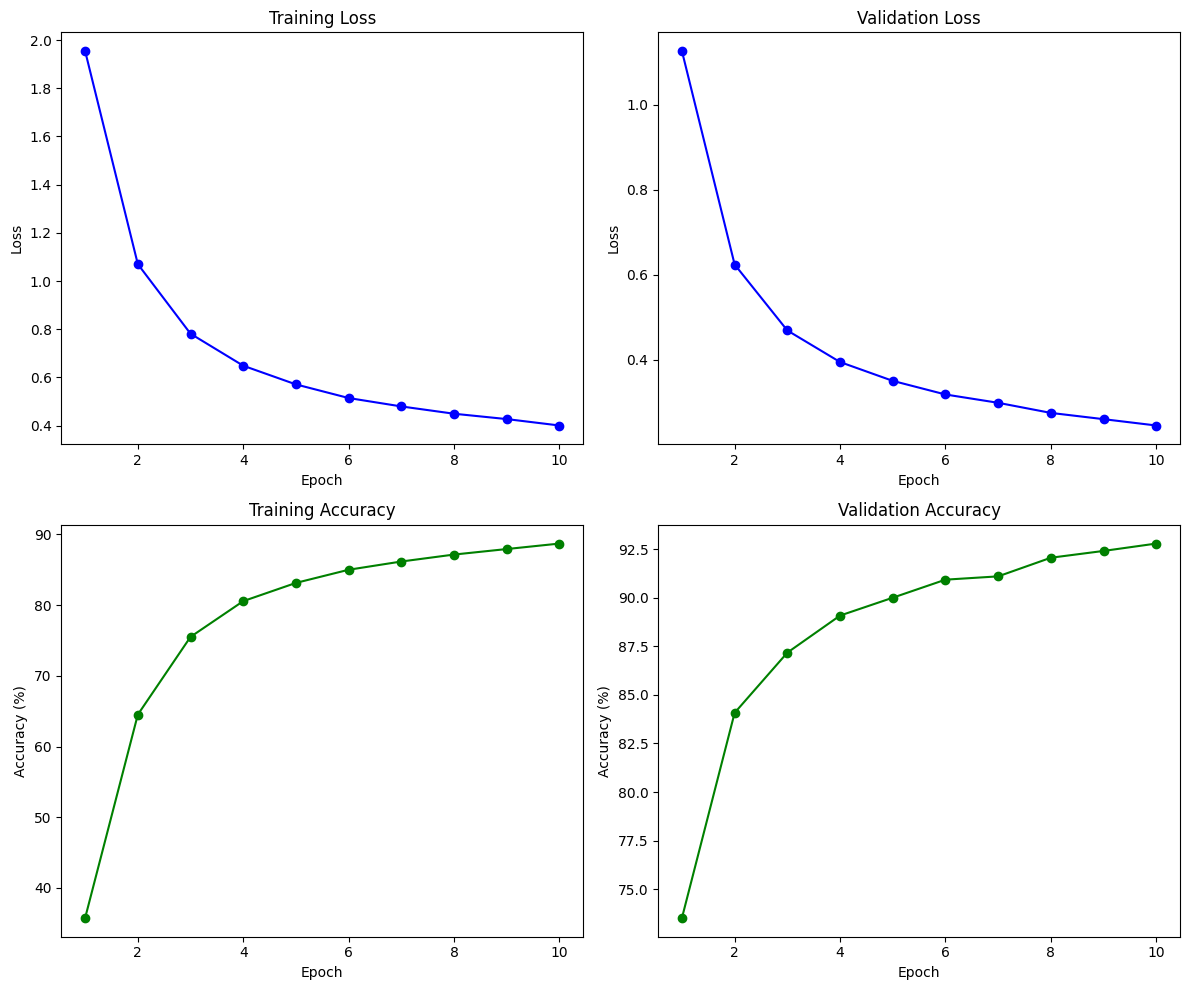

In [33]:
batch_sizes = [32, 64, 128, 256, 512]

train_accuracies_batch = []
val_accuracies_batch = []

for batch_size in batch_sizes:

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = FeedforwardNN()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    train_acc, val_acc = train(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)

    train_accuracies_batch.append(train_acc)
    val_accuracies_batch.append(val_acc)



### Conclusion

In [34]:
print(f"{'Batch Size':<15}{'Train Accuracy (%)':<20}{'Val Accuracy (%)':<20}")
print("-" * 55)

for batch_size, train_acc, val_acc in zip(batch_sizes, train_accuracies_batch, val_accuracies_batch):
    print(f"{batch_size:<15}{train_acc:<20.2f}{val_acc:<20.2f}")

Batch Size     Train Accuracy (%)  Val Accuracy (%)    
-------------------------------------------------------
32             94.19               96.58               
64             94.23               96.29               
128            93.44               96.16               
256            91.35               94.64               
512            88.71               92.80               


### 3. Change number of neurons and layers  
* Learning rate = 0.1
* Batch size = 64

In [38]:
train_accuracies_nl = []
val_accuracies_nl = []

In [40]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### a. Changing Neurons Only
* Three layers

### **Neurons - 64 and 32**

Epoch [1/10]
Training Loss: 0.5933, Accuracy: 82.66%
Validation Loss: 0.3950, Accuracy: 87.54%
Epoch [2/10]
Training Loss: 0.2412, Accuracy: 92.95%
Validation Loss: 0.2471, Accuracy: 92.78%
Epoch [3/10]
Training Loss: 0.1688, Accuracy: 95.08%
Validation Loss: 0.1587, Accuracy: 95.30%
Epoch [4/10]
Training Loss: 0.1312, Accuracy: 96.15%
Validation Loss: 0.1283, Accuracy: 96.27%
Epoch [5/10]
Training Loss: 0.1090, Accuracy: 96.86%
Validation Loss: 0.1174, Accuracy: 96.53%
Epoch [6/10]
Training Loss: 0.0905, Accuracy: 97.35%
Validation Loss: 0.1262, Accuracy: 96.17%
Epoch [7/10]
Training Loss: 0.0789, Accuracy: 97.60%
Validation Loss: 0.1191, Accuracy: 96.54%
Epoch [8/10]
Training Loss: 0.0695, Accuracy: 97.92%
Validation Loss: 0.1085, Accuracy: 96.67%
Epoch [9/10]
Training Loss: 0.0604, Accuracy: 98.21%
Validation Loss: 0.0957, Accuracy: 97.14%
Epoch [10/10]
Training Loss: 0.0540, Accuracy: 98.34%
Validation Loss: 0.1134, Accuracy: 96.74%


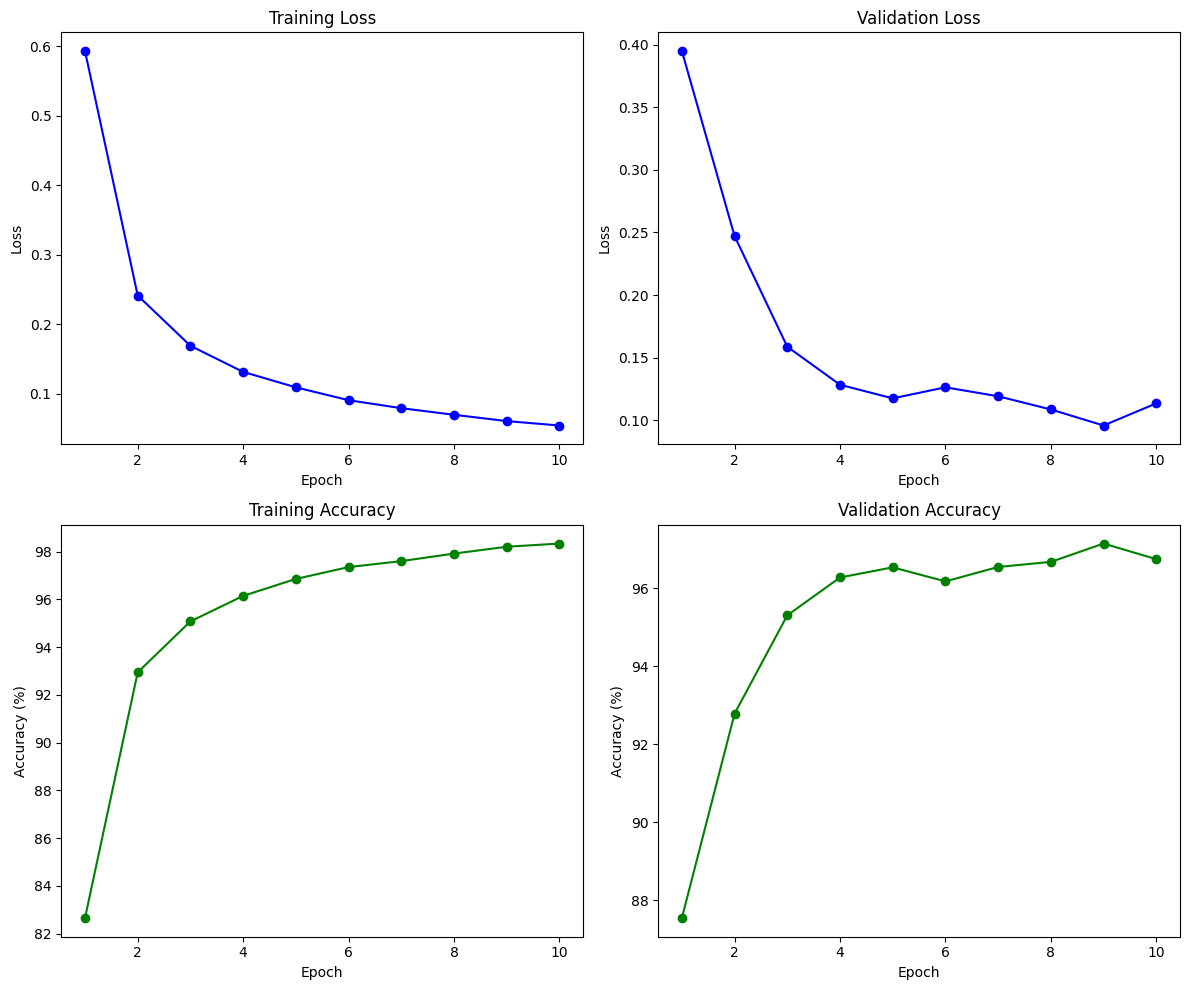

In [ ]:
class FeedforwardNN_1(nn.Module):
    def __init__(self):
        super(FeedforwardNN_1, self).__init__()

        self.l1 = nn.Linear(784, 64)
        self.l2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x

model_11 = FeedforwardNN_1()
loss_fn_11 = nn.CrossEntropyLoss()
optimizer_11 = optim.SGD(model_11.parameters(), lr=0.1)

train_acc11, val_acc11 = train(model_11, train_loader, val_loader, loss_fn_11, optimizer_11, 10)

train_accuracies_nl.append(train_acc11)
val_accuracies_nl.append(val_acc11)

### b. **Neurons - 512 and 256**



Epoch [1/10]
Training Loss: 0.5163, Accuracy: 85.83%
Validation Loss: 0.5112, Accuracy: 82.99%
Epoch [2/10]
Training Loss: 0.1940, Accuracy: 94.27%
Validation Loss: 0.2056, Accuracy: 93.66%
Epoch [3/10]
Training Loss: 0.1291, Accuracy: 96.17%
Validation Loss: 0.1554, Accuracy: 95.18%
Epoch [4/10]
Training Loss: 0.0974, Accuracy: 97.14%
Validation Loss: 0.1091, Accuracy: 96.76%
Epoch [5/10]
Training Loss: 0.0759, Accuracy: 97.82%
Validation Loss: 0.1278, Accuracy: 96.16%
Epoch [6/10]
Training Loss: 0.0610, Accuracy: 98.20%
Validation Loss: 0.0877, Accuracy: 97.43%
Epoch [7/10]
Training Loss: 0.0494, Accuracy: 98.62%
Validation Loss: 0.1213, Accuracy: 96.26%
Epoch [8/10]
Training Loss: 0.0407, Accuracy: 98.86%
Validation Loss: 0.0801, Accuracy: 97.71%
Epoch [9/10]
Training Loss: 0.0336, Accuracy: 99.02%
Validation Loss: 0.0991, Accuracy: 97.03%
Epoch [10/10]
Training Loss: 0.0266, Accuracy: 99.29%
Validation Loss: 0.1260, Accuracy: 96.16%


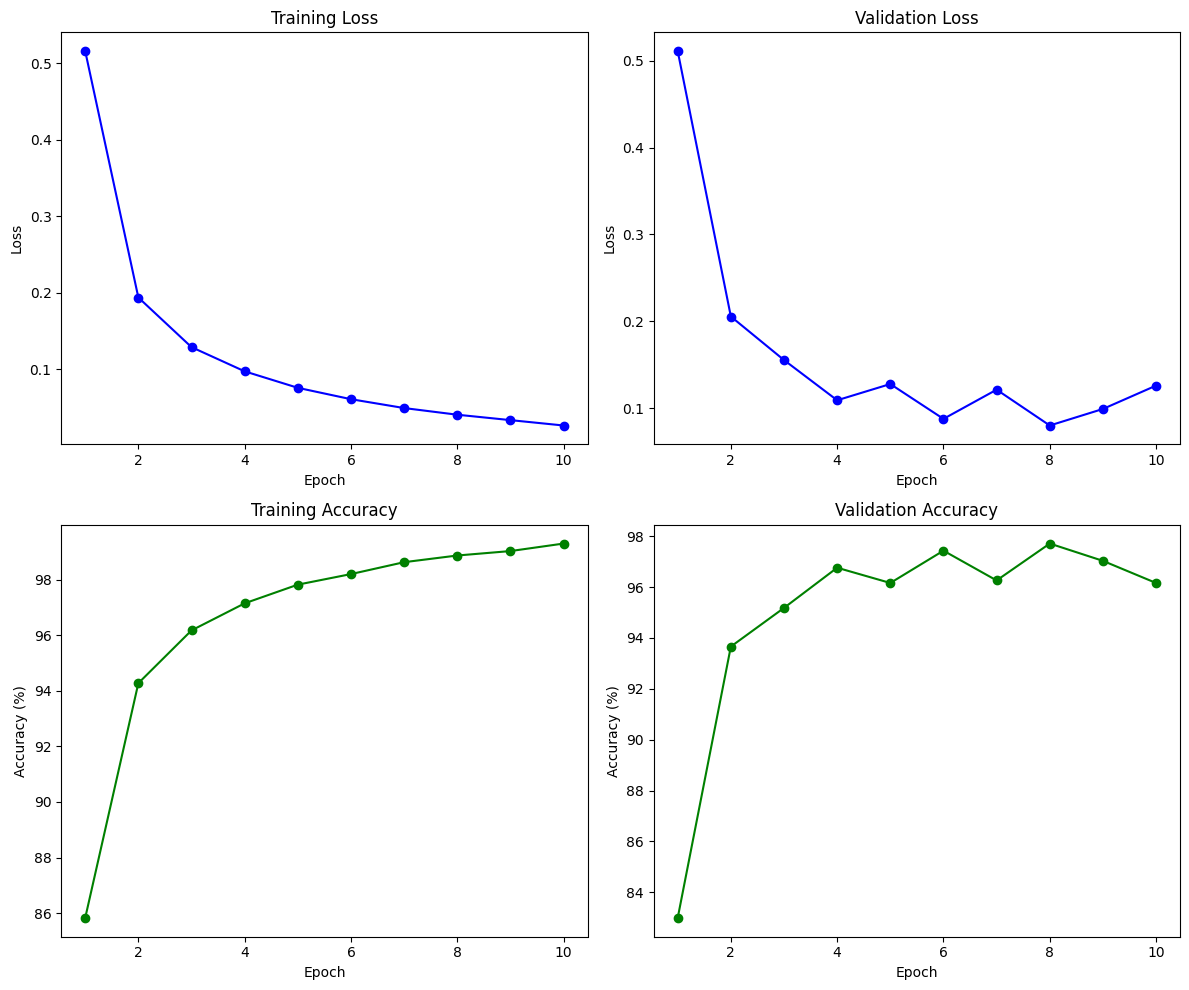

In [42]:
class FeedforwardNN_2(nn.Module):
    def __init__(self):
        super(FeedforwardNN_2, self).__init__()

        self.l1 = nn.Linear(784, 512)
        self.l2 = nn.Linear(512, 256)
        self.output = nn.Linear(256, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x

model_12 = FeedforwardNN_2()
loss_fn_12 = nn.CrossEntropyLoss()
optimizer_12 = optim.SGD(model_12.parameters(), lr=0.1)

train_acc12, val_acc12 = train(model_12, train_loader, val_loader, loss_fn_12, optimizer_12, 10)

train_accuracies_nl.append(train_acc12)
val_accuracies_nl.append(val_acc12)

  ### c. **Neurons - 128 and 128**

Epoch [1/10]
Training Loss: 0.5253, Accuracy: 85.52%
Validation Loss: 0.4221, Accuracy: 85.37%
Epoch [2/10]
Training Loss: 0.2104, Accuracy: 93.68%
Validation Loss: 0.1825, Accuracy: 94.53%
Epoch [3/10]
Training Loss: 0.1462, Accuracy: 95.69%
Validation Loss: 0.1370, Accuracy: 96.01%
Epoch [4/10]
Training Loss: 0.1136, Accuracy: 96.67%
Validation Loss: 0.1298, Accuracy: 96.00%
Epoch [5/10]
Training Loss: 0.0910, Accuracy: 97.21%
Validation Loss: 0.1184, Accuracy: 96.46%
Epoch [6/10]
Training Loss: 0.0763, Accuracy: 97.76%
Validation Loss: 0.1012, Accuracy: 97.13%
Epoch [7/10]
Training Loss: 0.0642, Accuracy: 98.09%
Validation Loss: 0.0936, Accuracy: 97.21%
Epoch [8/10]
Training Loss: 0.0539, Accuracy: 98.46%
Validation Loss: 0.0926, Accuracy: 97.30%
Epoch [9/10]
Training Loss: 0.0461, Accuracy: 98.61%
Validation Loss: 0.0886, Accuracy: 97.48%
Epoch [10/10]
Training Loss: 0.0401, Accuracy: 98.83%
Validation Loss: 0.0867, Accuracy: 97.61%


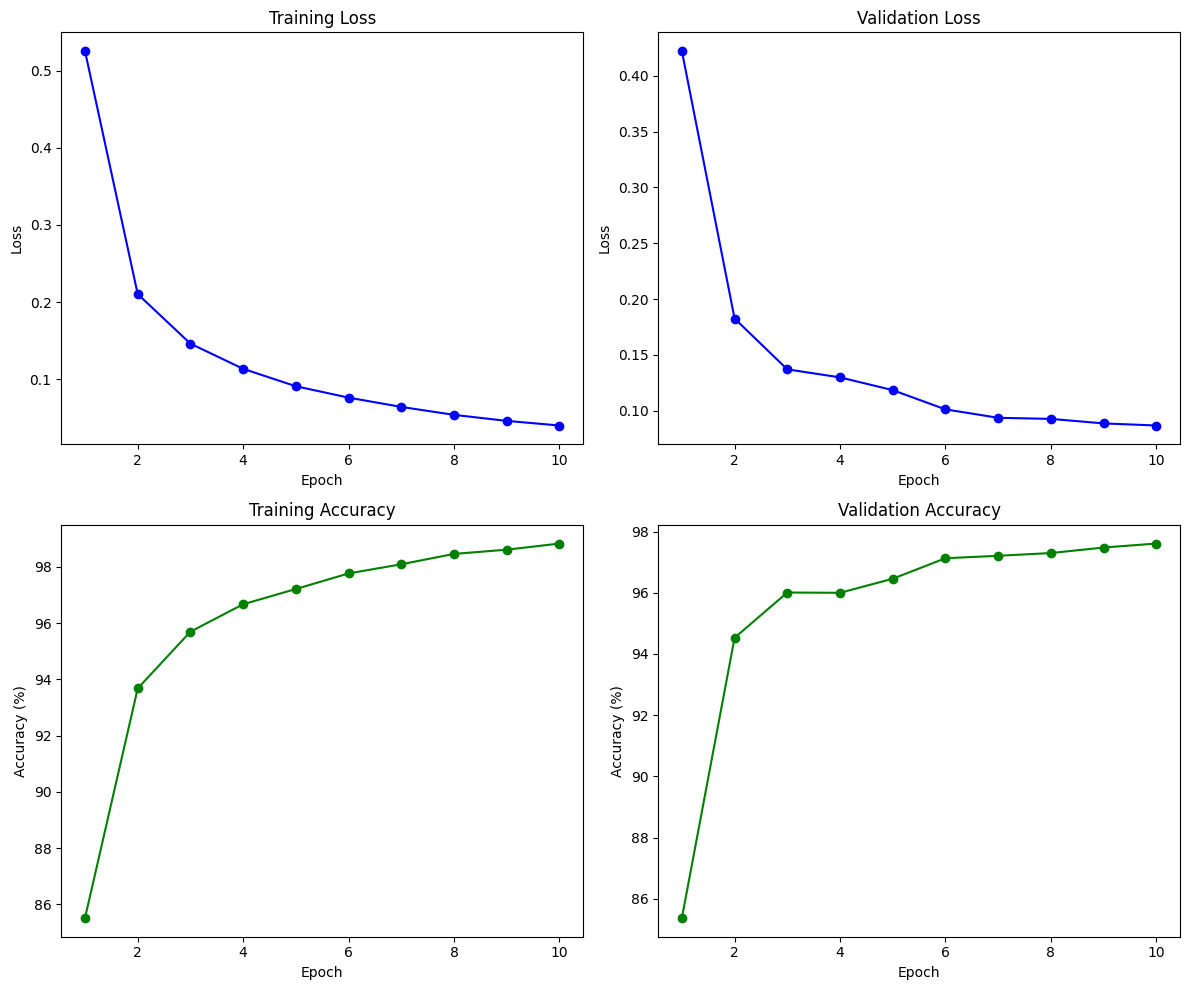

In [43]:
class FeedforwardNN_3(nn.Module):
    def __init__(self):
        super(FeedforwardNN_3, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_13 = FeedforwardNN_3()
loss_fn_13 = nn.CrossEntropyLoss()
optimizer_13 = optim.SGD(model_13.parameters(), lr=0.1)

train_acc13, val_acc13 = train(model_13, train_loader, val_loader, loss_fn_13, optimizer_13, 10)

train_accuracies_nl.append(train_acc13)
val_accuracies_nl.append(val_acc13)

### d. **Neurons - 256 and 128**

Epoch [1/10]
Training Loss: 0.5516, Accuracy: 83.56%
Validation Loss: 0.3139, Accuracy: 90.38%
Epoch [2/10]
Training Loss: 0.1990, Accuracy: 94.12%
Validation Loss: 0.2317, Accuracy: 92.73%
Epoch [3/10]
Training Loss: 0.1338, Accuracy: 96.02%
Validation Loss: 0.1381, Accuracy: 95.96%
Epoch [4/10]
Training Loss: 0.1023, Accuracy: 96.96%
Validation Loss: 0.1136, Accuracy: 96.64%
Epoch [5/10]
Training Loss: 0.0810, Accuracy: 97.57%
Validation Loss: 0.0961, Accuracy: 97.22%
Epoch [6/10]
Training Loss: 0.0654, Accuracy: 98.04%
Validation Loss: 0.1381, Accuracy: 95.57%
Epoch [7/10]
Training Loss: 0.0539, Accuracy: 98.40%
Validation Loss: 0.0895, Accuracy: 97.23%
Epoch [8/10]
Training Loss: 0.0455, Accuracy: 98.68%
Validation Loss: 0.5328, Accuracy: 85.32%
Epoch [9/10]
Training Loss: 0.0382, Accuracy: 98.88%
Validation Loss: 0.0825, Accuracy: 97.53%
Epoch [10/10]
Training Loss: 0.0321, Accuracy: 99.07%
Validation Loss: 0.0838, Accuracy: 97.58%


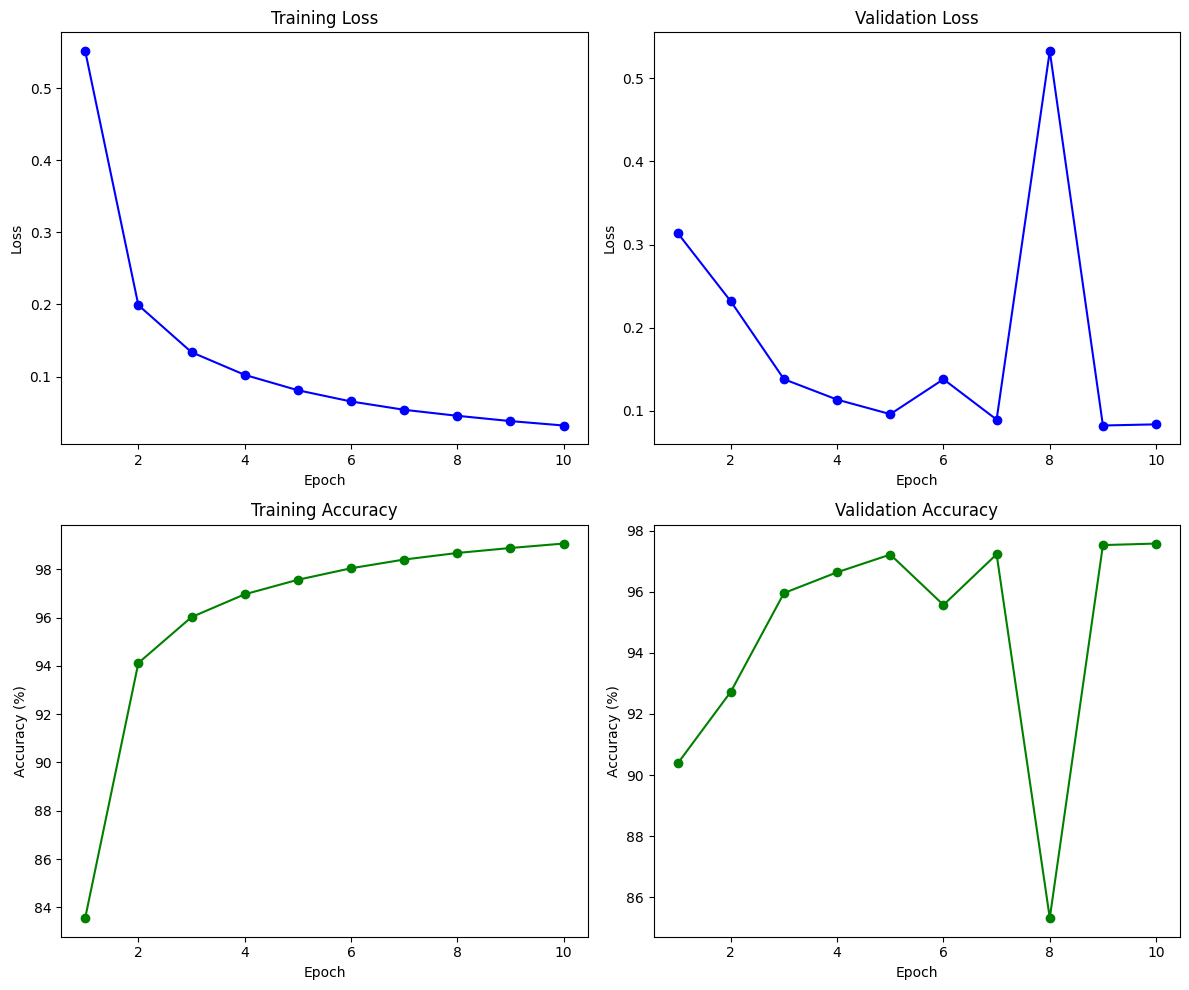

In [45]:
class FeedforwardNN_4(nn.Module):
    def __init__(self):
        super(FeedforwardNN_4, self).__init__()

        self.l1 = nn.Linear(784, 256)
        self.l2 = nn.Linear(256, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_14 = FeedforwardNN_4()
loss_fn_14 = nn.CrossEntropyLoss()
optimizer_14 = optim.SGD(model_14.parameters(), lr=0.1)

train_acc14, val_acc14 = train(model_14, train_loader, val_loader, loss_fn_14, optimizer_14, 10)

train_accuracies_nl.append(train_acc14)
val_accuracies_nl.append(val_acc14)

### Conclusion

In [48]:
print(f"Train Accuracy {train_accuracies_nl} ")
print(f"Validation Accuracy {val_accuracies_nl} ")

Train Accuracy [98.34, 99.294, 98.826, 99.118, 99.066] 
Validation Accuracy [96.74, 96.16, 97.61, 95.65, 97.58] 


### 4. Changing Layers Only
* Number of neurons per layer remains constant = 128 neurons

In [50]:
train_accuracies_layers = []
val_accuracies_layers = []

### a. **2 Layers**

Epoch [1/10]
Training Loss: 0.4783, Accuracy: 87.21%
Validation Loss: 0.2934, Accuracy: 91.56%
Epoch [2/10]
Training Loss: 0.2469, Accuracy: 92.94%
Validation Loss: 0.2772, Accuracy: 91.48%
Epoch [3/10]
Training Loss: 0.1894, Accuracy: 94.53%
Validation Loss: 0.1808, Accuracy: 94.86%
Epoch [4/10]
Training Loss: 0.1537, Accuracy: 95.59%
Validation Loss: 0.1665, Accuracy: 95.42%
Epoch [5/10]
Training Loss: 0.1288, Accuracy: 96.28%
Validation Loss: 0.1401, Accuracy: 96.00%
Epoch [6/10]
Training Loss: 0.1105, Accuracy: 96.88%
Validation Loss: 0.1327, Accuracy: 96.02%
Epoch [7/10]
Training Loss: 0.0970, Accuracy: 97.27%
Validation Loss: 0.1221, Accuracy: 96.39%
Epoch [8/10]
Training Loss: 0.0860, Accuracy: 97.52%
Validation Loss: 0.1105, Accuracy: 96.88%
Epoch [9/10]
Training Loss: 0.0766, Accuracy: 97.81%
Validation Loss: 0.1048, Accuracy: 96.93%
Epoch [10/10]
Training Loss: 0.0695, Accuracy: 97.99%
Validation Loss: 0.0996, Accuracy: 97.08%


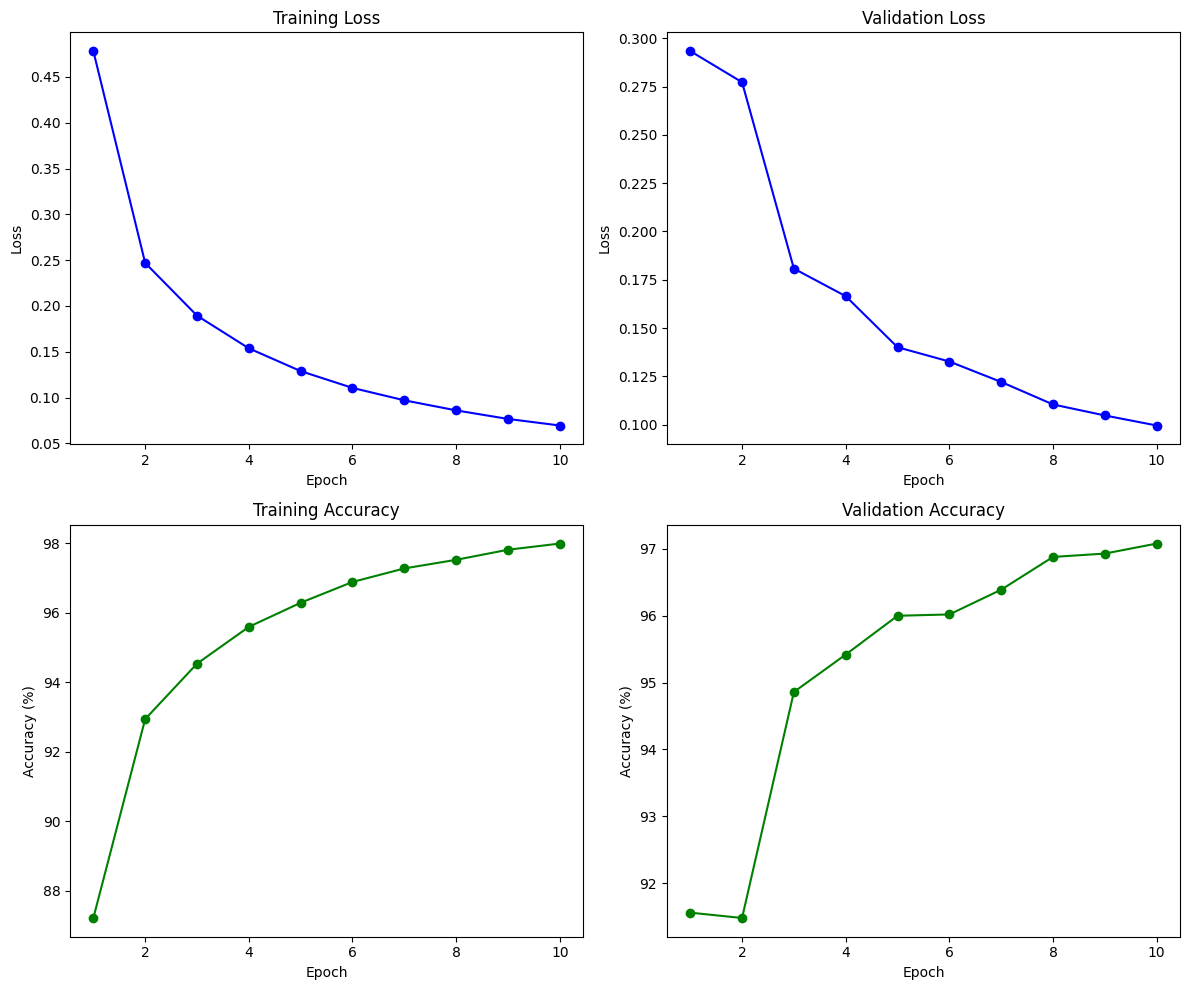

In [51]:
class FeedforwardNN_5(nn.Module):
    def __init__(self):
        super(FeedforwardNN_5, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.output = nn.Linear(128, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.output(x)
        return x


model_15 = FeedforwardNN_5()
loss_fn_15 = nn.CrossEntropyLoss()
optimizer_15 = optim.SGD(model_15.parameters(), lr=0.1)

train_acc15, val_acc15 = train(model_15, train_loader, val_loader, loss_fn_15, optimizer_15, 10)

train_accuracies_layers.append(train_acc15)
val_accuracies_layers.append(val_acc15)

### b. **3 Layers**

Epoch [1/10]
Training Loss: 0.5603, Accuracy: 83.57%
Validation Loss: 0.6193, Accuracy: 79.21%
Epoch [2/10]
Training Loss: 0.2066, Accuracy: 93.86%
Validation Loss: 0.1896, Accuracy: 94.13%
Epoch [3/10]
Training Loss: 0.1386, Accuracy: 95.91%
Validation Loss: 0.1370, Accuracy: 95.93%
Epoch [4/10]
Training Loss: 0.1075, Accuracy: 96.82%
Validation Loss: 0.1258, Accuracy: 96.22%
Epoch [5/10]
Training Loss: 0.0872, Accuracy: 97.43%
Validation Loss: 0.1224, Accuracy: 96.22%
Epoch [6/10]
Training Loss: 0.0716, Accuracy: 97.86%
Validation Loss: 0.0990, Accuracy: 97.00%
Epoch [7/10]
Training Loss: 0.0601, Accuracy: 98.19%
Validation Loss: 0.1720, Accuracy: 94.83%
Epoch [8/10]
Training Loss: 0.0516, Accuracy: 98.49%
Validation Loss: 0.0913, Accuracy: 97.24%
Epoch [9/10]
Training Loss: 0.0448, Accuracy: 98.69%
Validation Loss: 0.0979, Accuracy: 97.21%
Epoch [10/10]
Training Loss: 0.0378, Accuracy: 98.89%
Validation Loss: 0.0886, Accuracy: 97.44%


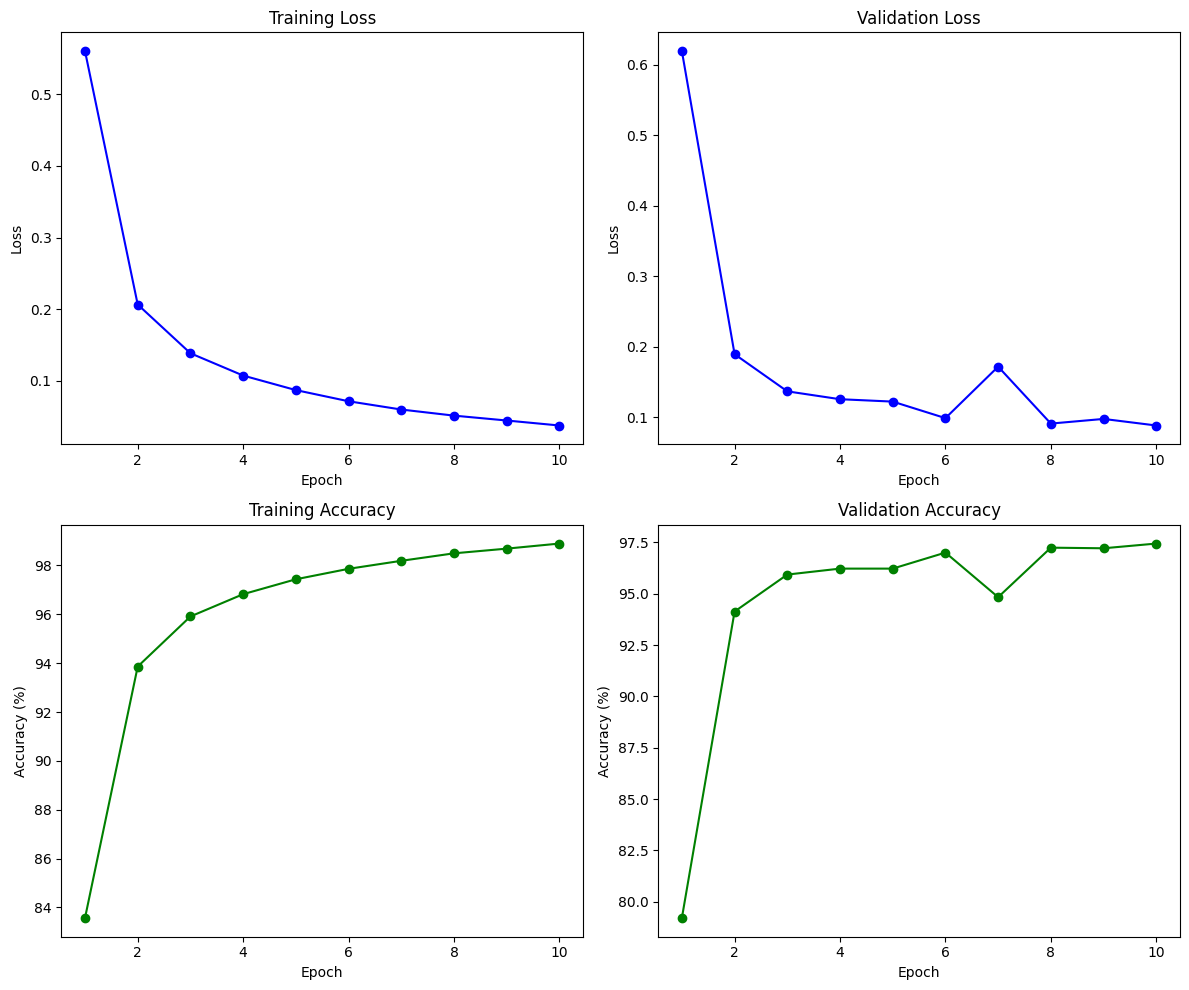

In [52]:
class FeedforwardNN_6(nn.Module):
    def __init__(self):
        super(FeedforwardNN_6, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.output(x)
        return x


model_16 = FeedforwardNN_6()
loss_fn_16 = nn.CrossEntropyLoss()
optimizer_16 = optim.SGD(model_16.parameters(), lr=0.1)

train_acc16, val_acc16 = train(model_16, train_loader, val_loader, loss_fn_16, optimizer_16, 10)

train_accuracies_layers.append(train_acc16)
val_accuracies_layers.append(val_acc16)

### c. **4 Layers**

Epoch [1/10]
Training Loss: 0.7675, Accuracy: 74.90%
Validation Loss: 0.4935, Accuracy: 84.34%
Epoch [2/10]
Training Loss: 0.1963, Accuracy: 94.20%
Validation Loss: 0.3456, Accuracy: 88.87%
Epoch [3/10]
Training Loss: 0.1315, Accuracy: 96.02%
Validation Loss: 0.1216, Accuracy: 96.39%
Epoch [4/10]
Training Loss: 0.0961, Accuracy: 97.16%
Validation Loss: 0.1169, Accuracy: 96.44%
Epoch [5/10]
Training Loss: 0.0795, Accuracy: 97.52%
Validation Loss: 0.1082, Accuracy: 96.70%
Epoch [6/10]
Training Loss: 0.0625, Accuracy: 98.11%
Validation Loss: 0.1915, Accuracy: 94.65%
Epoch [7/10]
Training Loss: 0.0531, Accuracy: 98.39%
Validation Loss: 0.1104, Accuracy: 96.76%
Epoch [8/10]
Training Loss: 0.0458, Accuracy: 98.61%
Validation Loss: 0.1587, Accuracy: 95.47%
Epoch [9/10]
Training Loss: 0.0381, Accuracy: 98.83%
Validation Loss: 0.1073, Accuracy: 97.13%
Epoch [10/10]
Training Loss: 0.0302, Accuracy: 99.09%
Validation Loss: 0.0907, Accuracy: 97.56%


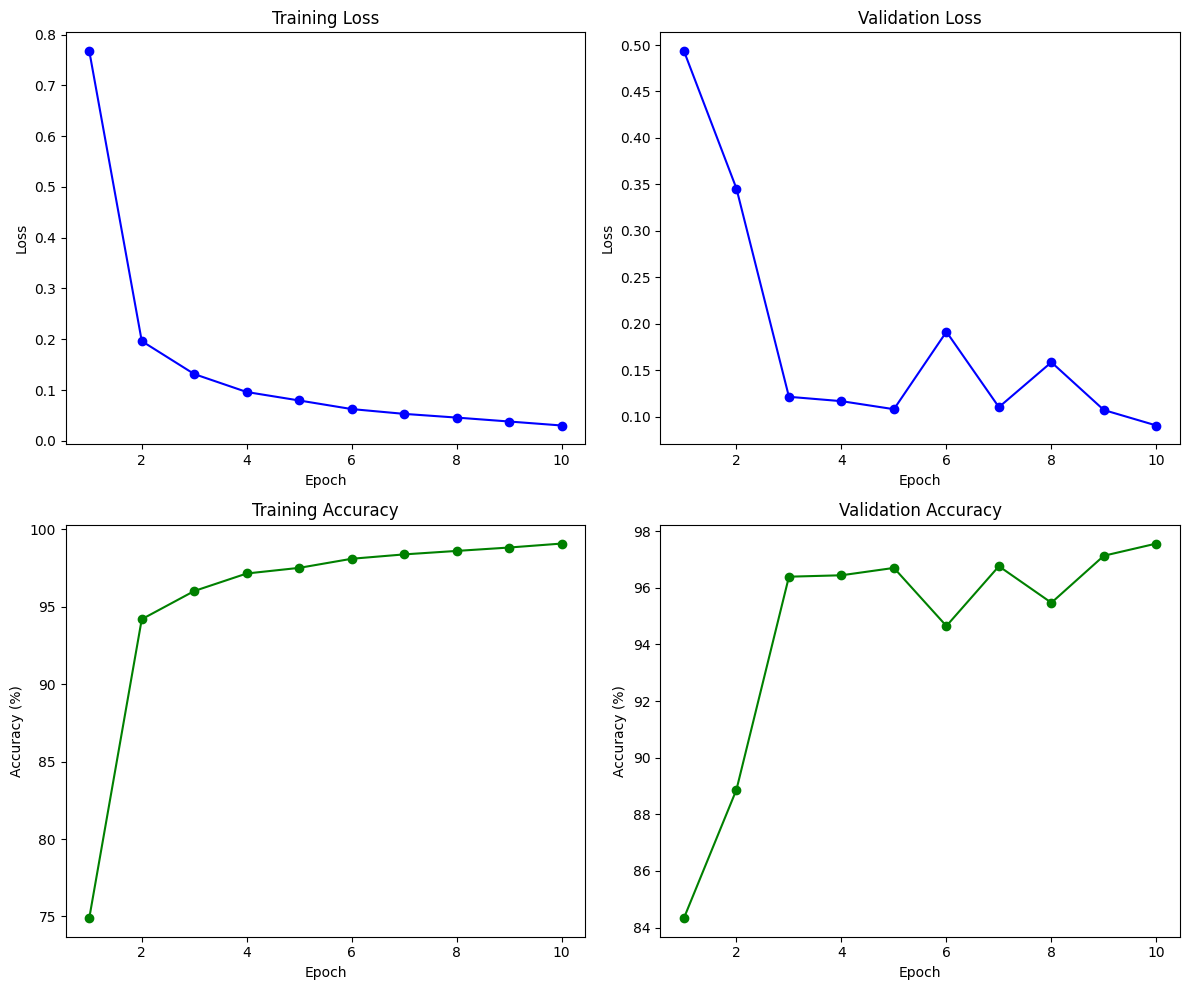

In [53]:
class FeedforwardNN_7(nn.Module):
    def __init__(self):
        super(FeedforwardNN_7, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.output = nn.Linear(32, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.output(x)
        return x


model_17 = FeedforwardNN_7()
loss_fn_17 = nn.CrossEntropyLoss()
optimizer_17 = optim.SGD(model_17.parameters(), lr=0.1)

train_acc17, val_acc17 = train(model_17, train_loader, val_loader, loss_fn_17, optimizer_17, 10)

train_accuracies_layers.append(train_acc17)
val_accuracies_layers.append(val_acc17)

### d. **5 Layers**

Epoch [1/10]
Training Loss: 1.1384, Accuracy: 60.79%
Validation Loss: 0.7631, Accuracy: 76.54%
Epoch [2/10]
Training Loss: 0.2191, Accuracy: 93.58%
Validation Loss: 0.1931, Accuracy: 94.41%
Epoch [3/10]
Training Loss: 0.1329, Accuracy: 96.03%
Validation Loss: 0.1345, Accuracy: 96.13%
Epoch [4/10]
Training Loss: 0.0963, Accuracy: 97.07%
Validation Loss: 0.1267, Accuracy: 96.45%
Epoch [5/10]
Training Loss: 0.0753, Accuracy: 97.73%
Validation Loss: 0.2254, Accuracy: 93.44%
Epoch [6/10]
Training Loss: 0.0633, Accuracy: 98.02%
Validation Loss: 0.2785, Accuracy: 92.26%
Epoch [7/10]
Training Loss: 0.0527, Accuracy: 98.39%
Validation Loss: 0.1212, Accuracy: 96.68%
Epoch [8/10]
Training Loss: 0.0432, Accuracy: 98.67%
Validation Loss: 0.0993, Accuracy: 97.18%
Epoch [9/10]
Training Loss: 0.0367, Accuracy: 98.83%
Validation Loss: 0.1236, Accuracy: 96.47%
Epoch [10/10]
Training Loss: 0.0314, Accuracy: 99.00%
Validation Loss: 0.1092, Accuracy: 97.28%


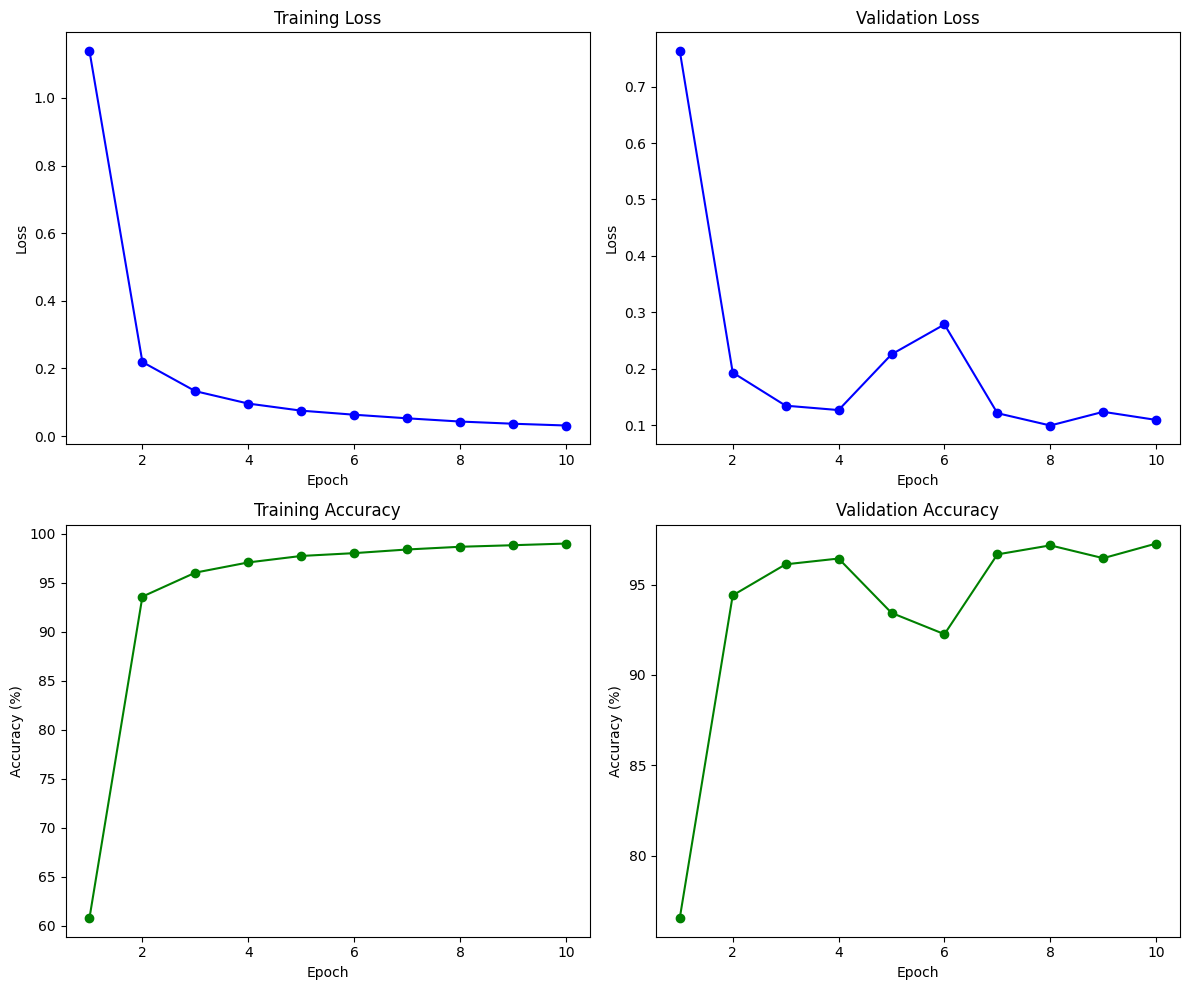

In [54]:
class FeedforwardNN_8(nn.Module):
    def __init__(self):
        super(FeedforwardNN_8, self).__init__()

        self.l1 = nn.Linear(784, 128)
        self.l2 = nn.Linear(128, 64)
        self.l3 = nn.Linear(64, 32)
        self.l4 = nn.Linear(32, 16)
        self.output = nn.Linear(16, 10)

        self.activation_fn = nn.ReLU()

    def forward(self, x):
        x = self.activation_fn(self.l1(x))
        x = self.activation_fn(self.l2(x))
        x = self.activation_fn(self.l3(x))
        x = self.activation_fn(self.l4(x))
        x = self.output(x)
        return x


model_18 = FeedforwardNN_8()
loss_fn_18 = nn.CrossEntropyLoss()
optimizer_18 = optim.SGD(model_18.parameters(), lr=0.1)

train_acc18, val_acc18 = train(model_18, train_loader, val_loader, loss_fn_18, optimizer_18, 10)

train_accuracies_layers.append(train_acc18)
val_accuracies_layers.append(val_acc18)


### Conclusion

In [55]:
print(f"Train Accuracy {train_accuracies_layers} ")
print(f"Validation Accuracy {val_accuracies_layers} ")

Train Accuracy [97.988, 98.894, 99.09, 98.996] 
Validation Accuracy [97.08, 97.44, 97.56, 97.28] 


## ***Conclusion***
### **Best model on training and validation sets** : 4-layered model

Test Accuracy: 97.50%


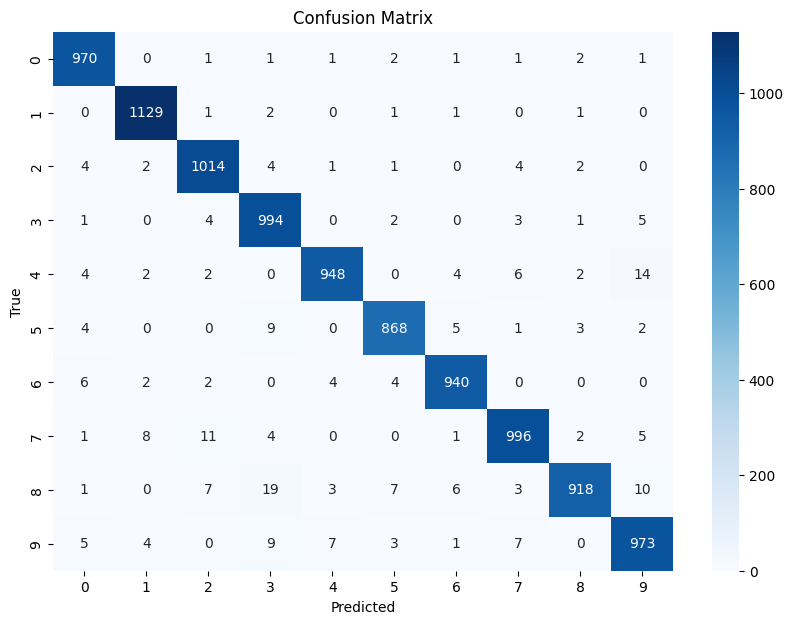

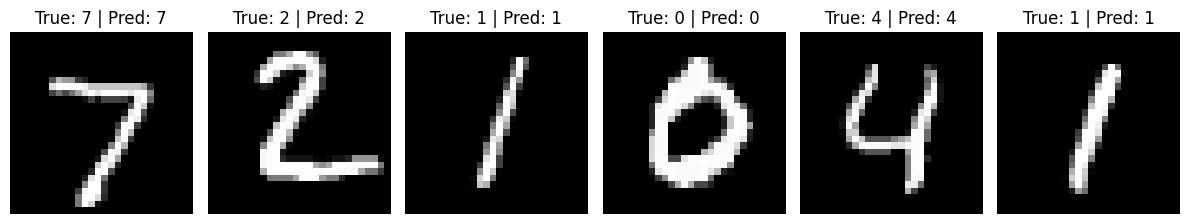

In [63]:
test(model_17, test_loader)

--------------------------------------

# ***BONUS PART | CNN***

### **Preprocessing Data for CNN**

In [7]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).view(-1, 1, 28, 28)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).view(-1, 1, 28, 28)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).view(-1, 1, 28, 28)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


### **Convolutional Network Design**
- **Input**: A 28x28 grayscale image.
- **Conv1**: 32 filters of size 3x3 with padding, followed by ReLU and Max Pooling.
- **Conv2**: 64 filters of size 3x3 with padding, followed by ReLU and Max Pooling.
- **Fully Connected Layers**: 128 neurons in the first fully connected layer, followed by 64 neurons in the second.
- **Output**: 10 neurons for classification.
- **Activation Functions**: ReLU in hidden layers and softmax in the output layer (via `CrossEntropyLoss`).

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layers with Batch Normalization
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # Convolutional layer 1
        self.bn1 = nn.BatchNorm2d(32)  # Batch normalization after first convolution
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # Convolutional layer 2
        self.bn2 = nn.BatchNorm2d(64)  # Batch normalization after second convolution

        # Max Pooling Layer
        self.pool = nn.MaxPool2d(2, 2) 

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # After pooling, feature size is reduced to 7x7
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # Output layer with 10 classes

        # Dropout 
        self.dropout = nn.Dropout(0.5)  

        # Activation Function
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        # Apply first convolution + BatchNorm + ReLU + MaxPool
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))

        # Apply second convolution + BatchNorm + ReLU + MaxPool
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))

        # Flatten the output for fully connected layers
        x = x.view(-1, 64 * 7 * 7)

        # Fully Connected Layers with Dropout and ReLU activation
        x = self.dropout(self.activation_fn(self.fc1(x)))  
        x = self.dropout(self.activation_fn(self.fc2(x)))  
        x = self.fc3(x) 

        return x


- Loss function: Cross-Entropy Loss
- Optimization technique: Stochastic Gradient Descent (SGD)
- Learning Rate: 0.01

In [43]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.01)

### **Training the CNN model**

In [9]:
def train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs):
   
    train_losses = []
    train_accuracies = []

    val_losses = []
    val_accuracies = []

    
    for epoch in range(epochs):

        
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()  
            outputs = model(inputs)

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():  
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        
        print(f'Epoch [{epoch+1}/{epochs}]')
        print(f'Training Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

    
    plt.figure(figsize=(12, 10))

    
    plt.subplot(2, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses, marker='o', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    
    plt.subplot(2, 2, 2)
    plt.plot(range(1, epochs + 1), val_losses, marker='o', color='blue')
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

   
    plt.subplot(2, 2, 3)
    plt.plot(range(1, epochs + 1), train_accuracies, marker='o', color='green')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epochs + 1), val_accuracies, marker='o', color='green')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()


Epoch [1/10]
Training Loss: 0.6081, Accuracy: 81.02%
Validation Loss: 0.1045, Accuracy: 97.01%
Epoch [2/10]
Training Loss: 0.1910, Accuracy: 94.81%
Validation Loss: 0.0716, Accuracy: 97.87%
Epoch [3/10]
Training Loss: 0.1389, Accuracy: 96.29%
Validation Loss: 0.0696, Accuracy: 97.89%
Epoch [4/10]
Training Loss: 0.1149, Accuracy: 97.00%
Validation Loss: 0.0531, Accuracy: 98.43%
Epoch [5/10]
Training Loss: 0.1011, Accuracy: 97.31%
Validation Loss: 0.0550, Accuracy: 98.28%
Epoch [6/10]
Training Loss: 0.0878, Accuracy: 97.73%
Validation Loss: 0.0495, Accuracy: 98.69%
Epoch [7/10]
Training Loss: 0.0816, Accuracy: 97.82%
Validation Loss: 0.0495, Accuracy: 98.65%
Epoch [8/10]
Training Loss: 0.0711, Accuracy: 98.04%
Validation Loss: 0.0422, Accuracy: 98.98%
Epoch [9/10]
Training Loss: 0.0715, Accuracy: 98.13%
Validation Loss: 0.0520, Accuracy: 98.63%
Epoch [10/10]
Training Loss: 0.0620, Accuracy: 98.32%
Validation Loss: 0.0419, Accuracy: 98.98%


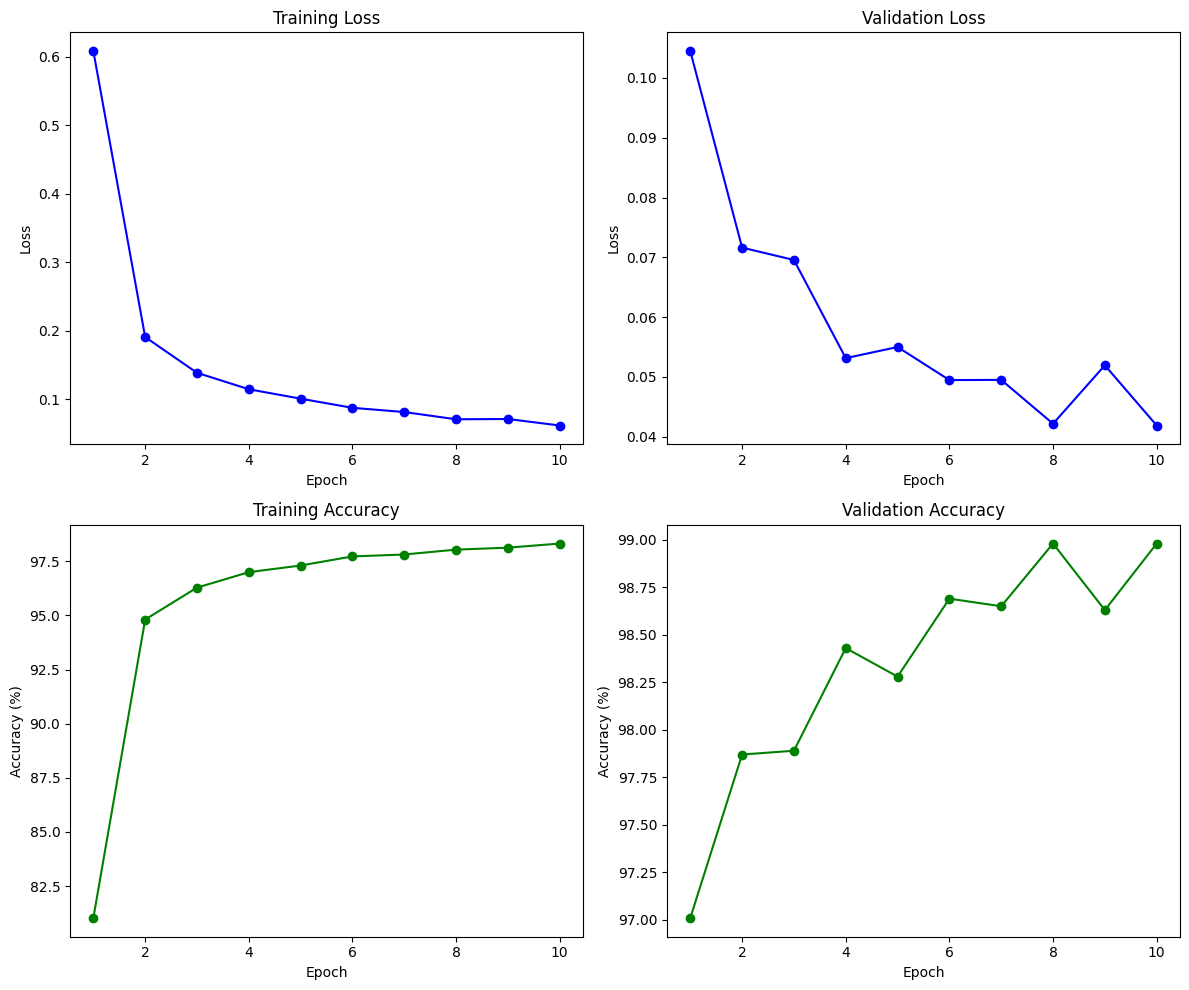

In [45]:
train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

### **Testing the CNN Model**

In [10]:
def test_cnn(model, test_loader):
    model.eval()  
    correct = 0
    total = 0

    
    all_preds = []
    all_labels = []

    with torch.no_grad():  
        for inputs, labels in test_loader:
            
            
            outputs = model(inputs)

            
            _, predicted = torch.max(outputs, dim=1)

            # Update accuracy metrics
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Store predictions and true labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    
    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

   
    cm = confusion_matrix(all_labels, all_preds)

    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    ################################

    
    sample_indices = [0, 1, 2, 3, 4, 5]  

    num_samples = len(sample_indices)
    plt.figure(figsize=(12, 3 * num_samples))

    for i, index in enumerate(sample_indices):
        sample_image = X_test[index]  # Assuming X_test is the test set images
        true_label = y_test[index]  # Assuming y_test is the true labels of the test set

        # Prepare the sample image for the CNN (reshape to [1, 1, 28, 28] for grayscale image)
        sample_image = torch.tensor(sample_image).float().view(1, 1, 28, 28)

        with torch.no_grad():
            output = model(sample_image)  # Get the output from the model
            _, predicted_label = torch.max(output, 1)  # Get predicted label

        # Plot the image
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(sample_image.squeeze(), cmap='gray')  
        plt.title(f"True: {true_label} | Pred: {predicted_label.item()}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Test Accuracy: 99.10%


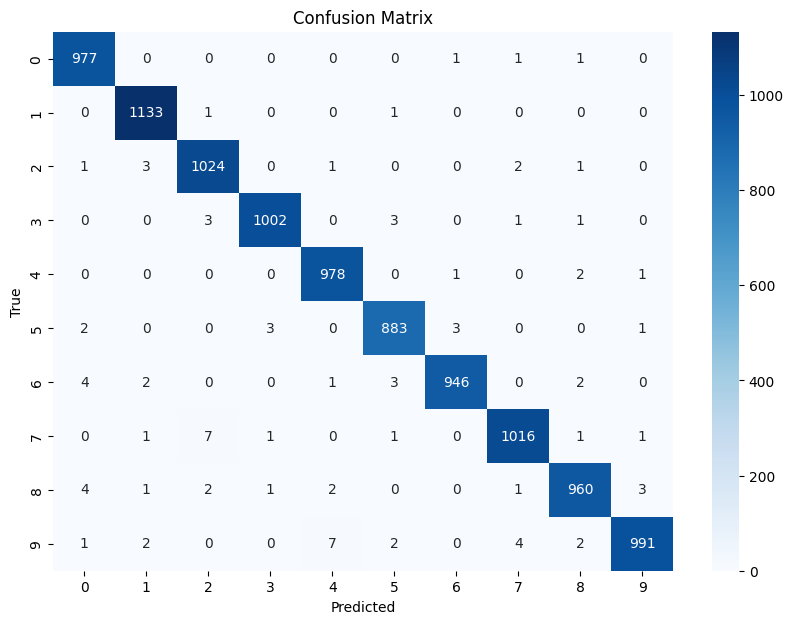

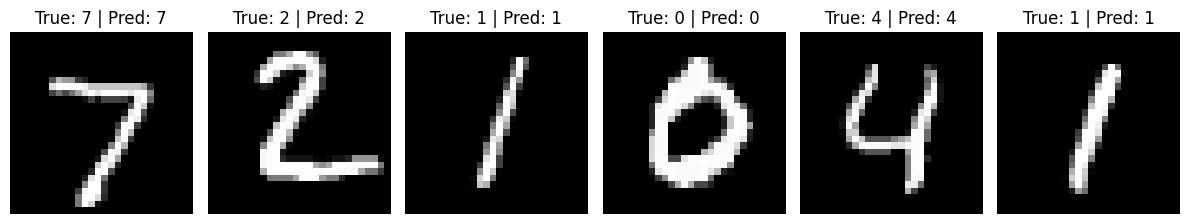

In [47]:
test_cnn(modelCNN, test_loader)

### **Analysis**
# Change Learning Rate [ 0.1,0.05, 0.001, 0.0001]
* Learning Rate=0.1
* Batch size = 32


Epoch [1/10]
Training Loss: 0.4654, Accuracy: 85.63%
Validation Loss: 0.0989, Accuracy: 97.31%
Epoch [2/10]
Training Loss: 0.1873, Accuracy: 94.84%
Validation Loss: 0.0774, Accuracy: 98.08%
Epoch [3/10]
Training Loss: 0.1320, Accuracy: 96.52%
Validation Loss: 0.0618, Accuracy: 98.35%
Epoch [4/10]
Training Loss: 0.1067, Accuracy: 97.22%
Validation Loss: 0.0677, Accuracy: 98.32%
Epoch [5/10]
Training Loss: 0.0943, Accuracy: 97.52%
Validation Loss: 0.0527, Accuracy: 98.78%
Epoch [6/10]
Training Loss: 0.0787, Accuracy: 97.87%
Validation Loss: 0.0468, Accuracy: 98.80%
Epoch [7/10]
Training Loss: 0.0725, Accuracy: 98.13%
Validation Loss: 0.0520, Accuracy: 98.85%
Epoch [8/10]
Training Loss: 0.0617, Accuracy: 98.39%
Validation Loss: 0.0513, Accuracy: 98.82%
Epoch [9/10]
Training Loss: 0.0525, Accuracy: 98.61%
Validation Loss: 0.0492, Accuracy: 98.96%
Epoch [10/10]
Training Loss: 0.0521, Accuracy: 98.60%
Validation Loss: 0.0458, Accuracy: 98.97%


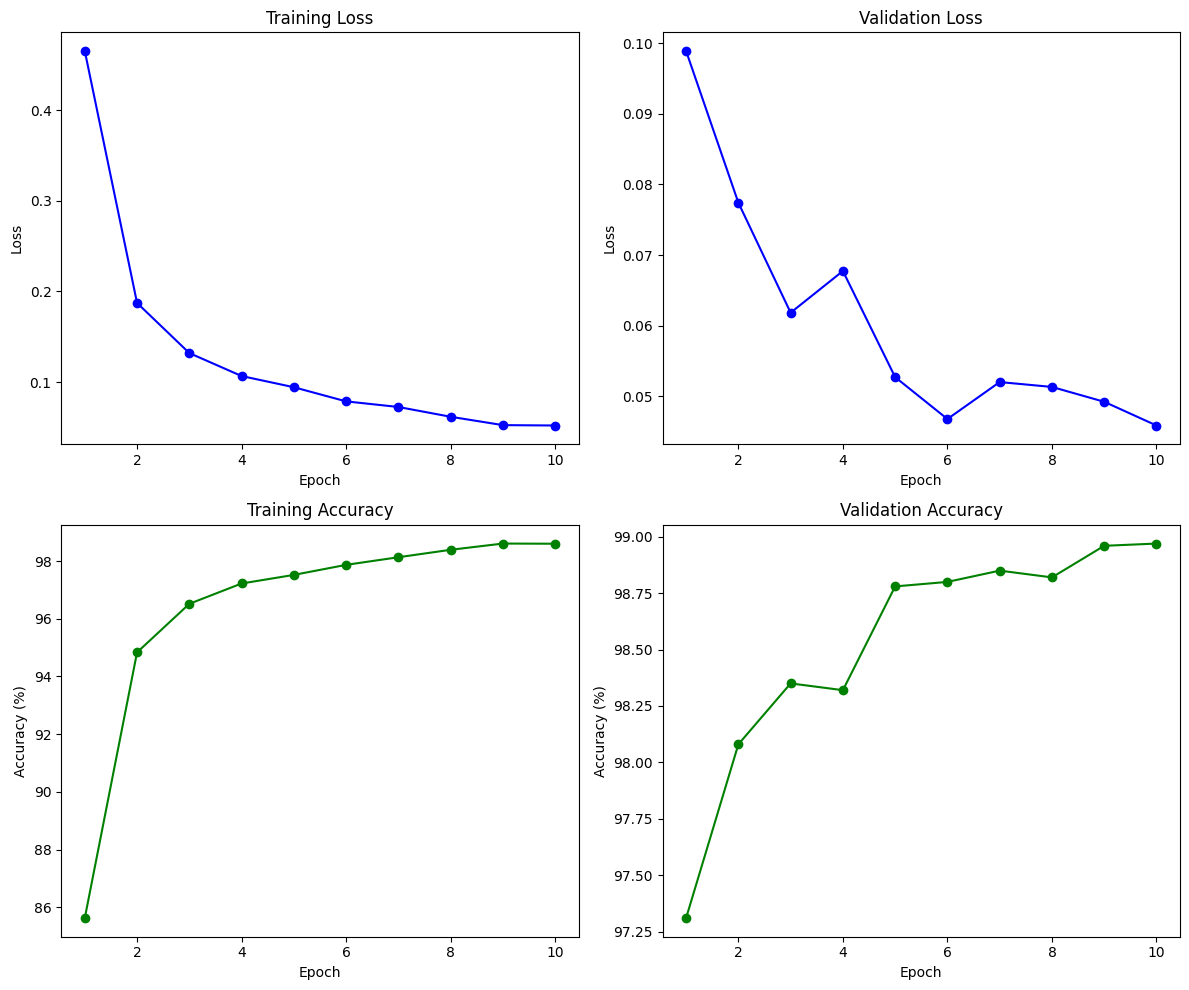

In [48]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.1)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 99.28%


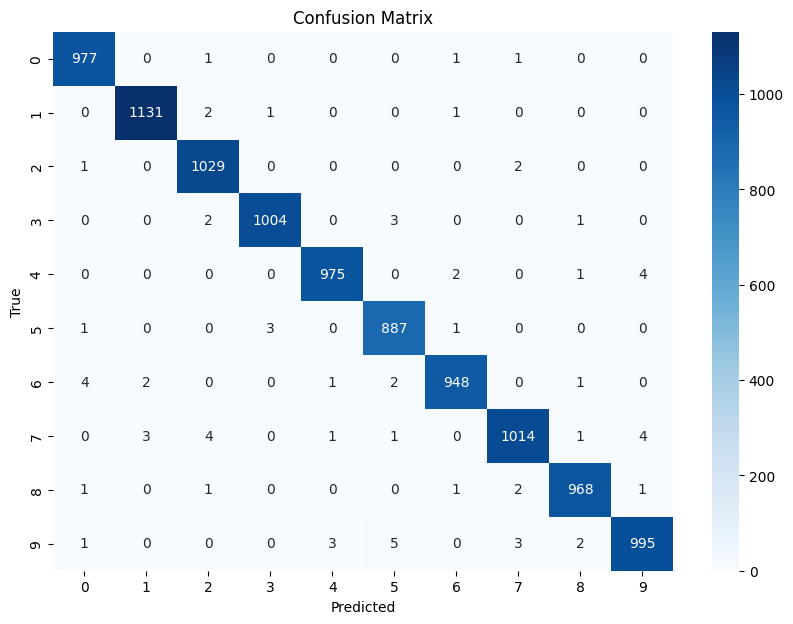

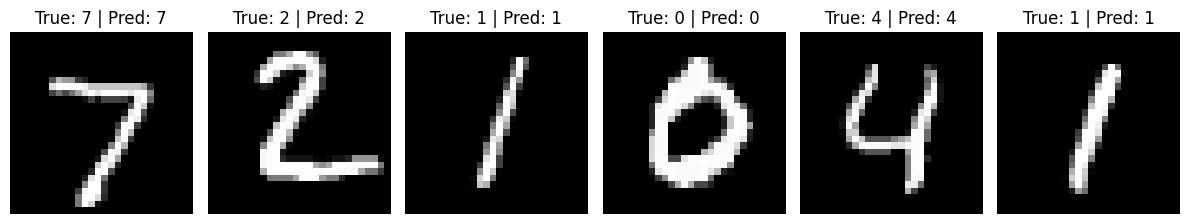

In [49]:
test_cnn(modelCNN, test_loader)

* Learning Rate=0.05
* Batch size = 32

Epoch [1/10]
Training Loss: 0.4077, Accuracy: 87.31%
Validation Loss: 0.0986, Accuracy: 97.19%
Epoch [2/10]
Training Loss: 0.1603, Accuracy: 95.64%
Validation Loss: 0.0678, Accuracy: 98.19%
Epoch [3/10]
Training Loss: 0.1273, Accuracy: 96.68%
Validation Loss: 0.0699, Accuracy: 98.29%
Epoch [4/10]
Training Loss: 0.1027, Accuracy: 97.30%
Validation Loss: 0.0571, Accuracy: 98.62%
Epoch [5/10]
Training Loss: 0.0886, Accuracy: 97.69%
Validation Loss: 0.0504, Accuracy: 98.76%
Epoch [6/10]
Training Loss: 0.0767, Accuracy: 97.94%
Validation Loss: 0.0615, Accuracy: 98.70%
Epoch [7/10]
Training Loss: 0.0686, Accuracy: 98.26%
Validation Loss: 0.0457, Accuracy: 98.84%
Epoch [8/10]
Training Loss: 0.0635, Accuracy: 98.30%
Validation Loss: 0.0501, Accuracy: 98.80%
Epoch [9/10]
Training Loss: 0.0558, Accuracy: 98.54%
Validation Loss: 0.0480, Accuracy: 98.94%
Epoch [10/10]
Training Loss: 0.0521, Accuracy: 98.63%
Validation Loss: 0.0548, Accuracy: 98.74%


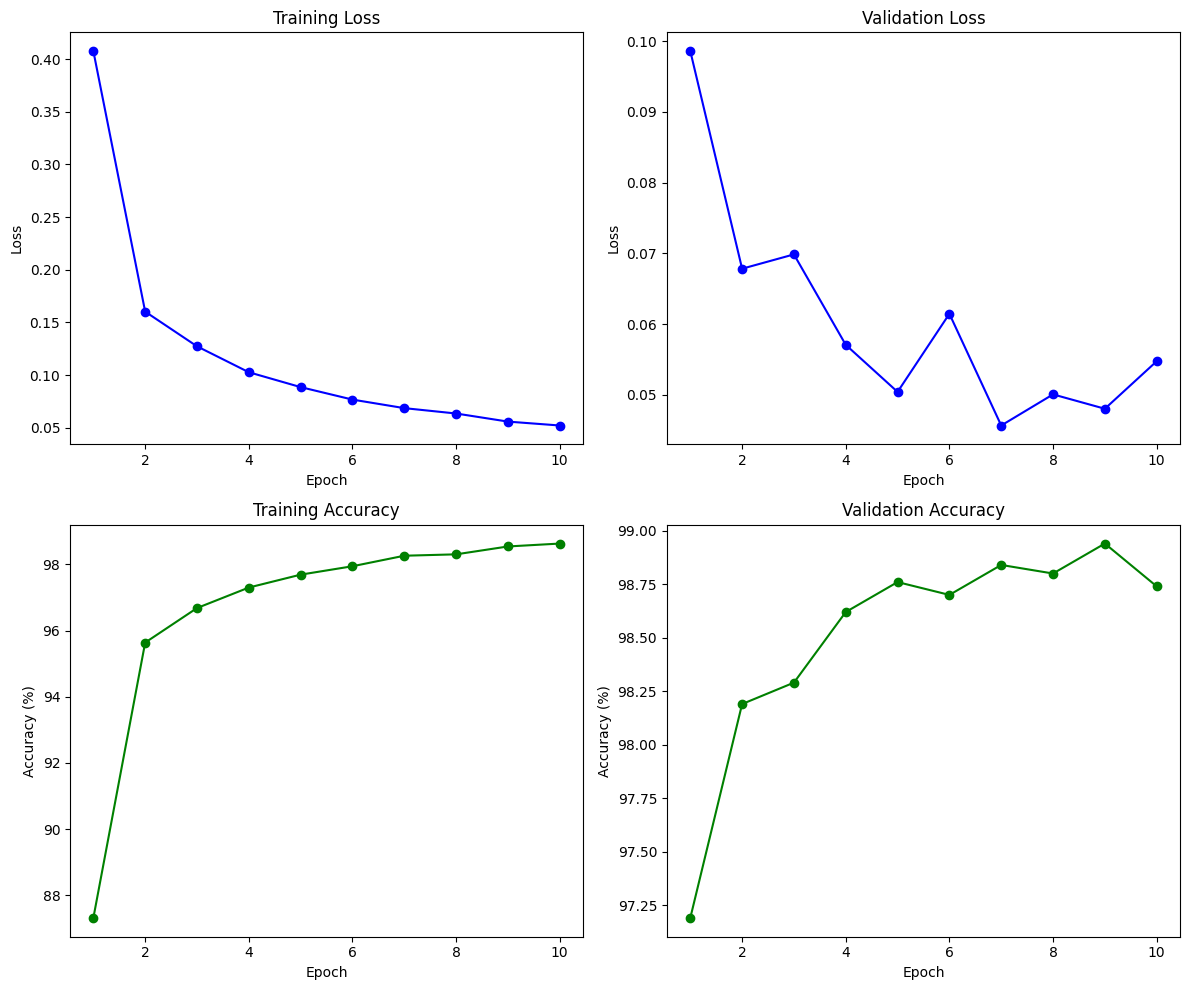

In [51]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.05)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 99.17%


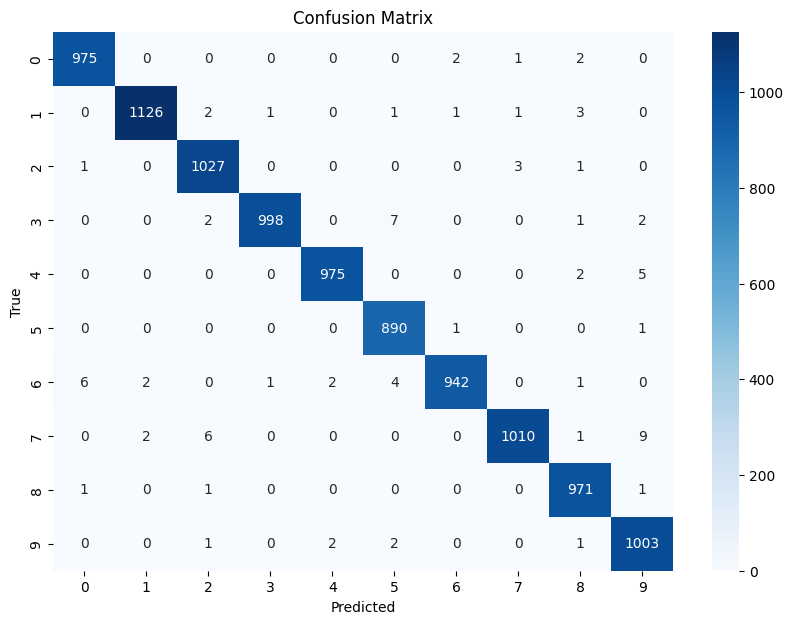

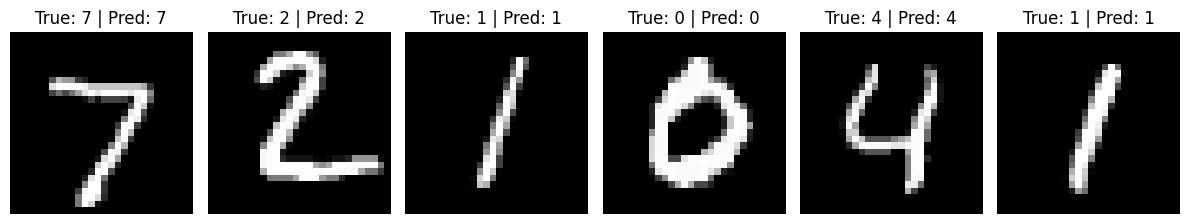

In [52]:
test_cnn(modelCNN, test_loader)

* Learning Rate=0.001
* Batch size = 32

Epoch [1/10]
Training Loss: 1.7784, Accuracy: 40.92%
Validation Loss: 0.8719, Accuracy: 85.91%
Epoch [2/10]
Training Loss: 0.9130, Accuracy: 71.62%
Validation Loss: 0.3723, Accuracy: 92.64%
Epoch [3/10]
Training Loss: 0.5919, Accuracy: 82.21%
Validation Loss: 0.2318, Accuracy: 94.33%
Epoch [4/10]
Training Loss: 0.4502, Accuracy: 87.07%
Validation Loss: 0.1771, Accuracy: 95.37%
Epoch [5/10]
Training Loss: 0.3678, Accuracy: 89.78%
Validation Loss: 0.1461, Accuracy: 95.98%
Epoch [6/10]
Training Loss: 0.3160, Accuracy: 91.17%
Validation Loss: 0.1266, Accuracy: 96.43%
Epoch [7/10]
Training Loss: 0.2805, Accuracy: 92.48%
Validation Loss: 0.1134, Accuracy: 96.63%
Epoch [8/10]
Training Loss: 0.2536, Accuracy: 93.12%
Validation Loss: 0.1015, Accuracy: 97.01%
Epoch [9/10]
Training Loss: 0.2333, Accuracy: 93.71%
Validation Loss: 0.0945, Accuracy: 97.14%
Epoch [10/10]
Training Loss: 0.2123, Accuracy: 94.23%
Validation Loss: 0.0894, Accuracy: 97.29%


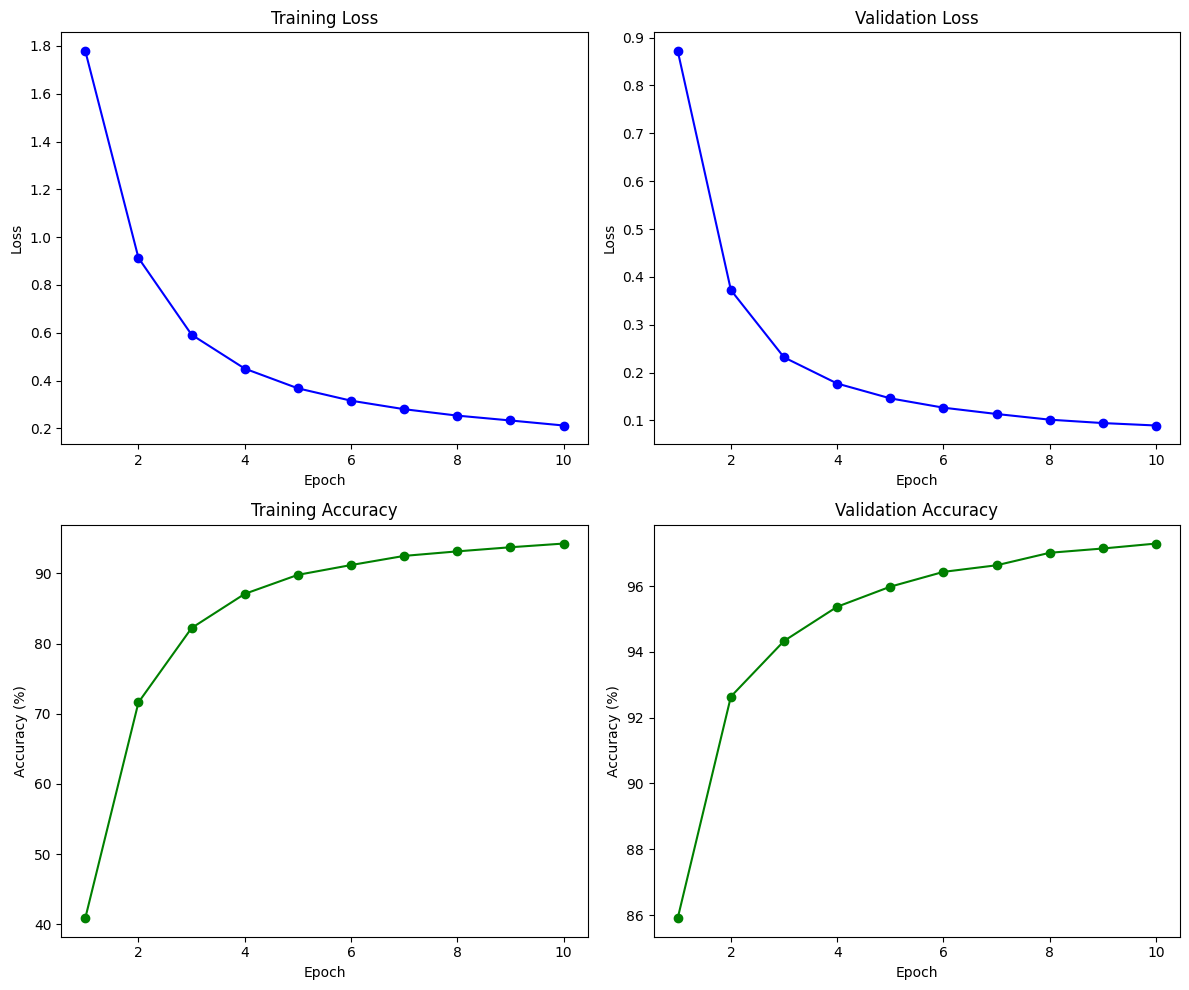

In [53]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.001)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 97.75%


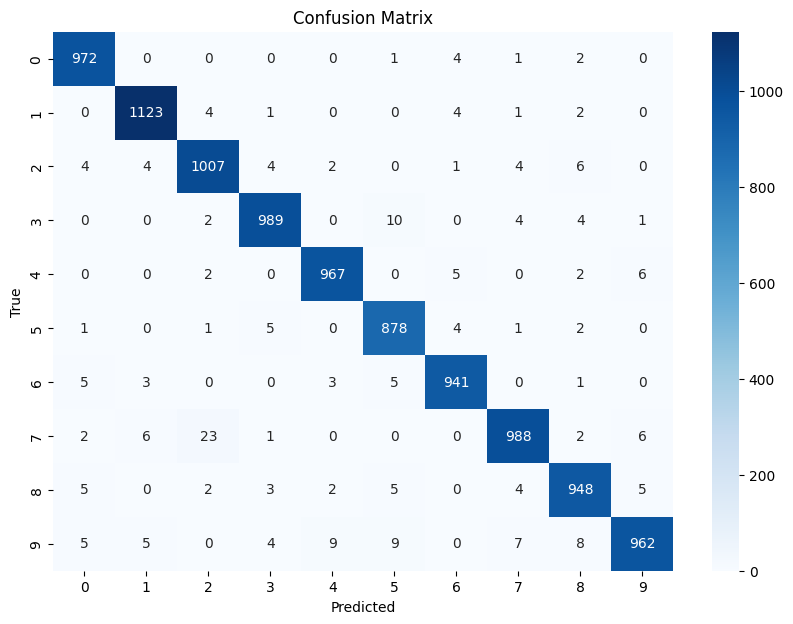

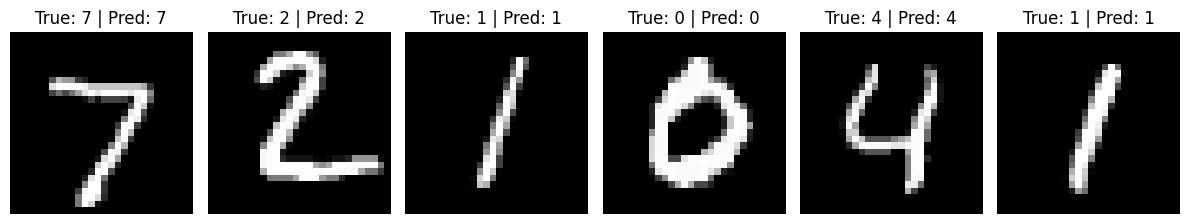

In [54]:
test_cnn(modelCNN, test_loader)

* Learning Rate=0.0001
* Batch size = 32

Epoch [1/10]
Training Loss: 2.2685, Accuracy: 14.54%
Validation Loss: 2.1885, Accuracy: 28.95%
Epoch [2/10]
Training Loss: 2.1767, Accuracy: 23.11%
Validation Loss: 2.0764, Accuracy: 51.57%
Epoch [3/10]
Training Loss: 2.0775, Accuracy: 31.27%
Validation Loss: 1.9378, Accuracy: 62.63%
Epoch [4/10]
Training Loss: 1.9620, Accuracy: 37.43%
Validation Loss: 1.7817, Accuracy: 68.78%
Epoch [5/10]
Training Loss: 1.8337, Accuracy: 43.32%
Validation Loss: 1.6004, Accuracy: 72.21%
Epoch [6/10]
Training Loss: 1.7000, Accuracy: 47.94%
Validation Loss: 1.4260, Accuracy: 75.47%
Epoch [7/10]
Training Loss: 1.5673, Accuracy: 52.20%
Validation Loss: 1.2575, Accuracy: 77.93%
Epoch [8/10]
Training Loss: 1.4518, Accuracy: 55.38%
Validation Loss: 1.1127, Accuracy: 80.33%
Epoch [9/10]
Training Loss: 1.3436, Accuracy: 58.64%
Validation Loss: 0.9891, Accuracy: 82.33%
Epoch [10/10]
Training Loss: 1.2500, Accuracy: 61.35%
Validation Loss: 0.8852, Accuracy: 84.51%


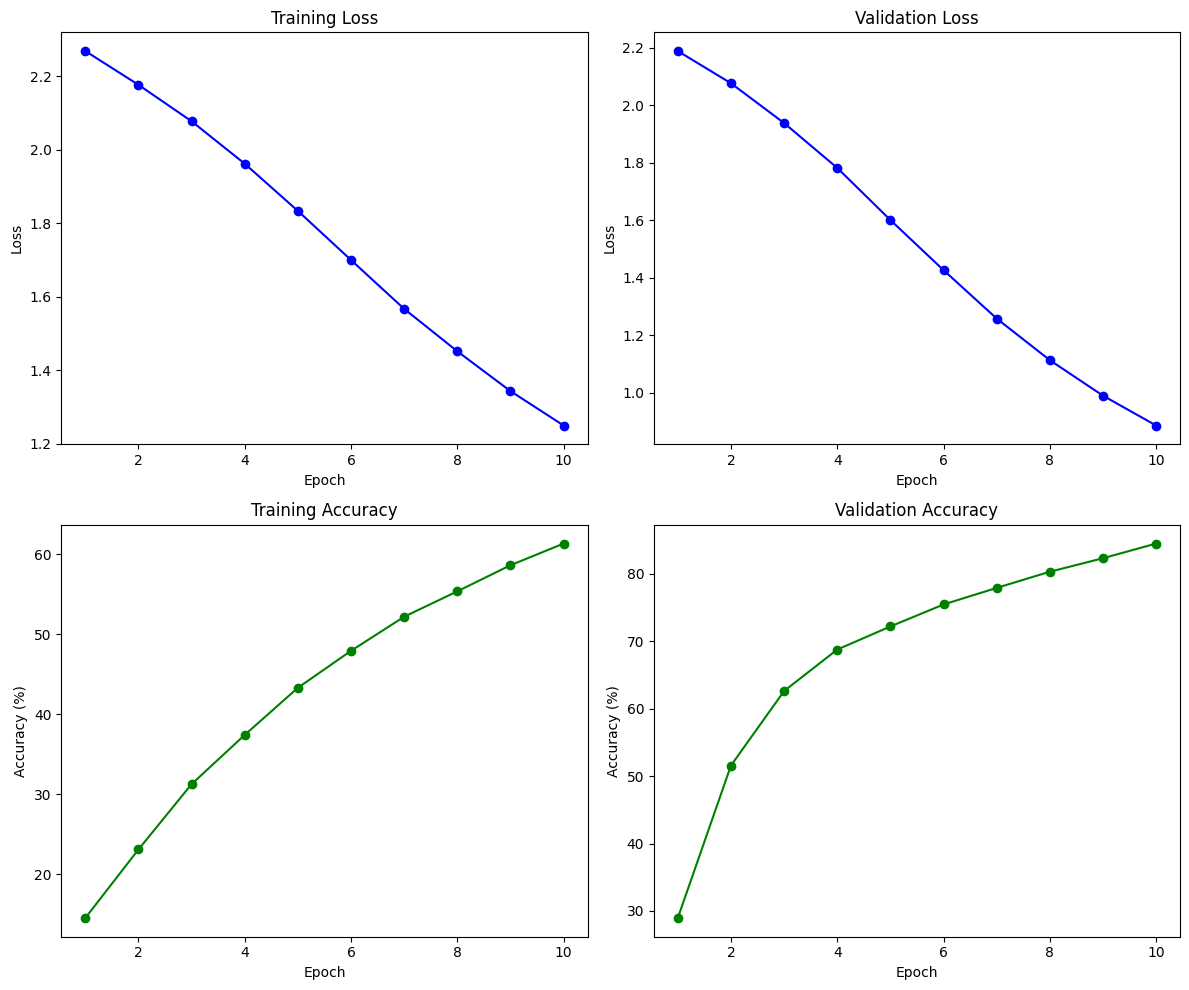

In [55]:
modelCNN=CNN()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(modelCNN.parameters(), lr=0.0001)

train_cnn(modelCNN, train_loader, val_loader, loss_fn, optimizer, 10)

Test Accuracy: 85.51%


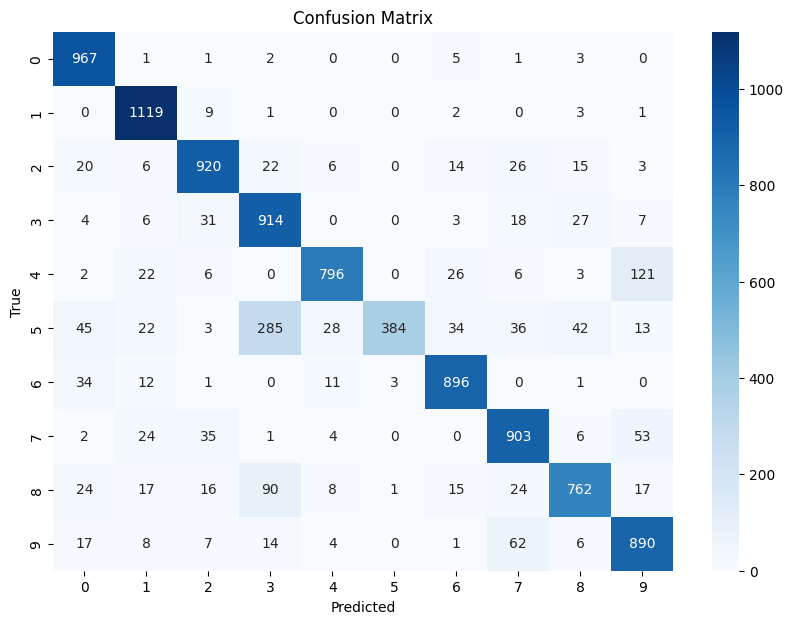

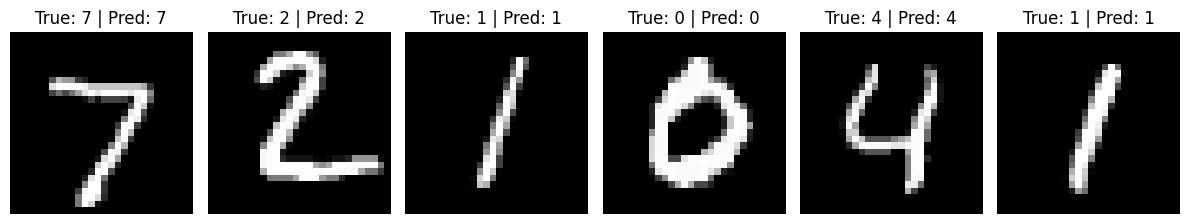

In [56]:
test_cnn(modelCNN, test_loader)

## **Trying Different Batch Sizes [64,128,256,512]**


Testing with Batch Size: 64
Epoch [1/10]
Training Loss: 0.8442, Accuracy: 73.24%
Validation Loss: 0.1557, Accuracy: 95.53%
Epoch [2/10]
Training Loss: 0.2727, Accuracy: 92.41%
Validation Loss: 0.1005, Accuracy: 97.04%
Epoch [3/10]
Training Loss: 0.1898, Accuracy: 94.91%
Validation Loss: 0.0829, Accuracy: 97.47%
Epoch [4/10]
Training Loss: 0.1538, Accuracy: 95.81%
Validation Loss: 0.0665, Accuracy: 98.16%
Epoch [5/10]
Training Loss: 0.1317, Accuracy: 96.45%
Validation Loss: 0.0596, Accuracy: 98.30%
Epoch [6/10]
Training Loss: 0.1135, Accuracy: 97.04%
Validation Loss: 0.0576, Accuracy: 98.33%
Epoch [7/10]
Training Loss: 0.1047, Accuracy: 97.20%
Validation Loss: 0.0668, Accuracy: 97.96%
Epoch [8/10]
Training Loss: 0.0938, Accuracy: 97.55%
Validation Loss: 0.0614, Accuracy: 98.27%
Epoch [9/10]
Training Loss: 0.0903, Accuracy: 97.66%
Validation Loss: 0.0491, Accuracy: 98.69%
Epoch [10/10]
Training Loss: 0.0787, Accuracy: 97.92%
Validation Loss: 0.0489, Accuracy: 98.70%


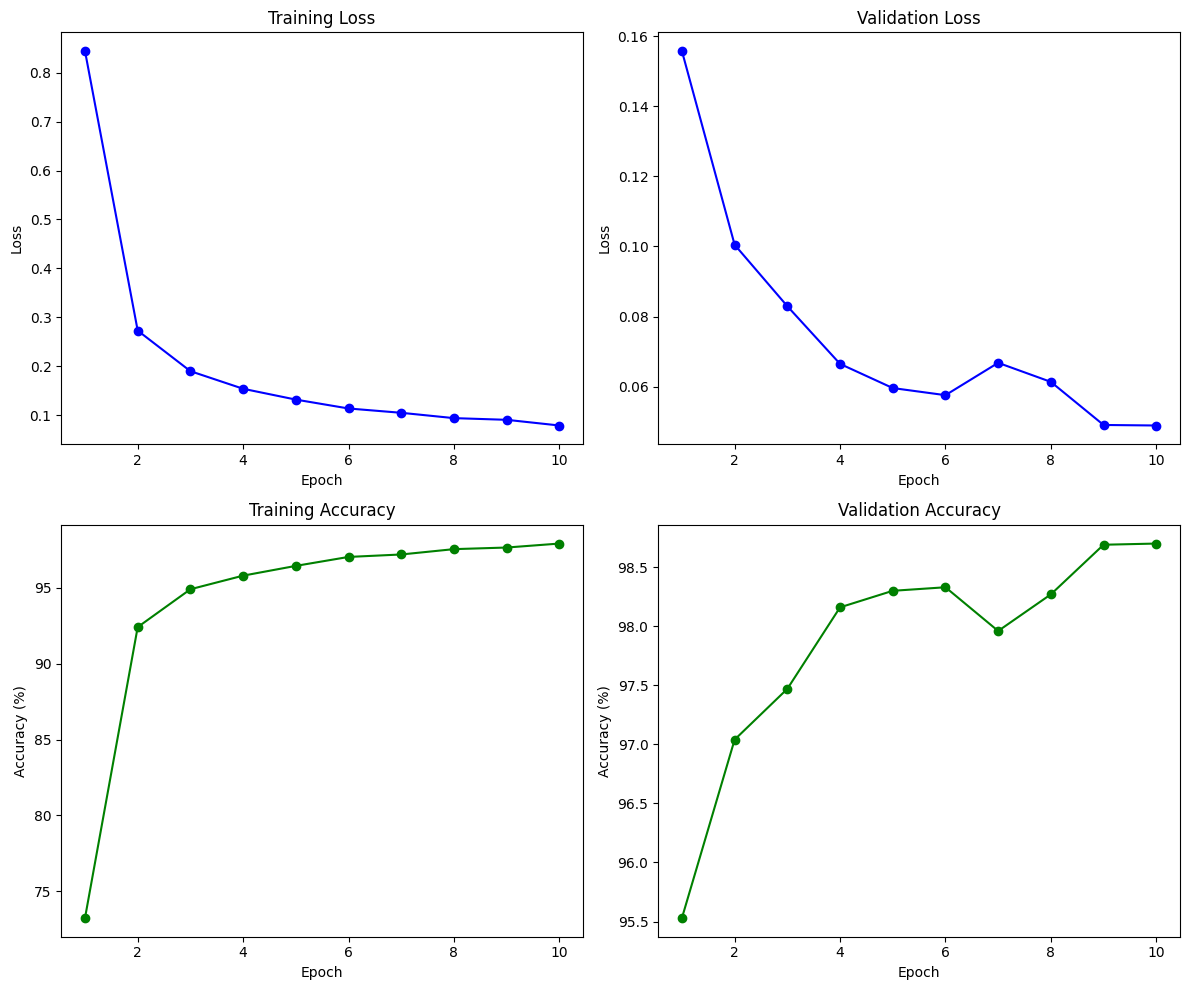

Test Accuracy: 98.88%


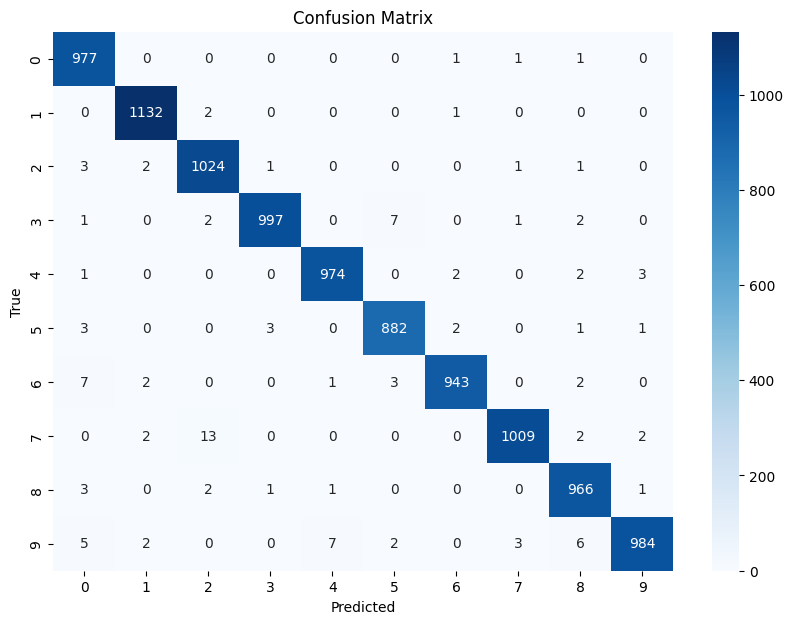

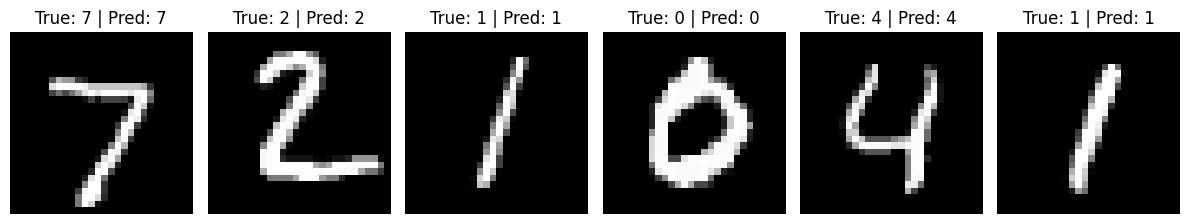


Testing with Batch Size: 128
Epoch [1/10]
Training Loss: 1.2472, Accuracy: 59.39%
Validation Loss: 0.3037, Accuracy: 93.34%
Epoch [2/10]
Training Loss: 0.4599, Accuracy: 86.34%
Validation Loss: 0.1472, Accuracy: 95.94%
Epoch [3/10]
Training Loss: 0.3099, Accuracy: 91.29%
Validation Loss: 0.1107, Accuracy: 96.77%
Epoch [4/10]
Training Loss: 0.2391, Accuracy: 93.40%
Validation Loss: 0.0898, Accuracy: 97.41%
Epoch [5/10]
Training Loss: 0.1986, Accuracy: 94.54%
Validation Loss: 0.0759, Accuracy: 97.79%
Epoch [6/10]
Training Loss: 0.1709, Accuracy: 95.39%
Validation Loss: 0.0735, Accuracy: 97.87%
Epoch [7/10]
Training Loss: 0.1509, Accuracy: 95.94%
Validation Loss: 0.0640, Accuracy: 98.13%
Epoch [8/10]
Training Loss: 0.1367, Accuracy: 96.39%
Validation Loss: 0.0583, Accuracy: 98.28%
Epoch [9/10]
Training Loss: 0.1289, Accuracy: 96.65%
Validation Loss: 0.0571, Accuracy: 98.39%
Epoch [10/10]
Training Loss: 0.1184, Accuracy: 96.90%
Validation Loss: 0.0552, Accuracy: 98.43%


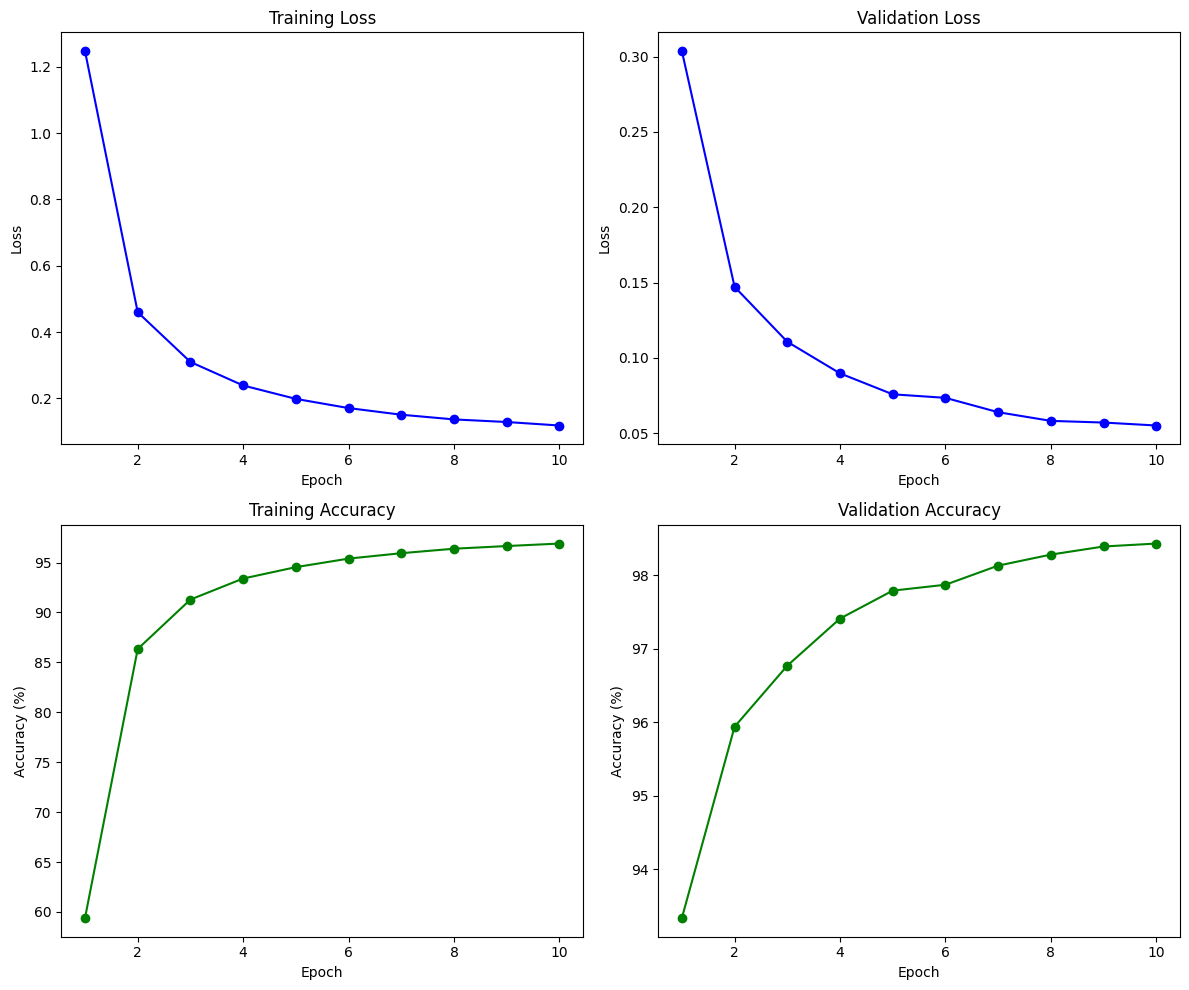

Test Accuracy: 98.59%


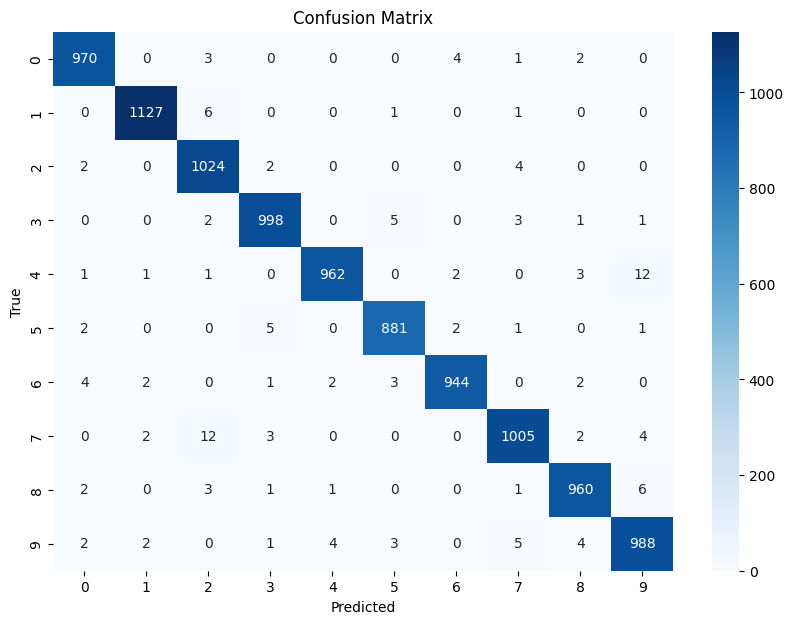

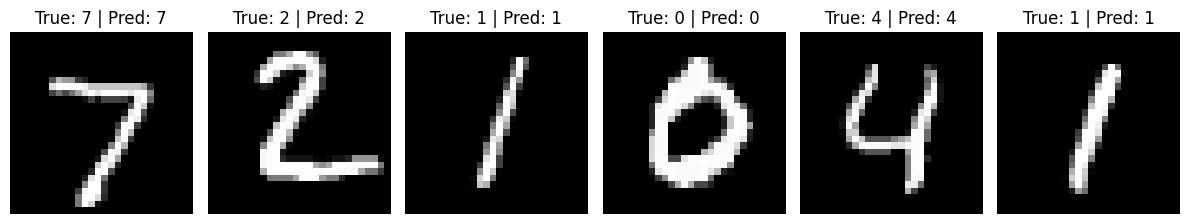


Testing with Batch Size: 256
Epoch [1/10]
Training Loss: 1.7093, Accuracy: 43.47%
Validation Loss: 0.7557, Accuracy: 87.22%
Epoch [2/10]
Training Loss: 0.8113, Accuracy: 74.65%
Validation Loss: 0.3146, Accuracy: 92.77%
Epoch [3/10]
Training Loss: 0.5205, Accuracy: 84.37%
Validation Loss: 0.1921, Accuracy: 94.92%
Epoch [4/10]
Training Loss: 0.3898, Accuracy: 88.65%
Validation Loss: 0.1434, Accuracy: 95.95%
Epoch [5/10]
Training Loss: 0.3140, Accuracy: 91.11%
Validation Loss: 0.1175, Accuracy: 96.59%
Epoch [6/10]
Training Loss: 0.2702, Accuracy: 92.61%
Validation Loss: 0.1038, Accuracy: 96.97%
Epoch [7/10]
Training Loss: 0.2386, Accuracy: 93.35%
Validation Loss: 0.0918, Accuracy: 97.34%
Epoch [8/10]
Training Loss: 0.2141, Accuracy: 94.05%
Validation Loss: 0.0843, Accuracy: 97.40%
Epoch [9/10]
Training Loss: 0.1940, Accuracy: 94.69%
Validation Loss: 0.0807, Accuracy: 97.58%
Epoch [10/10]
Training Loss: 0.1801, Accuracy: 95.15%
Validation Loss: 0.0708, Accuracy: 97.95%


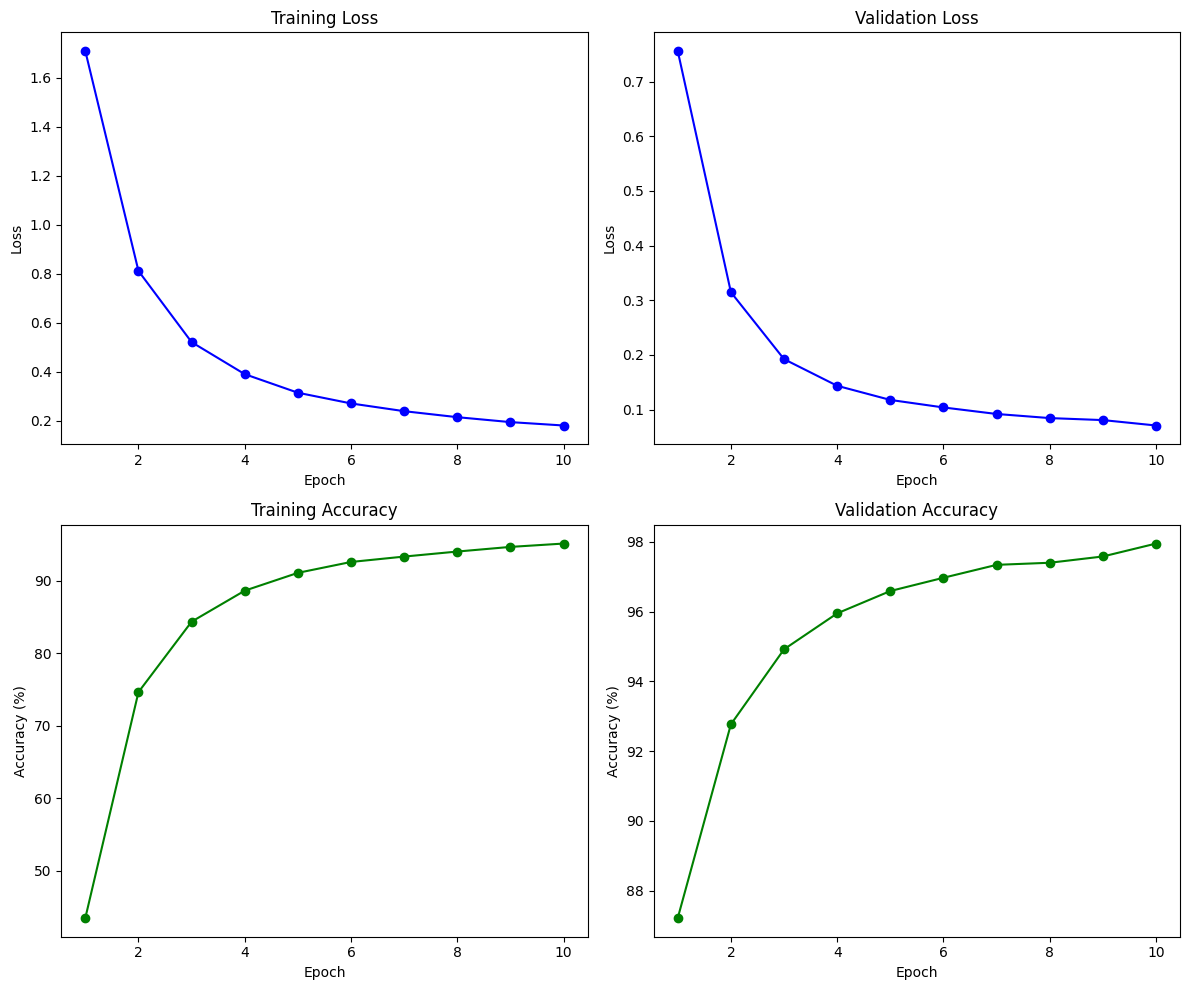

Test Accuracy: 98.13%


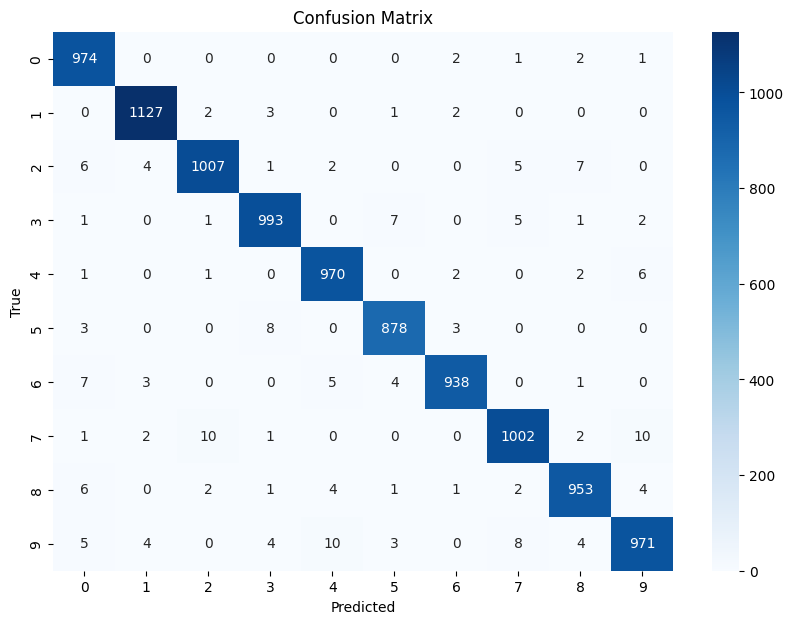

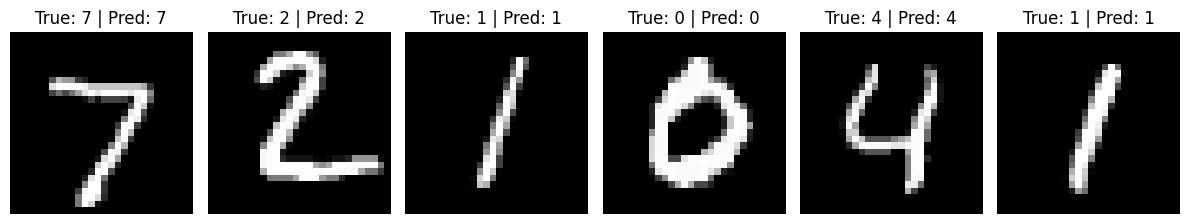


Testing with Batch Size: 512
Epoch [1/10]
Training Loss: 1.9865, Accuracy: 32.86%
Validation Loss: 1.3759, Accuracy: 78.85%
Epoch [2/10]
Training Loss: 1.2936, Accuracy: 59.57%
Validation Loss: 0.7022, Accuracy: 86.89%
Epoch [3/10]
Training Loss: 0.9048, Accuracy: 71.98%
Validation Loss: 0.4356, Accuracy: 91.39%
Epoch [4/10]
Training Loss: 0.6899, Accuracy: 79.06%
Validation Loss: 0.3052, Accuracy: 93.23%
Epoch [5/10]
Training Loss: 0.5591, Accuracy: 83.46%
Validation Loss: 0.2333, Accuracy: 94.26%
Epoch [6/10]
Training Loss: 0.4650, Accuracy: 86.35%
Validation Loss: 0.1914, Accuracy: 95.16%
Epoch [7/10]
Training Loss: 0.4047, Accuracy: 88.32%
Validation Loss: 0.1630, Accuracy: 95.81%
Epoch [8/10]
Training Loss: 0.3641, Accuracy: 89.62%
Validation Loss: 0.1424, Accuracy: 96.24%
Epoch [9/10]
Training Loss: 0.3184, Accuracy: 91.15%
Validation Loss: 0.1272, Accuracy: 96.40%
Epoch [10/10]
Training Loss: 0.2935, Accuracy: 91.79%
Validation Loss: 0.1159, Accuracy: 96.51%


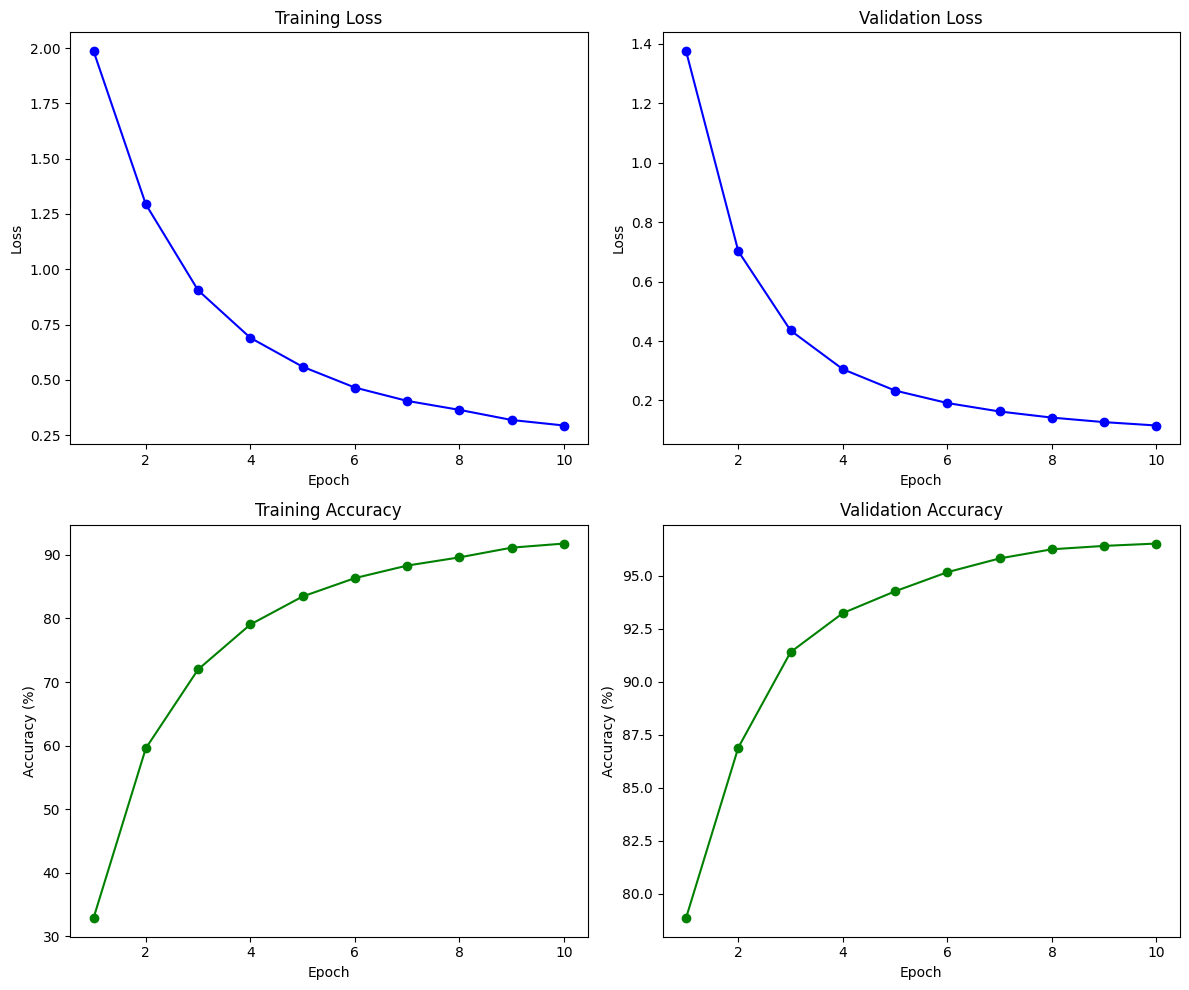

Test Accuracy: 96.91%


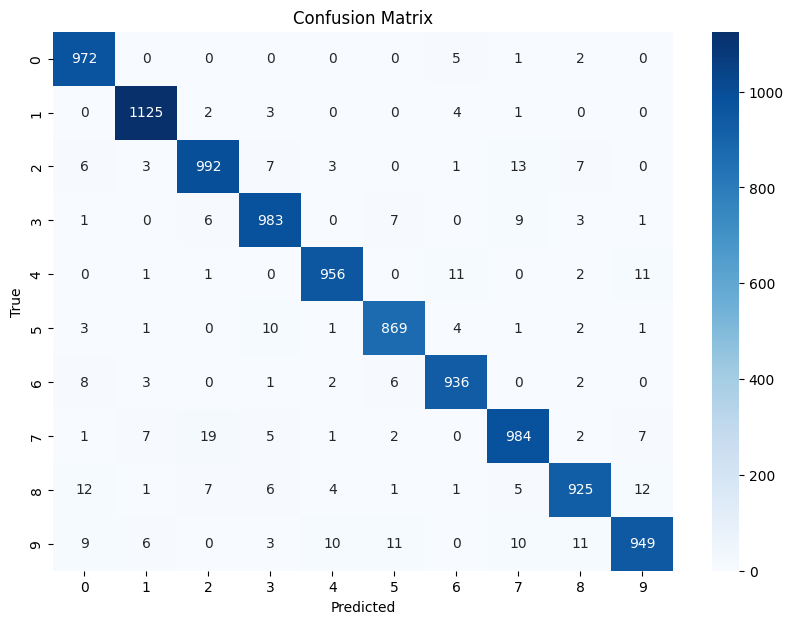

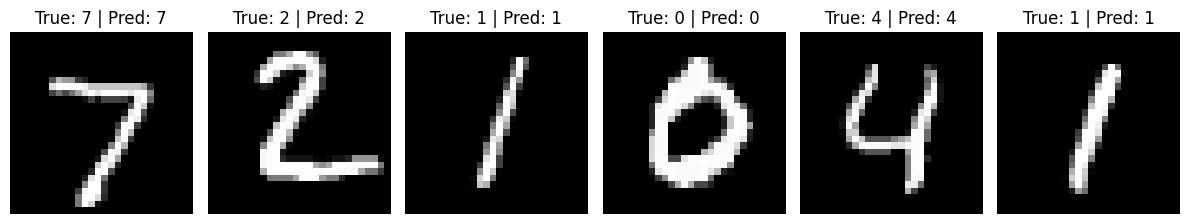

In [ ]:
# Batch sizes to test
batch_sizes = [64, 128, 256, 512]





def Trying_batch_sizes():
    for batch_size in batch_sizes:
        print(f"\nTesting with Batch Size: {batch_size}")
        
        
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        
        model = CNN()
        optimizer =optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss()
        
       
        train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)
        
        
        test_cnn(model, test_loader)
        
        
      


Trying_batch_sizes()




# More Analysis
 
* Different Number of Convolution Layers 
* Different Number of Neurons in Convolutional Layers


In [ ]:
class CNNConvNeurons(nn.Module):
    def __init__(self, conv_neurons=[32, 64], fc_neurons=[128, 64]):
        super(CNNConvNeurons, self).__init__()

       
        self.conv_neurons = conv_neurons

        
        self.conv1 = nn.Conv2d(1, conv_neurons[0], kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(conv_neurons[0])

        self.conv2 = nn.Conv2d(conv_neurons[0], conv_neurons[1], kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(conv_neurons[1])

        # Max pooling
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        self.fc1 = nn.Linear(conv_neurons[1] * 7 * 7, fc_neurons[0])
        self.fc2 = nn.Linear(fc_neurons[0], fc_neurons[1])
        self.fc3 = nn.Linear(fc_neurons[1], 10)

        # Dropout
        self.dropout = nn.Dropout(0.5)
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        # First convolutional 
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))
        
        
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))

        # Flatten
        x = x.view(-1, self.conv_neurons[1] * 7 * 7)

        
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.dropout(self.activation_fn(self.fc2(x)))
        x = self.fc3(x)

        return x



## **experiment function**


Testing with Conv Neurons: [64, 128], FC Neurons: [128, 64]
Epoch [1/10]
Training Loss: 0.5693, Accuracy: 82.23%
Validation Loss: 0.1041, Accuracy: 97.04%
Epoch [2/10]
Training Loss: 0.1823, Accuracy: 94.96%
Validation Loss: 0.0789, Accuracy: 97.76%
Epoch [3/10]
Training Loss: 0.1345, Accuracy: 96.40%
Validation Loss: 0.0577, Accuracy: 98.31%
Epoch [4/10]
Training Loss: 0.1146, Accuracy: 96.92%
Validation Loss: 0.0533, Accuracy: 98.52%
Epoch [5/10]
Training Loss: 0.0970, Accuracy: 97.44%
Validation Loss: 0.0498, Accuracy: 98.67%
Epoch [6/10]
Training Loss: 0.0901, Accuracy: 97.63%
Validation Loss: 0.0473, Accuracy: 98.66%
Epoch [7/10]
Training Loss: 0.0771, Accuracy: 98.03%
Validation Loss: 0.0515, Accuracy: 98.76%
Epoch [8/10]
Training Loss: 0.0724, Accuracy: 98.15%
Validation Loss: 0.0599, Accuracy: 98.61%
Epoch [9/10]
Training Loss: 0.0687, Accuracy: 98.16%
Validation Loss: 0.0531, Accuracy: 98.58%
Epoch [10/10]
Training Loss: 0.0611, Accuracy: 98.37%
Validation Loss: 0.0555, Accur

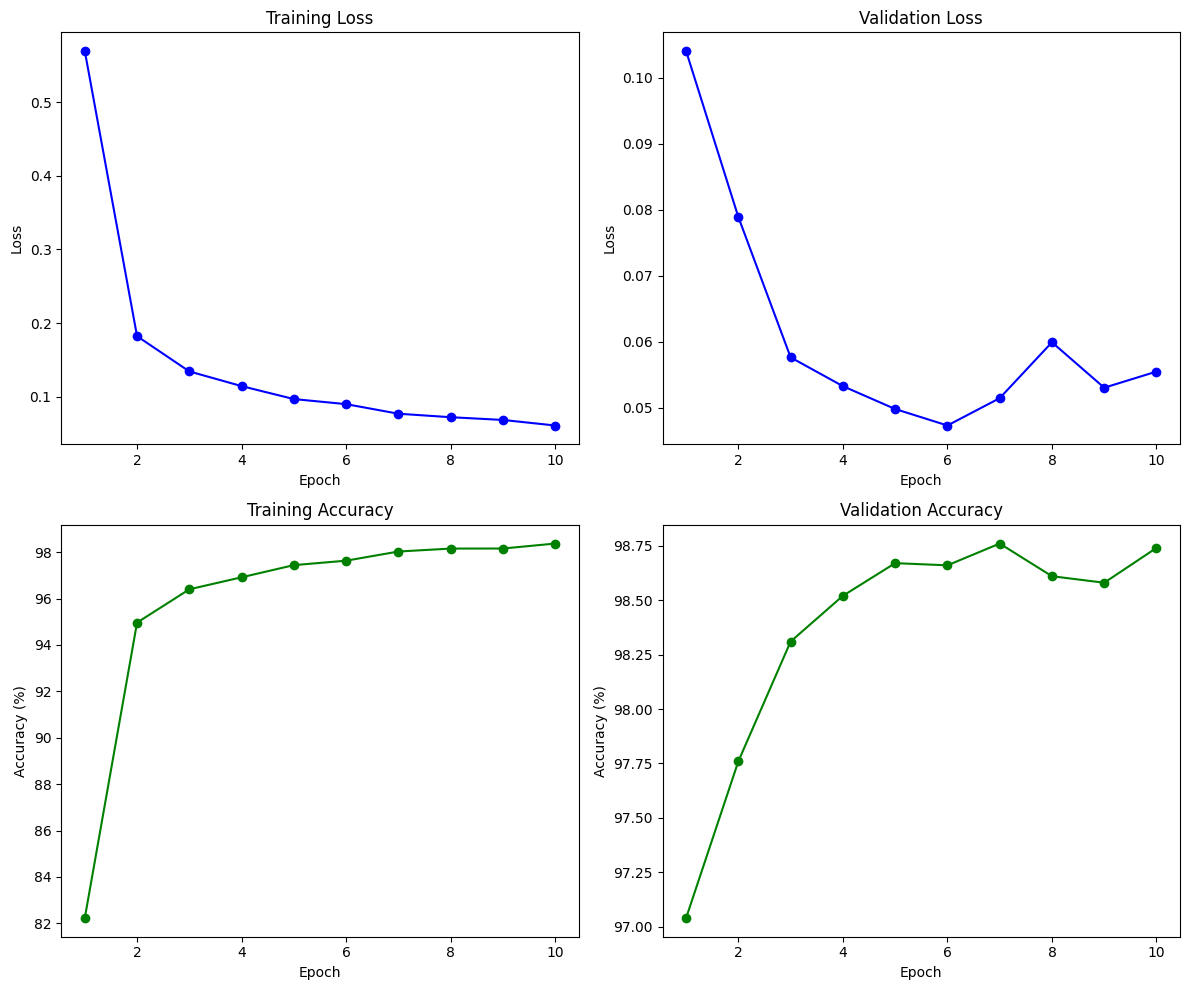

Test Accuracy: 98.83%


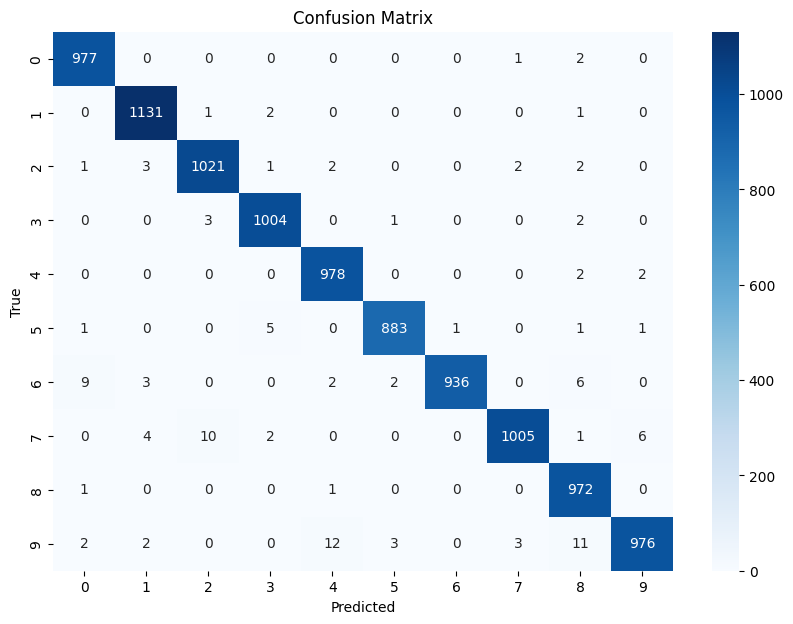

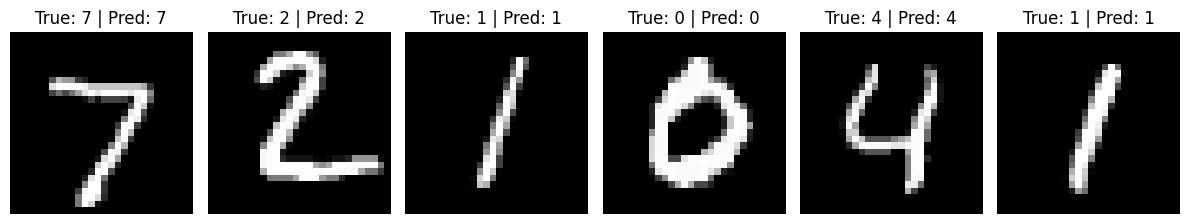


Testing with Conv Neurons: [128, 256], FC Neurons: [128, 64]
Epoch [1/10]
Training Loss: 0.5176, Accuracy: 83.60%
Validation Loss: 0.0865, Accuracy: 97.36%
Epoch [2/10]
Training Loss: 0.1765, Accuracy: 95.23%
Validation Loss: 0.0831, Accuracy: 97.68%
Epoch [3/10]
Training Loss: 0.1339, Accuracy: 96.43%
Validation Loss: 0.0631, Accuracy: 98.30%
Epoch [4/10]
Training Loss: 0.1148, Accuracy: 96.93%
Validation Loss: 0.0561, Accuracy: 98.52%
Epoch [5/10]
Training Loss: 0.0995, Accuracy: 97.39%
Validation Loss: 0.0542, Accuracy: 98.56%
Epoch [6/10]
Training Loss: 0.0867, Accuracy: 97.69%
Validation Loss: 0.0516, Accuracy: 98.70%
Epoch [7/10]
Training Loss: 0.0809, Accuracy: 97.80%
Validation Loss: 0.0434, Accuracy: 98.86%
Epoch [8/10]
Training Loss: 0.0785, Accuracy: 97.97%
Validation Loss: 0.0503, Accuracy: 98.69%
Epoch [9/10]
Training Loss: 0.0689, Accuracy: 98.15%
Validation Loss: 0.0486, Accuracy: 98.59%
Epoch [10/10]
Training Loss: 0.0629, Accuracy: 98.33%
Validation Loss: 0.0642, Accu

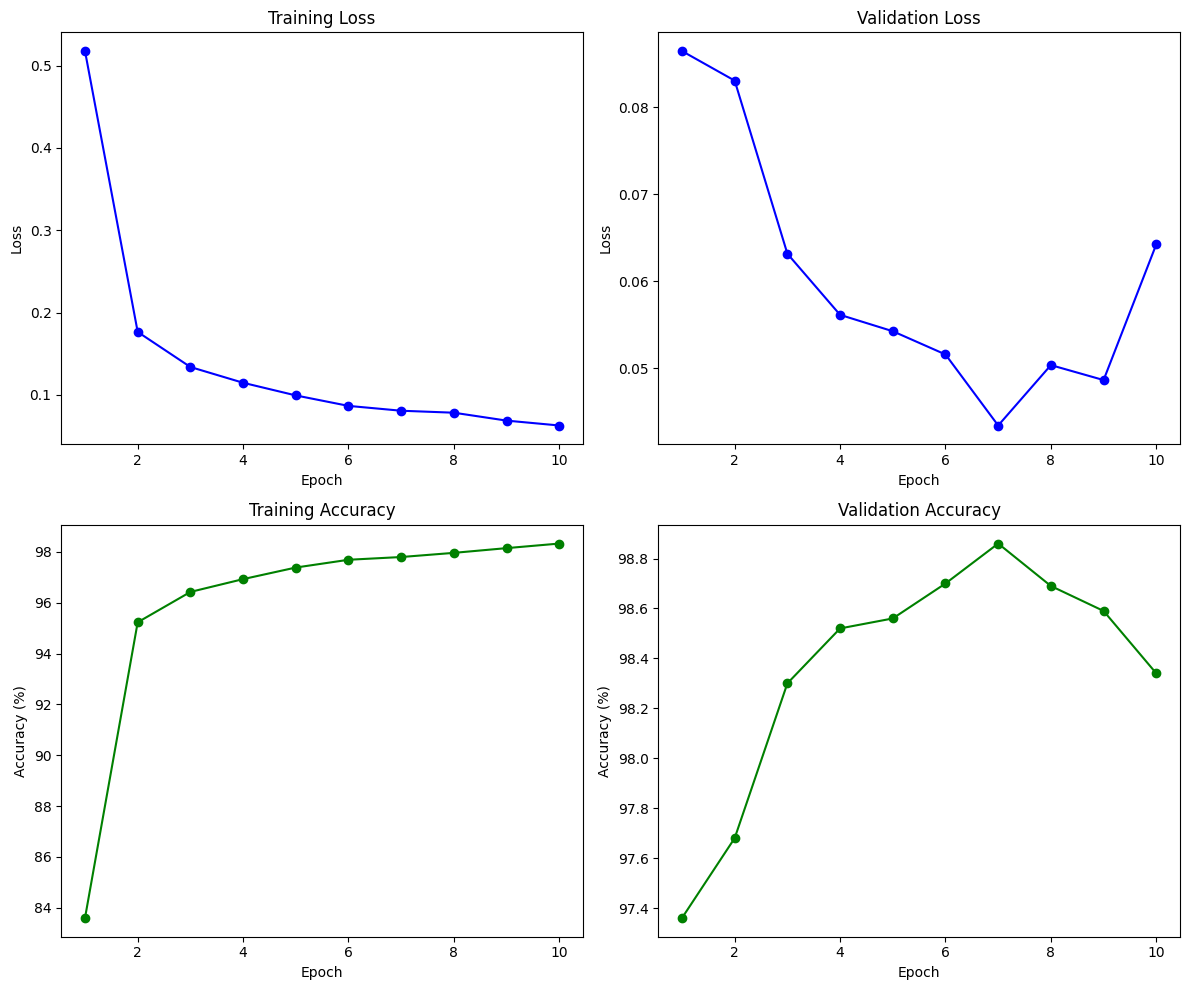

Test Accuracy: 98.29%


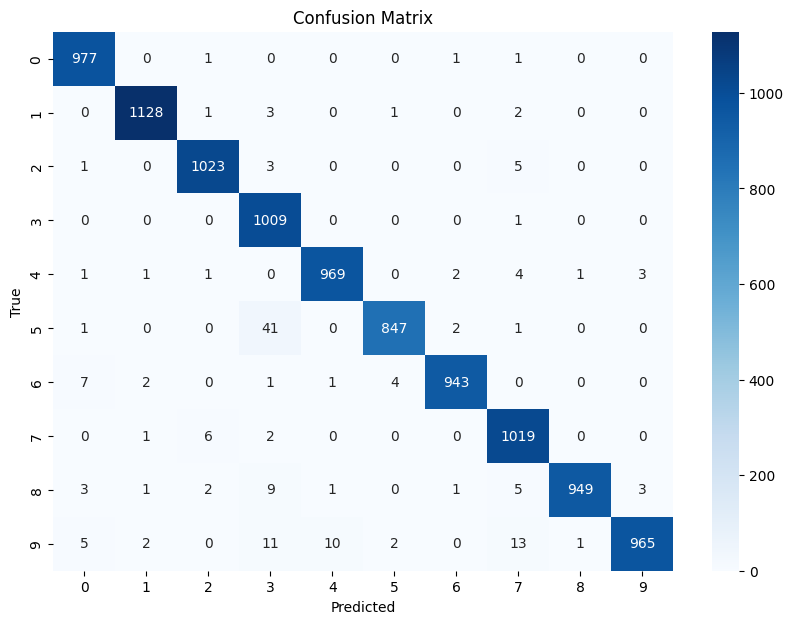

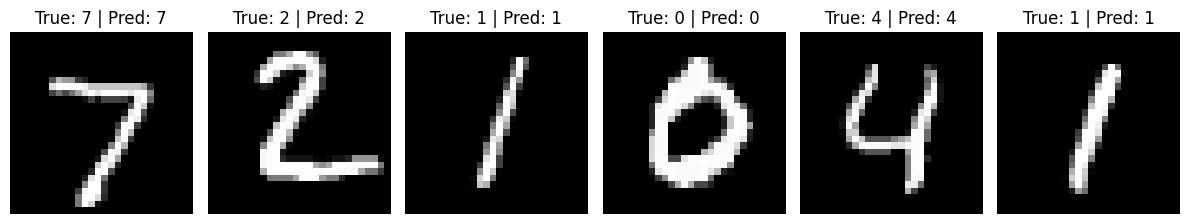


Testing with Conv Neurons: [256, 512], FC Neurons: [128, 64]
Epoch [1/10]
Training Loss: 0.5589, Accuracy: 82.07%
Validation Loss: 0.1124, Accuracy: 96.80%
Epoch [2/10]
Training Loss: 0.2170, Accuracy: 93.95%
Validation Loss: 0.0741, Accuracy: 97.89%
Epoch [3/10]
Training Loss: 0.1718, Accuracy: 95.36%
Validation Loss: 0.1127, Accuracy: 96.83%
Epoch [4/10]
Training Loss: 0.1407, Accuracy: 96.15%
Validation Loss: 0.0629, Accuracy: 98.43%
Epoch [5/10]
Training Loss: 0.1241, Accuracy: 96.46%
Validation Loss: 0.0593, Accuracy: 98.33%
Epoch [6/10]
Training Loss: 0.1129, Accuracy: 96.96%
Validation Loss: 0.0643, Accuracy: 98.48%
Epoch [7/10]
Training Loss: 0.1064, Accuracy: 97.08%
Validation Loss: 0.0546, Accuracy: 98.54%
Epoch [8/10]
Training Loss: 0.0959, Accuracy: 97.24%
Validation Loss: 0.0614, Accuracy: 98.71%
Epoch [9/10]
Training Loss: 0.0916, Accuracy: 97.44%
Validation Loss: 0.0463, Accuracy: 98.76%
Epoch [10/10]
Training Loss: 0.0878, Accuracy: 97.58%
Validation Loss: 0.0545, Accu

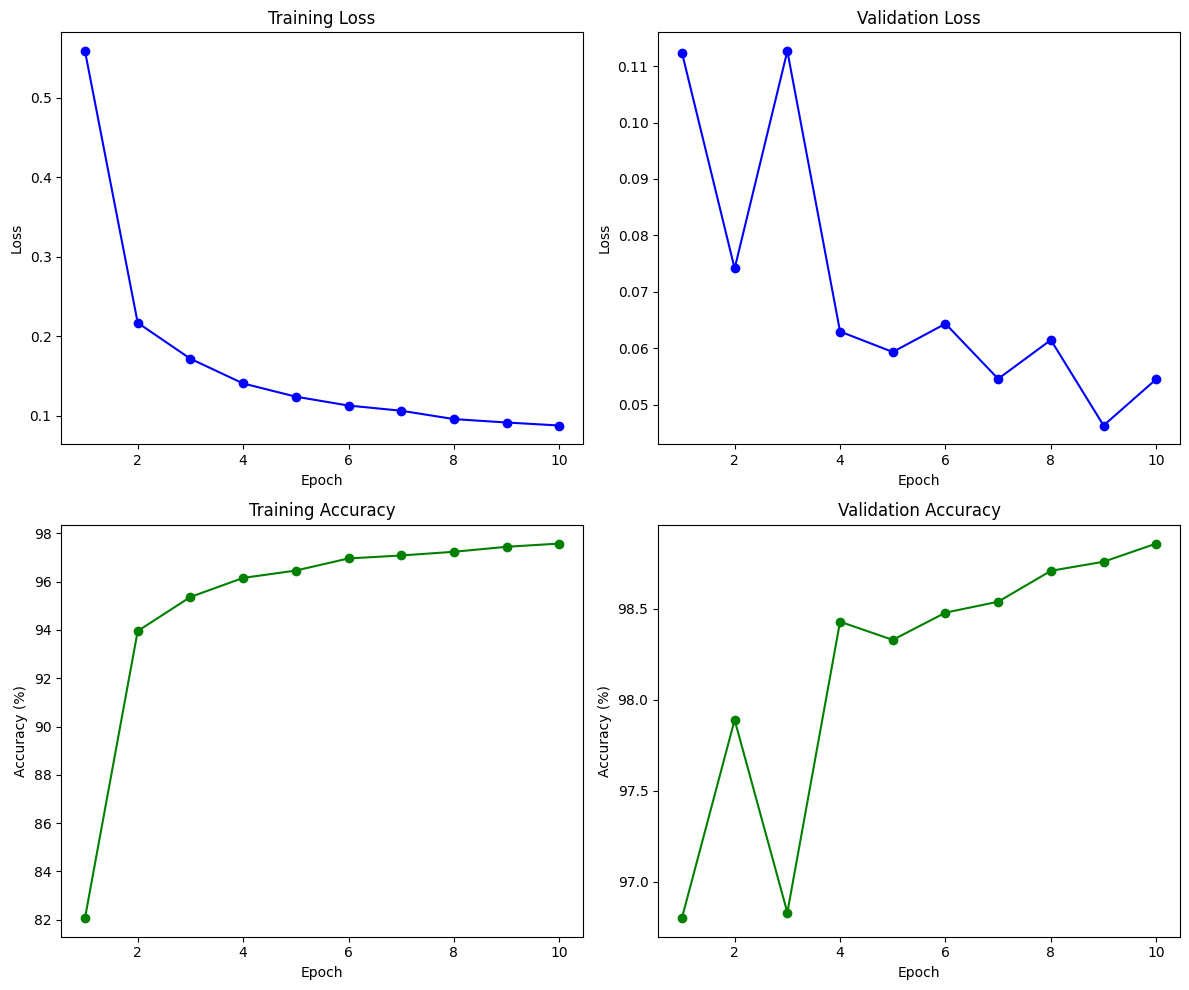

Test Accuracy: 98.78%


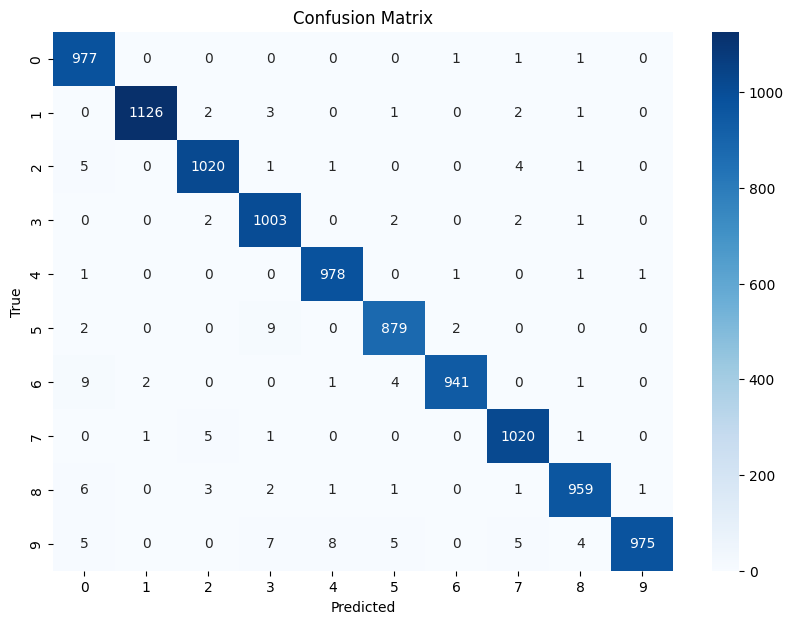

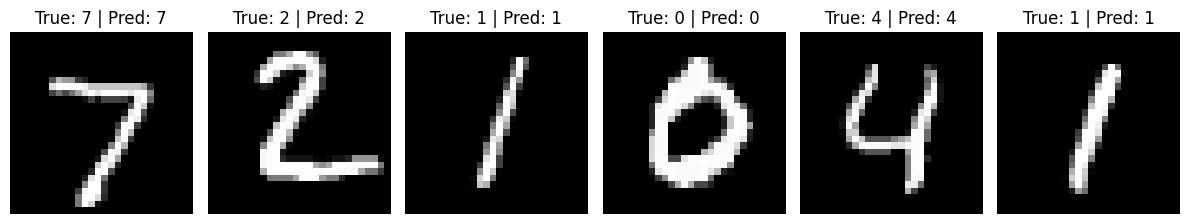

In [ ]:
def experiment():
    
    #number of neurons in the convolutional layers
    conv_neuron_s = [
          
        [64, 128],  
        [128, 256],  
        [256, 512]  
    ]

    for conv_neurons in conv_neurons:
        print(f"\nTesting with Conv Neurons: {conv_neurons}, FC Neurons: [128, 64]")

        model = CNNConvNeurons(conv_neurons=conv_neurons, fc_neurons=[128, 64])
        optimizer = optim.SGD(model.parameters(), lr=0.01)
        loss_fn = nn.CrossEntropyLoss()

        # Train and test
        train_cnn(model, train_loader, val_loader, loss_fn, optimizer, epochs=10)
        test_cnn(model, test_loader)

experiment()      


## 3 Layer CNN


In [ ]:
class CNN3Layer(nn.Module):
    def __init__(self):
        super(CNN3Layer, self).__init__()

        # Convolutional Layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(32 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 10)

        # Dropout 
        self.dropout = nn.Dropout(0.5)

        
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))

        # Flatten and pass through fully connected layers
        x = x.view(-1, 32 * 14 * 14)
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.fc2(x)

        return x


3 Layer Model Train and Test
Epoch [1/10]
Training Loss: 0.3561, Accuracy: 89.46%
Validation Loss: 0.1274, Accuracy: 96.47%
Epoch [2/10]
Training Loss: 0.1604, Accuracy: 95.29%
Validation Loss: 0.0891, Accuracy: 97.44%
Epoch [3/10]
Training Loss: 0.1210, Accuracy: 96.50%
Validation Loss: 0.0751, Accuracy: 97.84%
Epoch [4/10]
Training Loss: 0.0954, Accuracy: 97.18%
Validation Loss: 0.0687, Accuracy: 98.09%
Epoch [5/10]
Training Loss: 0.0857, Accuracy: 97.44%
Validation Loss: 0.0639, Accuracy: 98.19%
Epoch [6/10]
Training Loss: 0.0742, Accuracy: 97.78%
Validation Loss: 0.0596, Accuracy: 98.32%
Epoch [7/10]
Training Loss: 0.0683, Accuracy: 97.98%
Validation Loss: 0.0656, Accuracy: 98.20%
Epoch [8/10]
Training Loss: 0.0594, Accuracy: 98.15%
Validation Loss: 0.0552, Accuracy: 98.37%
Epoch [9/10]
Training Loss: 0.0558, Accuracy: 98.30%
Validation Loss: 0.0540, Accuracy: 98.56%
Epoch [10/10]
Training Loss: 0.0527, Accuracy: 98.41%
Validation Loss: 0.0569, Accuracy: 98.45%


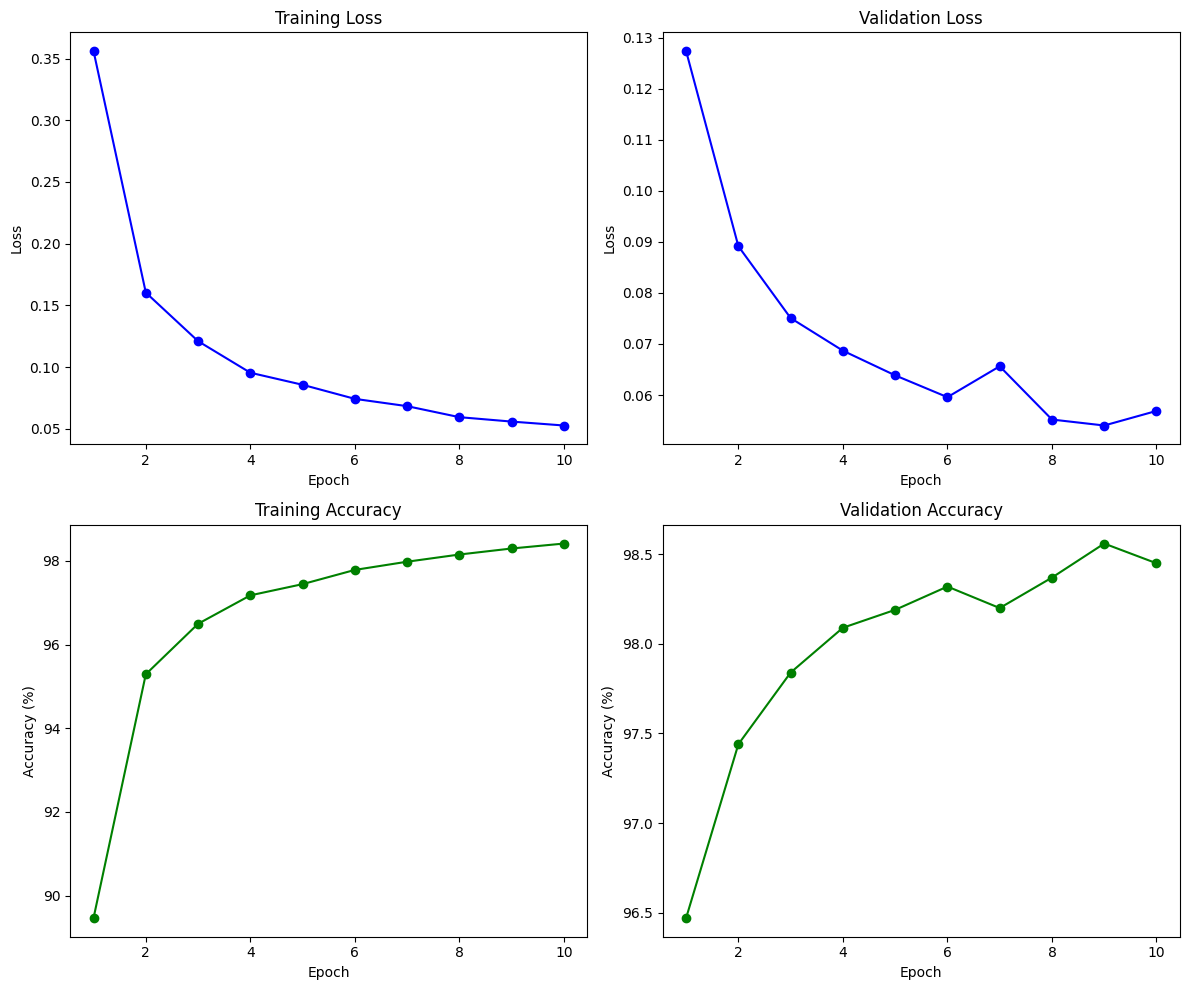

Test Accuracy: 98.52%


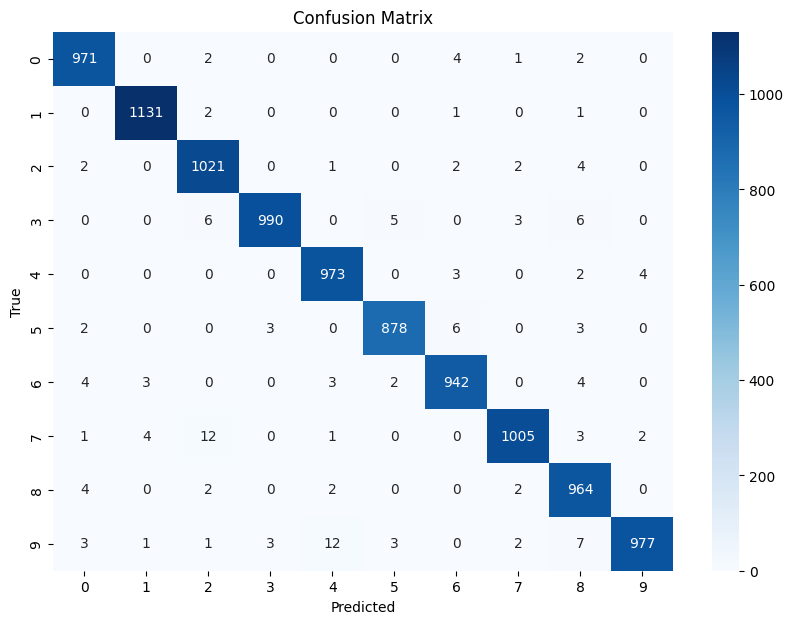

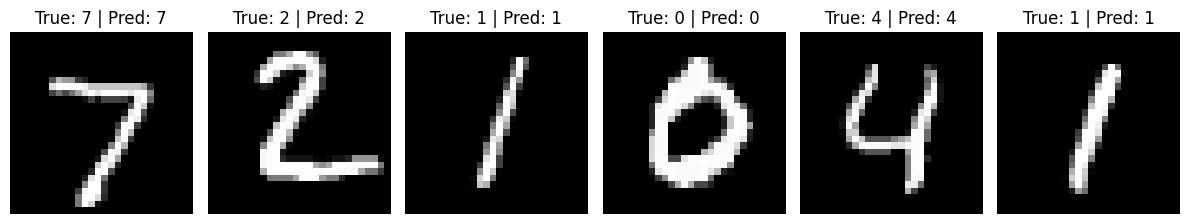

In [16]:
model3 = CNN3Layer()
optimizer = optim.SGD(model3.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Train and test
print("3 Layer Model Train and Test")
train_cnn(model3, train_loader, val_loader, loss_fn, optimizer, epochs=10)
test_cnn(model3, test_loader)

## 4 Layer CNN

In [ ]:
class CNN4Layer(nn.Module):
    def __init__(self):
        super(CNN4Layer, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

       
        self.dropout = nn.Dropout(0.5)

        
        self.activation_fn = nn.ReLU()

    def forward(self, x):
        
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))

        
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))

        # Flatten and pass through fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.fc2(x)

        return x


4 Layer Model Train and Test
Epoch [1/10]
Training Loss: 0.2768, Accuracy: 91.96%
Validation Loss: 0.0852, Accuracy: 97.48%
Epoch [2/10]
Training Loss: 0.0990, Accuracy: 97.13%
Validation Loss: 0.0621, Accuracy: 98.01%
Epoch [3/10]
Training Loss: 0.0758, Accuracy: 97.78%
Validation Loss: 0.0454, Accuracy: 98.73%
Epoch [4/10]
Training Loss: 0.0612, Accuracy: 98.15%
Validation Loss: 0.0419, Accuracy: 98.75%
Epoch [5/10]
Training Loss: 0.0530, Accuracy: 98.41%
Validation Loss: 0.0457, Accuracy: 98.69%
Epoch [6/10]
Training Loss: 0.0485, Accuracy: 98.53%
Validation Loss: 0.0381, Accuracy: 98.77%
Epoch [7/10]
Training Loss: 0.0447, Accuracy: 98.66%
Validation Loss: 0.0350, Accuracy: 98.91%
Epoch [8/10]
Training Loss: 0.0407, Accuracy: 98.74%
Validation Loss: 0.0343, Accuracy: 98.95%
Epoch [9/10]
Training Loss: 0.0387, Accuracy: 98.90%
Validation Loss: 0.0354, Accuracy: 98.96%
Epoch [10/10]
Training Loss: 0.0353, Accuracy: 98.90%
Validation Loss: 0.0340, Accuracy: 99.02%


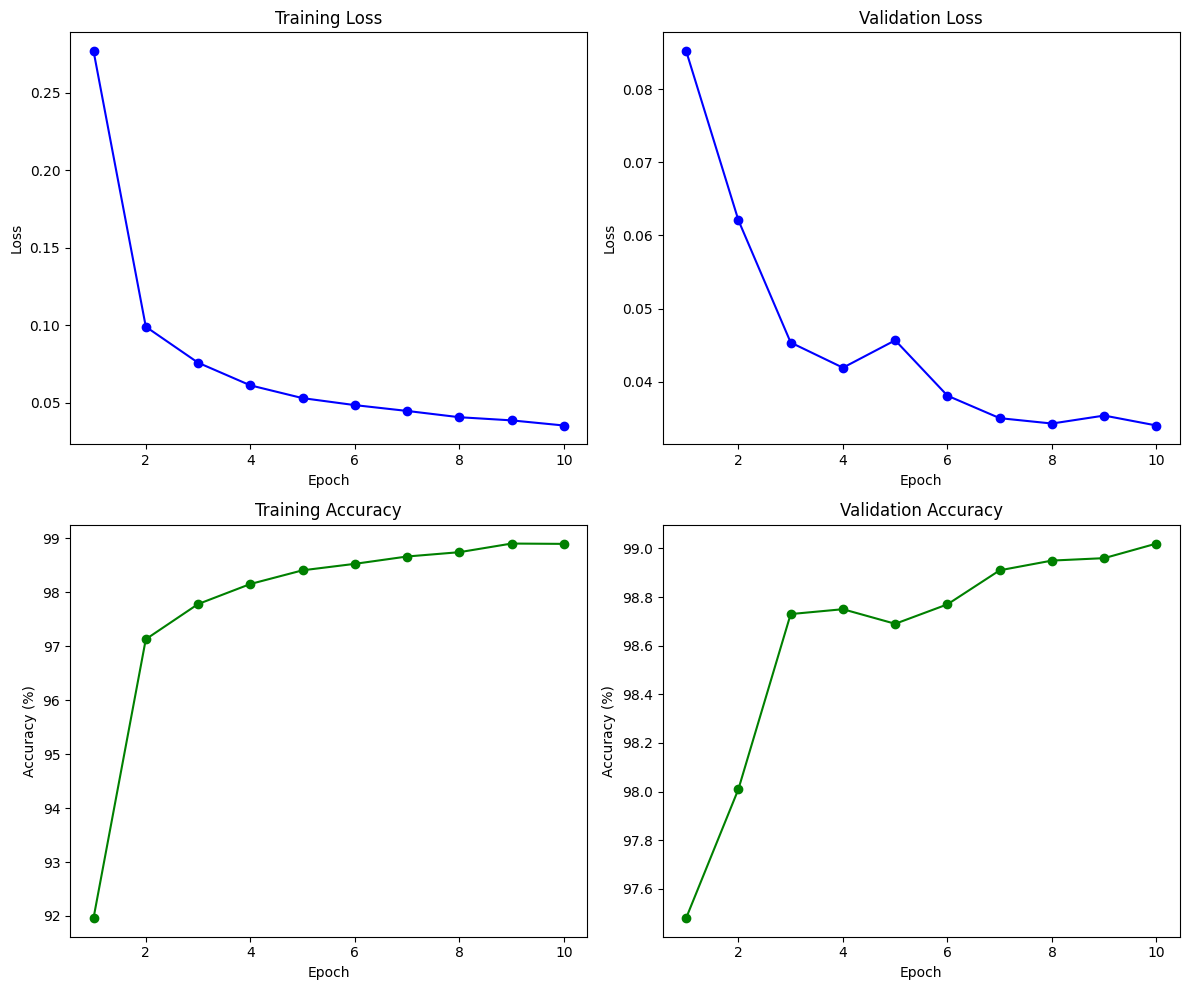

Test Accuracy: 99.08%


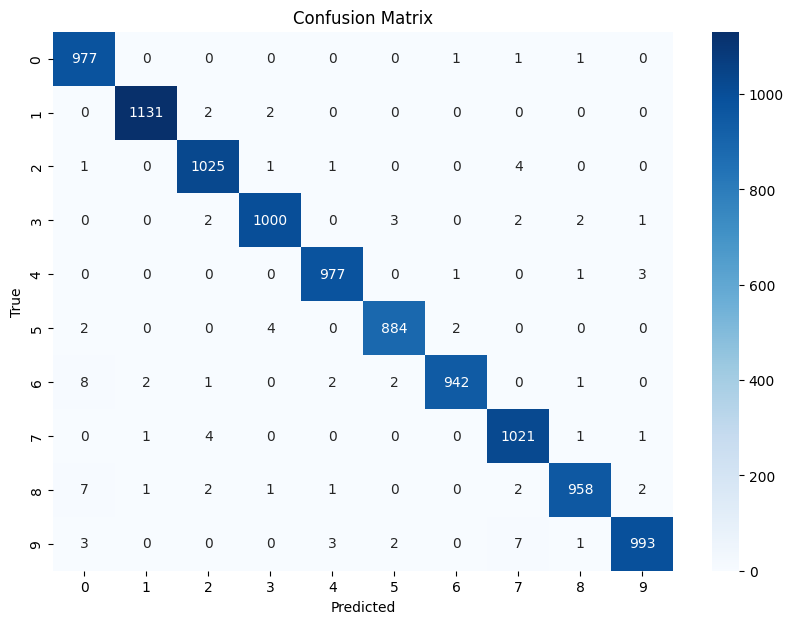

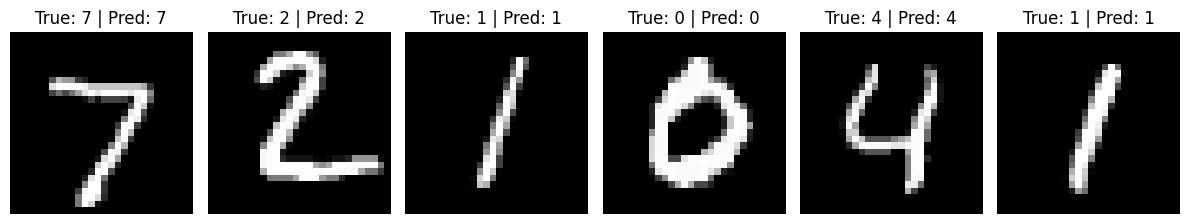

In [18]:
model4 = CNN4Layer()
optimizer = optim.SGD(model4.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Train and test
print("4 Layer Model Train and Test")
train_cnn(model4, train_loader, val_loader, loss_fn, optimizer, epochs=10)
test_cnn(model4, test_loader)

## 5 Layers CNN

In [ ]:
class CNN5Layer(nn.Module):
    def __init__(self):
        super(CNN5Layer, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully Connected Layers
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, 10)

        
        self.dropout = nn.Dropout(0.5)

        
        self.activation_fn = nn.ReLU()

    def forward(self, x):
       
        x = self.pool(self.activation_fn(self.bn1(self.conv1(x))))

        
        x = self.pool(self.activation_fn(self.bn2(self.conv2(x))))

        
        x = self.pool(self.activation_fn(self.bn3(self.conv3(x))))

        # Flatten and pass through fully connected layers
        x = x.view(-1, 128 * 3 * 3)
        x = self.dropout(self.activation_fn(self.fc1(x)))
        x = self.fc2(x)

        return x


5 Layer Model Train and Test
Epoch [1/10]
Training Loss: 0.2857, Accuracy: 92.16%
Validation Loss: 0.0662, Accuracy: 98.17%
Epoch [2/10]
Training Loss: 0.0838, Accuracy: 97.62%
Validation Loss: 0.0508, Accuracy: 98.54%
Epoch [3/10]
Training Loss: 0.0601, Accuracy: 98.22%
Validation Loss: 0.0390, Accuracy: 98.90%
Epoch [4/10]
Training Loss: 0.0477, Accuracy: 98.61%
Validation Loss: 0.0362, Accuracy: 98.98%
Epoch [5/10]
Training Loss: 0.0409, Accuracy: 98.82%
Validation Loss: 0.0340, Accuracy: 98.99%
Epoch [6/10]
Training Loss: 0.0347, Accuracy: 99.04%
Validation Loss: 0.0346, Accuracy: 99.08%
Epoch [7/10]
Training Loss: 0.0299, Accuracy: 99.13%
Validation Loss: 0.0318, Accuracy: 99.09%
Epoch [8/10]
Training Loss: 0.0263, Accuracy: 99.22%
Validation Loss: 0.0313, Accuracy: 98.92%
Epoch [9/10]
Training Loss: 0.0243, Accuracy: 99.29%
Validation Loss: 0.0310, Accuracy: 99.10%
Epoch [10/10]
Training Loss: 0.0212, Accuracy: 99.37%
Validation Loss: 0.0270, Accuracy: 99.23%


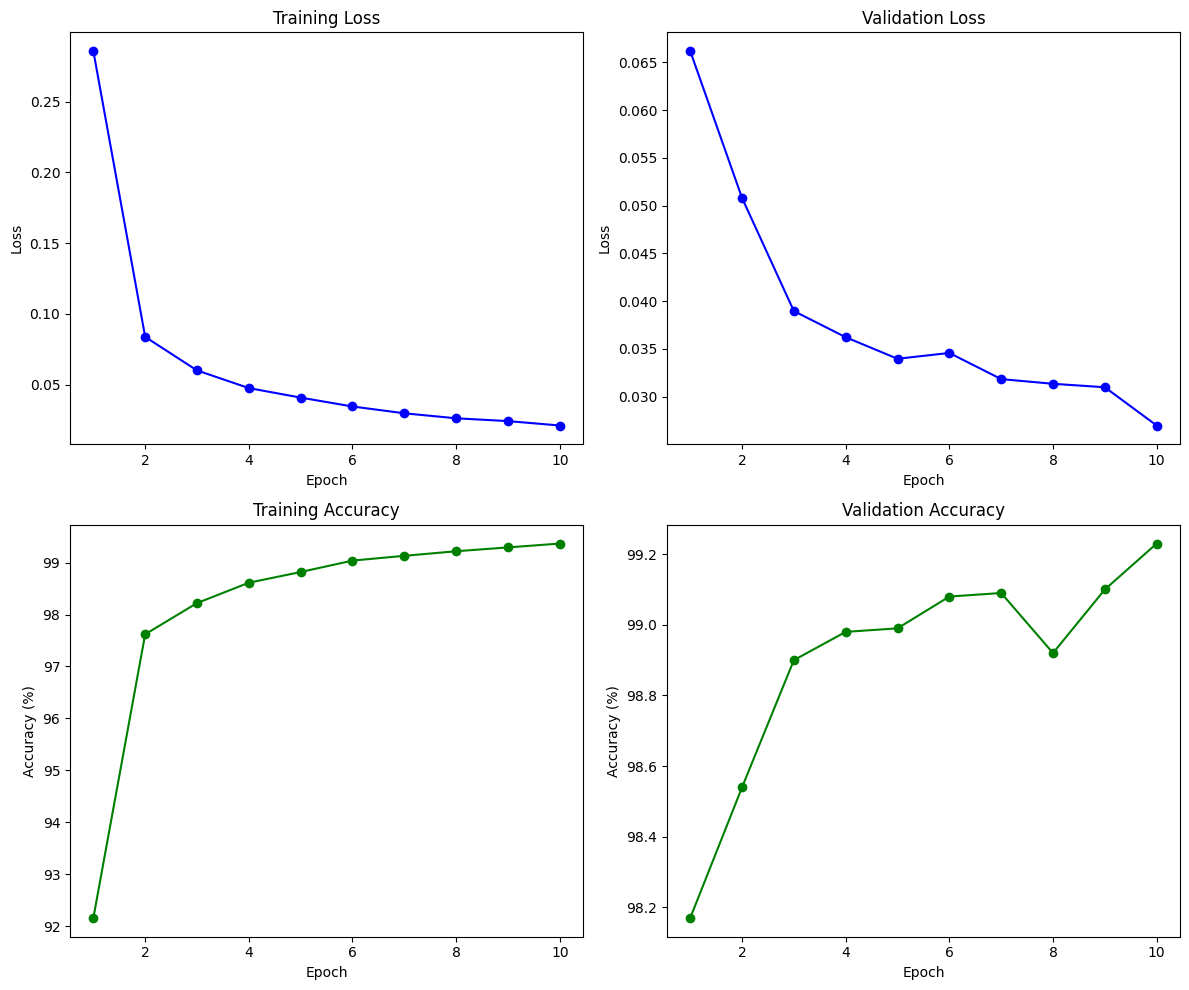

Test Accuracy: 99.25%


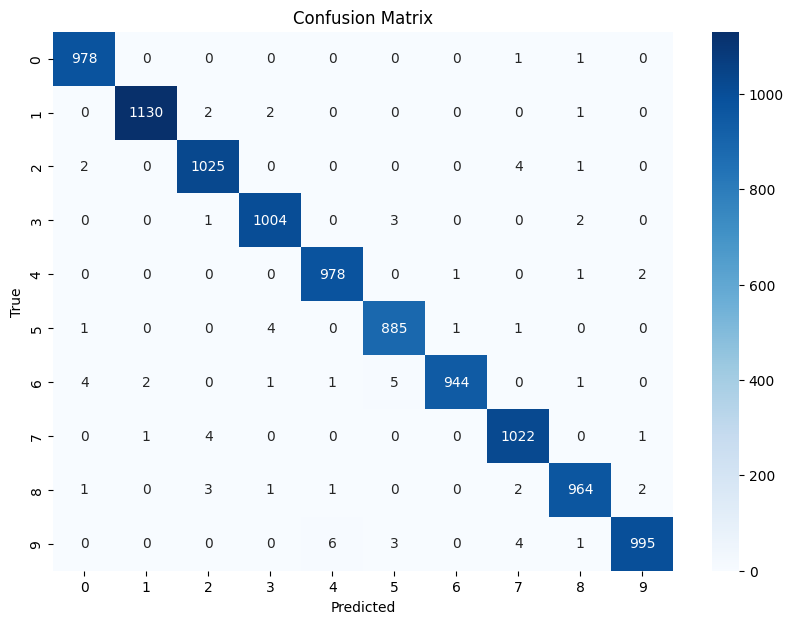

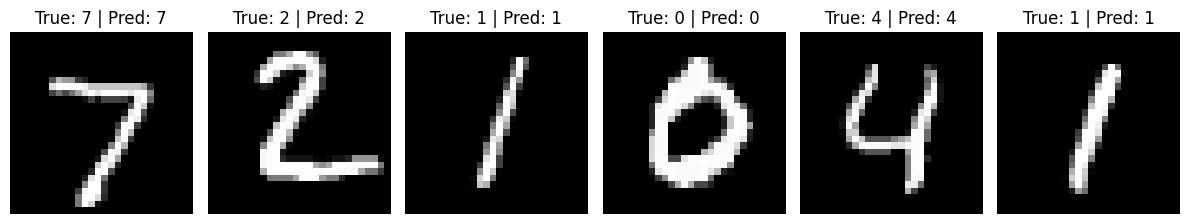

In [20]:
model5 = CNN5Layer()
optimizer = optim.SGD(model5.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Train and test
print("5 Layer Model Train and Test")
train_cnn(model5, train_loader, val_loader, loss_fn, optimizer, epochs=10)
test_cnn(model5, test_loader)


# Best Test Accuracy

| **Best Model**      | **Category**         | **Best Test Accuracy (%)** |
|-----------------|----------------------|----------------------------|
| **5-Layer CNN** | Convolutional Layers | 99.25%                    |
| **Convolutional Neurons[64, 128]** | Number of Neurons | 98.83%                    |
| **64** | Batch Size | 98.88%                    |
| **0.1** | Learning Rate | 99.28%                    |

